In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import newaxis
import random as rand
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings
from sklearn.metrics import mean_squared_error as mse

Using TensorFlow backend.


In [10]:
## Method for moving averages

# if you want to change the number of values you want then change this line: closing_prices = df.iloc[0:30].values
# say you want more data points: closing_prices = df.iloc[0:50].values
# if you want a larger interval to average ie price(t) + price(delta + t) / interval --> then change the interval
# interval is just the days you are dividing by the changes in price

# parameters you might want to put in
def movingaverage(number_of_days, stock_list):
    
    moving_avg = []
    interval = 5
    
    for stock in stock_list:
        print(stock)
        df = pd.read_csv("../Stock_CSV/" +stock + ".csv")
        df= df[['4. close']]
        closing_prices = df.iloc[0:30].values
        len_prices = len(closing_prices)

        for i in range(len_prices):  
            if i==(len_prices-interval-1):
                break
            
            sum_prices = 0 
            for j in range(interval): 
                print(closing_prices[i+j])
                sum_prices += closing_prices[i+j]

                
            moving_avg.append(sum_prices/interval) 
            
            #you dont need this, it is just a visual
            print('sum:',sum_prices)
            #print('\n') 
            print('moving avg:',moving_avg)
            print('\n')
            
        #clearing moving averages list - you might not need this
        moving_avg.clear()
        
movingaverage('10', ["NVDA"])

NVDA
[262.95]
[266.95]
[259.03]
[268.4]
[243.91]
sum: [1301.24]
moving avg: [array([260.248])]


[266.95]
[259.03]
[268.4]
[243.91]
[255.47]
sum: [1293.76]
moving avg: [array([260.248]), array([258.752])]


[259.03]
[268.4]
[243.91]
[255.47]
[243.07]
sum: [1269.88]
moving avg: [array([260.248]), array([258.752]), array([253.976])]


[268.4]
[243.91]
[255.47]
[243.07]
[263.6]
sum: [1274.45]
moving avg: [array([260.248]), array([258.752]), array([253.976]), array([254.89])]


[243.91]
[255.47]
[243.07]
[263.6]
[265.59]
sum: [1271.64]
moving avg: [array([260.248]), array([258.752]), array([253.976]), array([254.89]), array([254.328])]


[255.47]
[243.07]
[263.6]
[265.59]
[252.73]
sum: [1280.46]
moving avg: [array([260.248]), array([258.752]), array([253.976]), array([254.89]), array([254.328]), array([256.092])]


[243.07]
[263.6]
[265.59]
[252.73]
[257.24]
sum: [1282.23]
moving avg: [array([260.248]), array([258.752]), array([253.976]), array([254.89]), array([254.328]), array([256.092])

In [11]:
def convertData(leng, stock):
    df = pd.DataFrame()
    raw_seq = pd.read_csv("../Stock_CSV/" +stock + ".csv")
    raw_seq = raw_seq.set_index('date')
    raw_seq = raw_seq.iloc[::-1]
    seq = np.array(raw_seq['4. close'])
    df['pred'] = seq[leng:]
    for i in range(0,leng):
        df['val'+str(i)] = seq[i:len(seq)-leng+i]
    return df

In [12]:
dffb = convertData(30,'FB')

In [13]:
dffb

pred      val0    val1    val2    val3    val4    val5    val6  \
0      30.771   38.2318   34.03   31.00   32.00   33.03   31.91   28.84   
1      31.200   34.0300   31.00   32.00   33.03   31.91   28.84   28.19   
2      31.470   31.0000   32.00   33.03   31.91   28.84   28.19   29.60   
3      31.730   32.0000   33.03   31.91   28.84   28.19   29.60   27.72   
4      32.170   33.0300   31.91   28.84   28.19   29.60   27.72   26.90   
...       ...       ...     ...     ...     ...     ...     ...     ...   
1942  148.100  212.3300  213.06  207.19  210.76  213.14  214.18  217.80   
1943  160.980  213.0600  207.19  210.76  213.14  214.18  217.80  217.49   
1944  156.210  207.1900  210.76  213.14  214.18  217.80  217.49  214.58   
1945  163.340  210.7600  213.14  214.18  217.80  217.49  214.58  210.18   
1946  156.790  213.1400  214.18  217.80  217.49  214.58  210.18  200.72   

         val7     val8  ...    val20    val21   val22   val23   val24  \
0      28.190   29.600  ...   31.410   31.911   31.60   31.84   33.05   
1      29.600   27.720  ...   31.911   31.600   31.84   33.05   32.06   
2      27.720   26.900  ...   31.600   31.840   33.05   32.06   33.10   
3      26.900   25.869  ...   31.840   33.050   32.06   33.10   32.23   
4      25.869   26.810  ...   33.050   32.060   33.10   32.23   31.36   
...       ...      ...  ...      ...      ...     ...     ...     ...   
1942  217.490  214.580  ...  169.500  178.190  170.24  154.47  170.28   
1943  214.580  210.180  ...  178.190  170.240  154.47  170.28  146.01   
1944  210.180  200.720  ...  170.240  154.470  170.28  146.01  149.42   
1945  200.720  196.770  ...  154.470  170.280  146.01  149.42  146.96   
1946  196.770  197.200  ...  170.280  146.010  149.42  146.96  153.13   

        val25    val26    val27    val28    val29  
0      32.060   33.100   32.230   31.360   31.095  
1      33.100   32.230   31.360   31.095   30.771  
2      32.230   31.360   31.095   30.771   31.200  
3      31.360   31.095   30.771   31.200   31.470  
4      31.095   30.771   31.200   31.470   31.730  
...       ...      ...      ...      ...      ...  
1942  146.010  149.420  146.960  153.130  149.730  
1943  149.420  146.960  153.130  149.730  148.100  
1944  146.960  153.130  149.730  148.100  160.980  
1945  153.130  149.730  148.100  160.980  156.210  
1946  149.730  148.100  160.980  156.210  163.340  

[1947 rows x 31 columns]

In [14]:
def normalise_windows(window_data):
    normalised_data = []
    normalised_window_0 = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
        normalised_window_0.append(window[0])
    return (normalised_data,normalised_window_0)
#divides each value 

In [15]:
def reverse_normalise(y, reverse, start_val):
    normalised_data = []
    i = start_val
    for valuey in y:
        value = ((float(valuey)+1) * float(reverse[i])) 
        normalised_data.append(value)
        i = i+1
    return normalised_data

In [66]:
def set_data(stock, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])
        
        #result, result_reverse = normalise_windows(result)
        
        result = np.array(result)
        result_reverse = []
        row = round(0.95 * len(result))
        train = result[:int(row), :]
        #np.random.shuffle(train)
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test, result_reverse, row)
    #except:
        #print("file" + stock + ".csv not found")


In [17]:
def set_stock_list():
    arr = []
    with open("../NASDAQ.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(',')
            arr.append(currentline)
    newarr = np.array(arr[0])
    return newarr

In [18]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [19]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted


In [20]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [21]:
def plot_results_multiple(predicted_data, true_data, prediction_len, stock):
    fig = plt.figure(facecolor='white',figsize = (14,4))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.title(stock + " Closing Stock Price")
        plt.legend()
    plt.show()

In [22]:
from keras.models import load_model
#model.save('stock_NN.h5')

In [23]:
def accuracy(y_true, y_pred):
    prev_true = y_true[0]
    prev_pred = y_pred[0]
    correct = 0
    incorrect = 0
    for i in range(1,len(y_pred)):
        if prev_true < y_true[i] and prev_true < y_pred[i]:
            correct = correct+1
        elif prev_true > y_true[i] and prev_true > y_pred[i]:
            correct = correct+1
        else:
            incorrect = incorrect+1
        prev_true = y_true[i]
        prev_pred = y_pred[i]        
    return (correct, incorrect)

In [24]:
def n_day_accuracy(days, y_true, pred):
    y_pred = []
    for nums in pred:
        y_pred.append(nums[-1])
    prev_true = y_true[0]
    correct = 0
    incorrect = 0
    j = days-1
    for i in range(0, len(y_pred)-1):
        if (prev_true < y_true[j] and prev_true < y_pred[i]) or (prev_true > y_true[j] and prev_true > y_pred[i]):
            correct = correct+1
        else:
            incorrect = incorrect+1
        j = j+1
        if j > len(y_true)-1:
            break
        prev_true = y_true[j]
        j = j + days
        if j > len(y_true)-1:
            break
    return (correct, incorrect)
    

In [25]:
def build_model(shape):
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(shape,1)))
    regressor.add(Dropout(0.5))
    # Second LSTM layer
    #regressor.add(LSTM(units=50, return_sequences=True))
    #regressor.add(Dropout(0.6))
    # Third LSTM layer
    #regressor.add(LSTM(units=50, return_sequences=True))
    #regressor.add(Dropout(0.7))
    #model.add(Activation('sigmoid'))
    # Fourth LSTM layer 
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.6))
    # The output layer
   
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
    return regressor

In [26]:
def scale(x_train, x_test, y_train,y_test, scalerX, scalerY):
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
    x_train = scalerX.fit_transform(x_train)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
    x_test = scalerX.fit_transform(x_test)
    y_train = y_train.reshape(-1,1)
    y_train = scalerX.fit_transform(y_train)
    y_test = y_test.reshape(-1,1)
    y_test = scalerX.fit_transform(y_test)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])
    return (x_train, x_test, y_train,y_test, scalerX, scalerY)

In [67]:
seq_length = 10

In [68]:
model = build_model(seq_length)

In [69]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [70]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [71]:
stock_list2 = set_stock_list()
scalerX = preprocessing.StandardScaler()
scalerY = preprocessing.StandardScaler()

In [72]:
epochs = 4
stock_list = set_stock_list()
#for i in range(0,200):
for stock in stock_list:
    #j = rand.randrange(0, len(stock_list)-1)
    #print(stock_list[j])
    print(stock)
    try:
        #x_train,x_test,y_train,y_test, reverse, row = set_data(stock_list[j] , seq_length)
        x_train,x_test,y_train,y_test, reverse, row = set_data(stock , seq_length)
        x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 256,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("not found")



AACG
Train on 2908 samples, validate on 153 samples
Epoch 1/4
2908/2908 [==============================] - 1s 214us/step - loss: 0.3613 - val_loss: 0.1325
Epoch 2/4
2908/2908 [==============================] - 0s 50us/step - loss: 0.1164 - val_loss: 0.1052
Epoch 3/4
2908/2908 [==============================] - 0s 51us/step - loss: 0.0976 - val_loss: 0.0964
Epoch 4/4
2908/2908 [==============================] - 0s 50us/step - loss: 0.0892 - val_loss: 0.0918
AAL
Train on 3466 samples, validate on 182 samples
Epoch 1/4
3466/3466 [==============================] - 0s 49us/step - loss: 0.0556 - val_loss: 0.1360
Epoch 2/4
3466/3466 [==============================] - 0s 49us/step - loss: 0.0523 - val_loss: 0.1310
Epoch 3/4
3466/3466 [==============================] - 0s 51us/step - loss: 0.0541 - val_loss: 0.1330
Epoch 4/4
3466/3466 [==============================] - 0s 50us/step - loss: 0.0512 - val_loss: 0.1558
AAME
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [=======

598/598 [==============================] - 0s 63us/step - loss: 0.0528 - val_loss: 0.2073
ACGL
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0443 - val_loss: 0.0623
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0436 - val_loss: 0.0636
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0439 - val_loss: 0.0635
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0424 - val_loss: 0.0638
ACGLO
not found
ACGLP
Train on 837 samples, validate on 44 samples
Epoch 1/4
837/837 [==============================] - 0s 60us/step - loss: 0.0594 - val_loss: 0.4292
Epoch 2/4
837/837 [==============================] - 0s 62us/step - loss: 0.0610 - val_loss: 0.3717
Epoch 3/4
837/837 [==============================] - 0s 60us/step - loss: 0.0610 - val_loss: 0.3596
Epoch 4/4
837/837 [==============================] - 0s 61us/step - loss: 0.0634 - 

2868/2868 [==============================] - 0s 50us/step - loss: 0.0483 - val_loss: 0.0603
Epoch 4/4
2868/2868 [==============================] - 0s 50us/step - loss: 0.0512 - val_loss: 0.0575
ADAP
Train on 1169 samples, validate on 62 samples
Epoch 1/4
1169/1169 [==============================] - 0s 54us/step - loss: 0.0512 - val_loss: 0.4108
Epoch 2/4
1169/1169 [==============================] - 0s 53us/step - loss: 0.0475 - val_loss: 0.4435
Epoch 3/4
1169/1169 [==============================] - 0s 51us/step - loss: 0.0522 - val_loss: 0.4430
Epoch 4/4
1169/1169 [==============================] - 0s 55us/step - loss: 0.0485 - val_loss: 0.4604
ADBE
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0374 - val_loss: 0.0629
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0431 - val_loss: 0.0648
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0431 - val_lo

4770/4770 [==============================] - 0s 45us/step - loss: 0.0438 - val_loss: 0.0894
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0462 - val_loss: 0.0854
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0420 - val_loss: 0.0863
AEIS
not found
AEMD
Train on 4594 samples, validate on 242 samples
Epoch 1/4
4594/4594 [==============================] - 0s 47us/step - loss: 0.0496 - val_loss: 0.0922
Epoch 2/4
4594/4594 [==============================] - 0s 46us/step - loss: 0.0565 - val_loss: 0.0910
Epoch 3/4
4594/4594 [==============================] - 0s 46us/step - loss: 0.0507 - val_loss: 0.0899
Epoch 4/4
4594/4594 [==============================] - 0s 47us/step - loss: 0.0537 - val_loss: 0.0899
AERI
Train on 1533 samples, validate on 81 samples
Epoch 1/4
1533/1533 [==============================] - 0s 47us/step - loss: 0.0438 - val_loss: 0.0348
Epoch 2/4
1533/1533 [==============================] - 0s 47us/step - loss: 

464/464 [==============================] - 0s 60us/step - loss: 0.1011 - val_loss: 1.3123
Epoch 2/4
464/464 [==============================] - 0s 58us/step - loss: 0.0891 - val_loss: 1.3273
Epoch 3/4
464/464 [==============================] - 0s 62us/step - loss: 0.0978 - val_loss: 1.3157
Epoch 4/4
464/464 [==============================] - 0s 58us/step - loss: 0.0901 - val_loss: 1.3248
AGNC
Train on 2837 samples, validate on 149 samples
Epoch 1/4
2837/2837 [==============================] - 0s 52us/step - loss: 0.0413 - val_loss: 0.0657
Epoch 2/4
2837/2837 [==============================] - 0s 51us/step - loss: 0.0394 - val_loss: 0.0580
Epoch 3/4
2837/2837 [==============================] - 0s 50us/step - loss: 0.0380 - val_loss: 0.0664
Epoch 4/4
2837/2837 [==============================] - 0s 52us/step - loss: 0.0412 - val_loss: 0.0619
AGNCM
Train on 257 samples, validate on 14 samples
Epoch 1/4
257/257 [==============================] - 0s 109us/step - loss: 0.1737 - val_loss: 0.327

AIRG
not found
AIRR
Train on 1446 samples, validate on 76 samples
Epoch 1/4
1446/1446 [==============================] - 0s 51us/step - loss: 0.0388 - val_loss: 0.0372
Epoch 2/4
1446/1446 [==============================] - 0s 51us/step - loss: 0.0437 - val_loss: 0.0313
Epoch 3/4
1446/1446 [==============================] - 0s 50us/step - loss: 0.0360 - val_loss: 0.0318
Epoch 4/4
1446/1446 [==============================] - 0s 51us/step - loss: 0.0367 - val_loss: 0.0330
AIRT
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0393 - val_loss: 0.0522
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0368 - val_loss: 0.0516
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0395 - val_loss: 0.0532
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0383 - val_loss: 0.0528
AIRTP
Train on 190 samples, validate on 10 samples
Epoch 1/4
190/1

4577/4577 [==============================] - 0s 48us/step - loss: 0.0388 - val_loss: 0.0341
ALGR
Train on 380 samples, validate on 20 samples
Epoch 1/4
380/380 [==============================] - 0s 73us/step - loss: 0.0483 - val_loss: 1.4660
Epoch 2/4
380/380 [==============================] - 0s 73us/step - loss: 0.0477 - val_loss: 1.4677
Epoch 3/4
380/380 [==============================] - 0s 76us/step - loss: 0.0504 - val_loss: 1.4634
Epoch 4/4
380/380 [==============================] - 0s 79us/step - loss: 0.0439 - val_loss: 1.4903
ALGRR
Train on 212 samples, validate on 11 samples
Epoch 1/4
212/212 [==============================] - 0s 71us/step - loss: 0.1660 - val_loss: 0.4280
Epoch 2/4
212/212 [==============================] - 0s 75us/step - loss: 0.1508 - val_loss: 0.4279
Epoch 3/4
212/212 [==============================] - 0s 66us/step - loss: 0.1498 - val_loss: 0.4328
Epoch 4/4
212/212 [==============================] - 0s 75us/step - loss: 0.1471 - val_loss: 0.4360
ALGRU
n

572/572 [==============================] - 0s 66us/step - loss: 0.0692 - val_loss: 0.2197
Epoch 4/4
572/572 [==============================] - 0s 70us/step - loss: 0.0778 - val_loss: 0.2162
ALTY
Train on 1125 samples, validate on 59 samples
Epoch 1/4
1125/1125 [==============================] - 0s 53us/step - loss: 0.0702 - val_loss: 0.0307
Epoch 2/4
1125/1125 [==============================] - 0s 53us/step - loss: 0.0712 - val_loss: 0.0312
Epoch 3/4
1125/1125 [==============================] - 0s 57us/step - loss: 0.0760 - val_loss: 0.0354
Epoch 4/4
1125/1125 [==============================] - 0s 57us/step - loss: 0.0678 - val_loss: 0.0332
ALXN
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0349 - val_loss: 0.0474
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0382 - val_loss: 0.0473
Epoch 3/4
4770/4770 [==============================] - 0s 51us/step - loss: 0.0378 - val_loss: 

4770/4770 [==============================] - 0s 48us/step - loss: 0.0369 - val_loss: 0.0459
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0377 - val_loss: 0.0469
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0406 - val_loss: 0.0498
AMOT
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0341 - val_loss: 0.0429
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0309 - val_loss: 0.0454
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0359 - val_loss: 0.0422
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0396 - val_loss: 0.0424
AMPH
not found
AMRB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0364 - val_loss: 0.0350
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss:

620/620 [==============================] - 0s 60us/step - loss: 0.0647 - val_loss: 0.1691
Epoch 2/4
620/620 [==============================] - 0s 63us/step - loss: 0.0609 - val_loss: 0.1673
Epoch 3/4
620/620 [==============================] - 0s 60us/step - loss: 0.0711 - val_loss: 0.1686
Epoch 4/4
620/620 [==============================] - 0s 61us/step - loss: 0.0563 - val_loss: 0.1692
ANDAU
Train on 696 samples, validate on 37 samples
Epoch 1/4
696/696 [==============================] - 0s 56us/step - loss: 0.3214 - val_loss: 0.1521
Epoch 2/4
696/696 [==============================] - 0s 57us/step - loss: 0.3469 - val_loss: 0.1542
Epoch 3/4
696/696 [==============================] - 0s 69us/step - loss: 0.3221 - val_loss: 0.1563
Epoch 4/4
696/696 [==============================] - 0s 60us/step - loss: 0.3091 - val_loss: 0.1748
ANDAW
Train on 596 samples, validate on 31 samples
Epoch 1/4
596/596 [==============================] - 0s 69us/step - loss: 0.0563 - val_loss: 0.0611
Epoch 2/

566/566 [==============================] - 0s 70us/step - loss: 0.0564 - val_loss: 0.1746
APLT
Train on 208 samples, validate on 11 samples
Epoch 1/4
208/208 [==============================] - 0s 82us/step - loss: 0.0597 - val_loss: 0.2035
Epoch 2/4
208/208 [==============================] - 0s 72us/step - loss: 0.0399 - val_loss: 0.2044
Epoch 3/4
208/208 [==============================] - 0s 67us/step - loss: 0.0498 - val_loss: 0.2050
Epoch 4/4
208/208 [==============================] - 0s 77us/step - loss: 0.0544 - val_loss: 0.2064
APM
not found
APOG
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0355 - val_loss: 0.0492
Epoch 2/4
4770/4770 [==============================] - 0s 51us/step - loss: 0.0365 - val_loss: 0.0448
Epoch 3/4
4770/4770 [==============================] - 0s 51us/step - loss: 0.0335 - val_loss: 0.0416
Epoch 4/4
4770/4770 [==============================] - 0s 52us/step - loss: 0.0364 - val

Epoch 4/4
3140/3140 [==============================] - 0s 51us/step - loss: 0.0376 - val_loss: 0.0616
ARCB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0428 - val_loss: 0.0400
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0439 - val_loss: 0.0403
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0443 - val_loss: 0.0432
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0415 - val_loss: 0.0409
ARCC
Train on 3700 samples, validate on 195 samples
Epoch 1/4
3700/3700 [==============================] - 0s 47us/step - loss: 0.0445 - val_loss: 0.0403
Epoch 2/4
3700/3700 [==============================] - 0s 48us/step - loss: 0.0390 - val_loss: 0.0370
Epoch 3/4
3700/3700 [==============================] - 0s 50us/step - loss: 0.0440 - val_loss: 0.0386
Epoch 4/4
3700/3700 [==============================] - 0s 49us/step - loss: 0.04

297/297 [==============================] - 0s 87us/step - loss: 0.0758 - val_loss: 0.5326
Epoch 4/4
297/297 [==============================] - 0s 97us/step - loss: 0.0702 - val_loss: 0.5429
ARYAU
not found
ARYAW
Train on 109 samples, validate on 6 samples
Epoch 1/4
109/109 [==============================] - 0s 128us/step - loss: 0.1731 - val_loss: 1.5620
Epoch 2/4
109/109 [==============================] - 0s 128us/step - loss: 0.2295 - val_loss: 1.5229
Epoch 3/4
109/109 [==============================] - 0s 128us/step - loss: 0.2017 - val_loss: 1.5173
Epoch 4/4
109/109 [==============================] - 0s 146us/step - loss: 0.1599 - val_loss: 1.5213
ASET
Train on 1036 samples, validate on 54 samples
Epoch 1/4
1036/1036 [==============================] - 0s 58us/step - loss: 0.0447 - val_loss: 0.0476
Epoch 2/4
1036/1036 [==============================] - 0s 60us/step - loss: 0.0458 - val_loss: 0.0537
Epoch 3/4
1036/1036 [==============================] - 0s 59us/step - loss: 0.0467 - 

3303/3303 [==============================] - 0s 46us/step - loss: 0.0425 - val_loss: 0.0484
Epoch 3/4
3303/3303 [==============================] - 0s 48us/step - loss: 0.0417 - val_loss: 0.0496
Epoch 4/4
3303/3303 [==============================] - 0s 46us/step - loss: 0.0430 - val_loss: 0.0485
ATEX
Train on 1230 samples, validate on 65 samples
Epoch 1/4
1230/1230 [==============================] - 0s 49us/step - loss: 0.0465 - val_loss: 0.2585
Epoch 2/4
1230/1230 [==============================] - 0s 49us/step - loss: 0.0478 - val_loss: 0.2644
Epoch 3/4
1230/1230 [==============================] - 0s 49us/step - loss: 0.0500 - val_loss: 0.2559
Epoch 4/4
1230/1230 [==============================] - 0s 50us/step - loss: 0.0489 - val_loss: 0.2651
ATHE
Train on 4595 samples, validate on 242 samples
Epoch 1/4
4595/4595 [==============================] - 0s 46us/step - loss: 0.0551 - val_loss: 0.0573
Epoch 2/4
4595/4595 [==============================] - 0s 46us/step - loss: 0.0560 - val_lo

1324/1324 [==============================] - 0s 52us/step - loss: 0.0574 - val_loss: 0.0582
Epoch 2/4
1324/1324 [==============================] - 0s 57us/step - loss: 0.0525 - val_loss: 0.0635
Epoch 3/4
1324/1324 [==============================] - 0s 59us/step - loss: 0.0592 - val_loss: 0.0599
Epoch 4/4
1324/1324 [==============================] - 0s 56us/step - loss: 0.0440 - val_loss: 0.0644
AUTL
Train on 420 samples, validate on 22 samples
Epoch 1/4
420/420 [==============================] - 0s 66us/step - loss: 0.0732 - val_loss: 0.3942
Epoch 2/4
420/420 [==============================] - 0s 66us/step - loss: 0.0602 - val_loss: 0.4063
Epoch 3/4
420/420 [==============================] - 0s 64us/step - loss: 0.0602 - val_loss: 0.4172
Epoch 4/4
420/420 [==============================] - 0s 66us/step - loss: 0.0596 - val_loss: 0.4264
AUTO
Train on 4594 samples, validate on 242 samples
Epoch 1/4
4594/4594 [==============================] - 0s 47us/step - loss: 0.0350 - val_loss: 0.046

AXNX
Train on 333 samples, validate on 18 samples
Epoch 1/4
333/333 [==============================] - 0s 81us/step - loss: 0.0482 - val_loss: 0.4205
Epoch 2/4
333/333 [==============================] - 0s 87us/step - loss: 0.0573 - val_loss: 0.4323
Epoch 3/4
333/333 [==============================] - 0s 81us/step - loss: 0.0522 - val_loss: 0.4642
Epoch 4/4
333/333 [==============================] - 0s 87us/step - loss: 0.0525 - val_loss: 0.4674
AXSM
Train on 1038 samples, validate on 55 samples
Epoch 1/4
1038/1038 [==============================] - 0s 58us/step - loss: 0.0488 - val_loss: 0.0868
Epoch 2/4
1038/1038 [==============================] - 0s 60us/step - loss: 0.0515 - val_loss: 0.0880
Epoch 3/4
1038/1038 [==============================] - 0s 58us/step - loss: 0.0364 - val_loss: 0.0903
Epoch 4/4
1038/1038 [==============================] - 0s 60us/step - loss: 0.0371 - val_loss: 0.0862
AXTI
not found
AY
Train on 1383 samples, validate on 73 samples
Epoch 1/4
1383/1383 [======

4770/4770 [==============================] - 0s 48us/step - loss: 0.0343 - val_loss: 0.0654
BBSI
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0347 - val_loss: 0.0240
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0337 - val_loss: 0.0260
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0350 - val_loss: 0.0310
Epoch 4/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0334 - val_loss: 0.0283
BCBP
Train on 3932 samples, validate on 207 samples
Epoch 1/4
3932/3932 [==============================] - 0s 48us/step - loss: 0.0417 - val_loss: 0.0642
Epoch 2/4
3932/3932 [==============================] - 0s 50us/step - loss: 0.0404 - val_loss: 0.0629
Epoch 3/4
3932/3932 [==============================] - 0s 48us/step - loss: 0.0391 - val_loss: 0.0622
Epoch 4/4
3932/3932 [==============================] - 0s 48us/step - loss: 0.0399 - val_l

3708/3708 [==============================] - 0s 48us/step - loss: 0.0345 - val_loss: 0.0438
Epoch 4/4
3708/3708 [==============================] - 0s 48us/step - loss: 0.0358 - val_loss: 0.0481
BELFA
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0456 - val_loss: 0.0486
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0483 - val_loss: 0.0460
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0449 - val_loss: 0.0490
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0448 - val_loss: 0.0464
BELFB
not found
BFC
Train on 4341 samples, validate on 228 samples
Epoch 1/4
4341/4341 [==============================] - 0s 47us/step - loss: 0.0336 - val_loss: 0.0852
Epoch 2/4
4341/4341 [==============================] - 0s 48us/step - loss: 0.0352 - val_loss: 0.0847
Epoch 3/4
4341/4341 [==============================] - 0s 47us/step - loss

477/477 [==============================] - 0s 59us/step - loss: 0.0531 - val_loss: 0.3207
Epoch 3/4
477/477 [==============================] - 0s 59us/step - loss: 0.0750 - val_loss: 0.3130
Epoch 4/4
477/477 [==============================] - 0s 56us/step - loss: 0.0744 - val_loss: 0.3061
BIMI
Train on 3212 samples, validate on 169 samples
Epoch 1/4
3212/3212 [==============================] - 0s 49us/step - loss: 0.0625 - val_loss: 0.2841
Epoch 2/4
3212/3212 [==============================] - 0s 48us/step - loss: 0.0665 - val_loss: 0.2866
Epoch 3/4
3212/3212 [==============================] - 0s 48us/step - loss: 0.0671 - val_loss: 0.2903
Epoch 4/4
3212/3212 [==============================] - 0s 49us/step - loss: 0.0612 - val_loss: 0.2907
BIOC
Train on 3599 samples, validate on 189 samples
Epoch 1/4
3599/3599 [==============================] - 0s 50us/step - loss: 0.0399 - val_loss: 0.0346
Epoch 2/4
3599/3599 [==============================] - 0s 50us/step - loss: 0.0400 - val_loss: 0

3047/3047 [==============================] - 0s 48us/step - loss: 0.0653 - val_loss: 0.0329
Epoch 2/4
3047/3047 [==============================] - 0s 47us/step - loss: 0.0624 - val_loss: 0.0332
Epoch 3/4
3047/3047 [==============================] - 0s 49us/step - loss: 0.0686 - val_loss: 0.0333
Epoch 4/4
3047/3047 [==============================] - 0s 47us/step - loss: 0.0701 - val_loss: 0.0317
BLKB
Train on 3748 samples, validate on 197 samples
Epoch 1/4
3748/3748 [==============================] - 0s 47us/step - loss: 0.0329 - val_loss: 0.0377
Epoch 2/4
3748/3748 [==============================] - 0s 47us/step - loss: 0.0351 - val_loss: 0.0344
Epoch 3/4
3748/3748 [==============================] - 0s 47us/step - loss: 0.0332 - val_loss: 0.0366
Epoch 4/4
3748/3748 [==============================] - 0s 48us/step - loss: 0.0338 - val_loss: 0.0361
BLMN
not found
BLNK
Train on 505 samples, validate on 27 samples
Epoch 1/4
505/505 [==============================] - 0s 57us/step - loss: 0.0

4769/4769 [==============================] - 0s 47us/step - loss: 0.0375 - val_loss: 0.1910
BNTC
Train on 1101 samples, validate on 58 samples
Epoch 1/4
1101/1101 [==============================] - 0s 57us/step - loss: 0.0606 - val_loss: 0.2610
Epoch 2/4
1101/1101 [==============================] - 0s 54us/step - loss: 0.0548 - val_loss: 0.2592
Epoch 3/4
1101/1101 [==============================] - 0s 55us/step - loss: 0.0668 - val_loss: 0.2586
Epoch 4/4
1101/1101 [==============================] - 0s 57us/step - loss: 0.0598 - val_loss: 0.2594
BNTCW
Train on 652 samples, validate on 34 samples
Epoch 1/4
652/652 [==============================] - 0s 58us/step - loss: 0.0765 - val_loss: 1.0934
Epoch 2/4
652/652 [==============================] - 0s 58us/step - loss: 0.0772 - val_loss: 1.0712
Epoch 3/4
652/652 [==============================] - 0s 60us/step - loss: 0.0657 - val_loss: 1.0737
Epoch 4/4
652/652 [==============================] - 0s 63us/step - loss: 0.0765 - val_loss: 1.068

Epoch 4/4
29/29 [==============================] - 0s 516us/step - loss: 0.1426 - val_loss: 0.0054
BPYPO
Train on 147 samples, validate on 8 samples
Epoch 1/4
147/147 [==============================] - 0s 95us/step - loss: 0.1566 - val_loss: 0.5215
Epoch 2/4
147/147 [==============================] - 0s 109us/step - loss: 0.1292 - val_loss: 0.5511
Epoch 3/4
147/147 [==============================] - 0s 95us/step - loss: 0.0632 - val_loss: 0.5586
Epoch 4/4
147/147 [==============================] - 0s 109us/step - loss: 0.0951 - val_loss: 0.5671
BPYPP
not found
BPYU
Train on 376 samples, validate on 20 samples
Epoch 1/4
376/376 [==============================] - 0s 69us/step - loss: 0.0881 - val_loss: 0.3780
Epoch 2/4
376/376 [==============================] - 0s 74us/step - loss: 0.0870 - val_loss: 0.3725
Epoch 3/4
376/376 [==============================] - 0s 72us/step - loss: 0.0901 - val_loss: 0.3793
Epoch 4/4
376/376 [==============================] - 0s 72us/step - loss: 0.0874 - 

Epoch 4/4
1436/1436 [==============================] - 0s 49us/step - loss: 0.0365 - val_loss: 0.0268
BSCK
Train on 1910 samples, validate on 100 samples
Epoch 1/4
1910/1910 [==============================] - 0s 51us/step - loss: 0.0530 - val_loss: 0.2132
Epoch 2/4
1910/1910 [==============================] - 0s 52us/step - loss: 0.0535 - val_loss: 0.2118
Epoch 3/4
1910/1910 [==============================] - 0s 52us/step - loss: 0.0565 - val_loss: 0.2142
Epoch 4/4
1910/1910 [==============================] - 0s 49us/step - loss: 0.0483 - val_loss: 0.2108
BSCL
Train on 1601 samples, validate on 84 samples
Epoch 1/4
1601/1601 [==============================] - 0s 52us/step - loss: 0.0500 - val_loss: 0.1909
Epoch 2/4
1601/1601 [==============================] - 0s 52us/step - loss: 0.0445 - val_loss: 0.1945
Epoch 3/4
1601/1601 [==============================] - 0s 56us/step - loss: 0.0475 - val_loss: 0.1978
Epoch 4/4
1601/1601 [==============================] - 0s 53us/step - loss: 0.048

Epoch 4/4
127/127 [==============================] - 0s 118us/step - loss: 0.0687 - val_loss: 1.2858
BSML
not found
BSMM
Train on 118 samples, validate on 6 samples
Epoch 1/4
118/118 [==============================] - 0s 135us/step - loss: 0.2662 - val_loss: 0.7976
Epoch 2/4
118/118 [==============================] - 0s 118us/step - loss: 0.1676 - val_loss: 0.8206
Epoch 3/4
118/118 [==============================] - 0s 127us/step - loss: 0.1804 - val_loss: 0.8208
Epoch 4/4
118/118 [==============================] - 0s 127us/step - loss: 0.2080 - val_loss: 0.7917
BSMN
Train on 119 samples, validate on 6 samples
Epoch 1/4
119/119 [==============================] - 0s 126us/step - loss: 0.1853 - val_loss: 2.0313
Epoch 2/4
119/119 [==============================] - 0s 126us/step - loss: 0.1475 - val_loss: 2.0690
Epoch 3/4
119/119 [==============================] - 0s 117us/step - loss: 0.1403 - val_loss: 2.0919
Epoch 4/4
119/119 [==============================] - 0s 126us/step - loss: 0.17

Epoch 4/4
225/225 [==============================] - 0s 66us/step - loss: 0.1364 - val_loss: 0.4127
BWB
Train on 486 samples, validate on 26 samples
Epoch 1/4
486/486 [==============================] - 0s 57us/step - loss: 0.0590 - val_loss: 0.2478
Epoch 2/4
486/486 [==============================] - 0s 53us/step - loss: 0.0615 - val_loss: 0.2464
Epoch 3/4
486/486 [==============================] - 0s 60us/step - loss: 0.0617 - val_loss: 0.2463
Epoch 4/4
486/486 [==============================] - 0s 57us/step - loss: 0.0583 - val_loss: 0.2470
BWEN
Train on 3825 samples, validate on 201 samples
Epoch 1/4
3825/3825 [==============================] - 0s 48us/step - loss: 0.0377 - val_loss: 0.0855
Epoch 2/4
3825/3825 [==============================] - 0s 48us/step - loss: 0.0432 - val_loss: 0.0862
Epoch 3/4
3825/3825 [==============================] - 0s 47us/step - loss: 0.0371 - val_loss: 0.0868
Epoch 4/4
3825/3825 [==============================] - 0s 47us/step - loss: 0.0435 - val_loss

4770/4770 [==============================] - 0s 46us/step - loss: 0.0368 - val_loss: 0.0438
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0383 - val_loss: 0.0425
CARA
Train on 1471 samples, validate on 77 samples
Epoch 1/4
1471/1471 [==============================] - 0s 51us/step - loss: 0.0519 - val_loss: 0.0885
Epoch 2/4
1471/1471 [==============================] - 0s 48us/step - loss: 0.0474 - val_loss: 0.0917
Epoch 3/4
1471/1471 [==============================] - 0s 51us/step - loss: 0.0556 - val_loss: 0.0894
Epoch 4/4
1471/1471 [==============================] - 0s 50us/step - loss: 0.0521 - val_loss: 0.0887
CARE
Train on 1796 samples, validate on 94 samples
Epoch 1/4
1796/1796 [==============================] - 0s 53us/step - loss: 0.0354 - val_loss: 0.0161
Epoch 2/4
1796/1796 [==============================] - 0s 56us/step - loss: 0.0372 - val_loss: 0.0216
Epoch 3/4
1796/1796 [==============================] - 0s 56us/step - loss: 0.0336 - val_los

4494/4494 [==============================] - 0s 50us/step - loss: 0.0367 - val_loss: 0.0258
Epoch 3/4
4494/4494 [==============================] - 0s 48us/step - loss: 0.0370 - val_loss: 0.0298
Epoch 4/4
4494/4494 [==============================] - 0s 48us/step - loss: 0.0354 - val_loss: 0.0276
CBIO
not found
CBLI
Train on 3269 samples, validate on 172 samples
Epoch 1/4
3269/3269 [==============================] - 0s 49us/step - loss: 0.0379 - val_loss: 0.1538
Epoch 2/4
3269/3269 [==============================] - 0s 49us/step - loss: 0.0430 - val_loss: 0.1531
Epoch 3/4
3269/3269 [==============================] - 0s 48us/step - loss: 0.0396 - val_loss: 0.1531
Epoch 4/4
3269/3269 [==============================] - 0s 49us/step - loss: 0.0408 - val_loss: 0.1566
CBMB
Train on 355 samples, validate on 19 samples
Epoch 1/4
355/355 [==============================] - 0s 79us/step - loss: 0.1053 - val_loss: 0.7975
Epoch 2/4
355/355 [==============================] - 0s 79us/step - loss: 0.104

1943/1943 [==============================] - 0s 49us/step - loss: 0.0443 - val_loss: 0.0678
Epoch 2/4
1943/1943 [==============================] - 0s 52us/step - loss: 0.0460 - val_loss: 0.0680
Epoch 3/4
1943/1943 [==============================] - 0s 51us/step - loss: 0.0459 - val_loss: 0.0706
Epoch 4/4
1943/1943 [==============================] - 0s 50us/step - loss: 0.0451 - val_loss: 0.0707
CDC
Train on 1371 samples, validate on 72 samples
Epoch 1/4
1371/1371 [==============================] - 0s 52us/step - loss: 0.0366 - val_loss: 0.0414
Epoch 2/4
1371/1371 [==============================] - 0s 54us/step - loss: 0.0370 - val_loss: 0.0389
Epoch 3/4
1371/1371 [==============================] - 0s 56us/step - loss: 0.0352 - val_loss: 0.0387
Epoch 4/4
1371/1371 [==============================] - 0s 57us/step - loss: 0.0364 - val_loss: 0.0410
CDEV
Train on 943 samples, validate on 50 samples
Epoch 1/4
943/943 [==============================] - 0s 55us/step - loss: 0.0395 - val_loss: 0

CENX
not found
CERC
Train on 1042 samples, validate on 55 samples
Epoch 1/4
1042/1042 [==============================] - 0s 62us/step - loss: 0.0487 - val_loss: 0.0699
Epoch 2/4
1042/1042 [==============================] - 0s 57us/step - loss: 0.0490 - val_loss: 0.0693
Epoch 3/4
1042/1042 [==============================] - 0s 60us/step - loss: 0.0505 - val_loss: 0.0807
Epoch 4/4
1042/1042 [==============================] - 0s 61us/step - loss: 0.0517 - val_loss: 0.0710
CERN
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0416 - val_loss: 0.0682
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0420 - val_loss: 0.0671
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0449 - val_loss: 0.0674
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0461 - val_loss: 0.0672
CERS
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770

1371/1371 [==============================] - 0s 55us/step - loss: 0.0359 - val_loss: 0.0458
CFRX
Train on 1323 samples, validate on 70 samples
Epoch 1/4
1323/1323 [==============================] - 0s 54us/step - loss: 0.0401 - val_loss: 0.0840
Epoch 2/4
1323/1323 [==============================] - 0s 54us/step - loss: 0.0415 - val_loss: 0.0839
Epoch 3/4
1323/1323 [==============================] - 0s 54us/step - loss: 0.0411 - val_loss: 0.0847
Epoch 4/4
1323/1323 [==============================] - 0s 57us/step - loss: 0.0385 - val_loss: 0.0842
CG
Train on 1887 samples, validate on 99 samples
Epoch 1/4
1887/1887 [==============================] - 0s 52us/step - loss: 0.0385 - val_loss: 0.0549
Epoch 2/4
1887/1887 [==============================] - 0s 52us/step - loss: 0.0398 - val_loss: 0.0512
Epoch 3/4
1887/1887 [==============================] - 0s 52us/step - loss: 0.0374 - val_loss: 0.0529
Epoch 4/4
1887/1887 [==============================] - 0s 53us/step - loss: 0.0369 - val_loss:

4770/4770 [==============================] - 0s 46us/step - loss: 0.0511 - val_loss: 0.0725
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0427 - val_loss: 0.0741
CHPM
Train on 48 samples, validate on 3 samples
Epoch 1/4
48/48 [==============================] - 0s 291us/step - loss: 0.3158 - val_loss: 0.0315
Epoch 2/4
48/48 [==============================] - 0s 312us/step - loss: 0.2528 - val_loss: 0.0272
Epoch 3/4
48/48 [==============================] - 0s 312us/step - loss: 0.1907 - val_loss: 0.0281
Epoch 4/4
48/48 [==============================] - 0s 332us/step - loss: 0.2015 - val_loss: 0.0333
CHPMU
Train on 80 samples, validate on 4 samples
Epoch 1/4
80/80 [==============================] - 0s 199us/step - loss: 0.2187 - val_loss: 0.7695
Epoch 2/4
80/80 [==============================] - 0s 175us/step - loss: 0.2216 - val_loss: 0.7708
Epoch 3/4
80/80 [==============================] - 0s 187us/step - loss: 0.2762 - val_loss: 0.7724
Epoch 4/4
80/80 

Epoch 3/4
189/189 [==============================] - 0s 79us/step - loss: 0.0957 - val_loss: 0.2793
Epoch 4/4
189/189 [==============================] - 0s 79us/step - loss: 0.0854 - val_loss: 0.2811
CIIC
Train on 35 samples, validate on 2 samples
Epoch 1/4
35/35 [==============================] - 0s 399us/step - loss: 0.2616 - val_loss: 0.9984
Epoch 2/4
35/35 [==============================] - 0s 427us/step - loss: 0.2717 - val_loss: 1.0139
Epoch 3/4
35/35 [==============================] - 0s 399us/step - loss: 0.2315 - val_loss: 1.0217
Epoch 4/4
35/35 [==============================] - 0s 456us/step - loss: 0.1984 - val_loss: 1.0187
CIICU
Train on 57 samples, validate on 3 samples
Epoch 1/4
57/57 [==============================] - 0s 262us/step - loss: 0.2055 - val_loss: 0.9441
Epoch 2/4
57/57 [==============================] - 0s 262us/step - loss: 0.1137 - val_loss: 0.9280
Epoch 3/4
57/57 [==============================] - 0s 280us/step - loss: 0.1388 - val_loss: 0.9142
Epoch 4/4


3069/3069 [==============================] - 0s 48us/step - loss: 0.0368 - val_loss: 0.1064
Epoch 3/4
3069/3069 [==============================] - 0s 47us/step - loss: 0.0368 - val_loss: 0.1081
Epoch 4/4
3069/3069 [==============================] - 0s 47us/step - loss: 0.0344 - val_loss: 0.1081
CLOU
Train on 226 samples, validate on 12 samples
Epoch 1/4
226/226 [==============================] - 0s 66us/step - loss: 0.1227 - val_loss: 1.2030
Epoch 2/4
226/226 [==============================] - 0s 66us/step - loss: 0.1043 - val_loss: 1.2145
Epoch 3/4
226/226 [==============================] - 0s 62us/step - loss: 0.1160 - val_loss: 1.2049
Epoch 4/4
226/226 [==============================] - 0s 66us/step - loss: 0.1139 - val_loss: 1.2237
CLPS
Train on 439 samples, validate on 23 samples
Epoch 1/4
439/439 [==============================] - 0s 59us/step - loss: 0.0606 - val_loss: 1.4049
Epoch 2/4
439/439 [==============================] - 0s 68us/step - loss: 0.0558 - val_loss: 1.4225
Epoc

Epoch 2/4
4136/4136 [==============================] - 0s 48us/step - loss: 0.0343 - val_loss: 0.1462
Epoch 3/4
4136/4136 [==============================] - 0s 48us/step - loss: 0.0330 - val_loss: 0.1451
Epoch 4/4
4136/4136 [==============================] - 0s 48us/step - loss: 0.0335 - val_loss: 0.1448
CMFNL
Train on 354 samples, validate on 19 samples
Epoch 1/4
354/354 [==============================] - 0s 76us/step - loss: 0.2844 - val_loss: 0.3874
Epoch 2/4
354/354 [==============================] - 0s 79us/step - loss: 0.2322 - val_loss: 0.3918
Epoch 3/4
354/354 [==============================] - 0s 79us/step - loss: 0.2357 - val_loss: 0.4107
Epoch 4/4
354/354 [==============================] - 0s 79us/step - loss: 0.2808 - val_loss: 0.3871
CMLS
Train on 4437 samples, validate on 234 samples
Epoch 1/4
4437/4437 [==============================] - 0s 47us/step - loss: 0.0374 - val_loss: 0.0275
Epoch 2/4
4437/4437 [==============================] - 0s 48us/step - loss: 0.0358 - val_

2099/2099 [==============================] - 0s 50us/step - loss: 0.0523 - val_loss: 0.2814
Epoch 2/4
2099/2099 [==============================] - 0s 50us/step - loss: 0.0513 - val_loss: 0.2839
Epoch 3/4
2099/2099 [==============================] - 0s 50us/step - loss: 0.0477 - val_loss: 0.2974
Epoch 4/4
2099/2099 [==============================] - 0s 49us/step - loss: 0.0514 - val_loss: 0.2886
CODA
Train on 2724 samples, validate on 143 samples
Epoch 1/4
2724/2724 [==============================] - 0s 46us/step - loss: 0.0412 - val_loss: 0.0596
Epoch 2/4
2724/2724 [==============================] - 0s 47us/step - loss: 0.0373 - val_loss: 0.0593
Epoch 3/4
2724/2724 [==============================] - 0s 47us/step - loss: 0.0359 - val_loss: 0.0604
Epoch 4/4
2724/2724 [==============================] - 0s 48us/step - loss: 0.0357 - val_loss: 0.0617
CODX
Train on 647 samples, validate on 34 samples
Epoch 1/4
647/647 [==============================] - 0s 60us/step - loss: 0.0551 - val_loss:

3277/3277 [==============================] - 0s 46us/step - loss: 0.0365 - val_loss: 0.0370
COWNL
Train on 427 samples, validate on 22 samples
Epoch 1/4
427/427 [==============================] - 0s 61us/step - loss: 0.0520 - val_loss: 0.5958
Epoch 2/4
427/427 [==============================] - 0s 65us/step - loss: 0.0644 - val_loss: 0.5982
Epoch 3/4
427/427 [==============================] - 0s 61us/step - loss: 0.0631 - val_loss: 0.6242
Epoch 4/4
427/427 [==============================] - 0s 65us/step - loss: 0.0562 - val_loss: 0.6159
COWNZ
Train on 542 samples, validate on 29 samples
Epoch 1/4
542/542 [==============================] - 0s 70us/step - loss: 0.0993 - val_loss: 0.2659
Epoch 2/4
542/542 [==============================] - 0s 74us/step - loss: 0.1029 - val_loss: 0.2887
Epoch 3/4
542/542 [==============================] - 0s 74us/step - loss: 0.1222 - val_loss: 0.2763
Epoch 4/4
542/542 [==============================] - 0s 72us/step - loss: 0.1048 - val_loss: 0.2906
CPAA
n

4770/4770 [==============================] - 0s 48us/step - loss: 0.0417 - val_loss: 0.0474
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0398 - val_loss: 0.0466
CREG
Train on 3666 samples, validate on 193 samples
Epoch 1/4
3666/3666 [==============================] - 0s 50us/step - loss: 0.0487 - val_loss: 0.1677
Epoch 2/4
3666/3666 [==============================] - 0s 48us/step - loss: 0.0508 - val_loss: 0.1679
Epoch 3/4
3666/3666 [==============================] - 0s 49us/step - loss: 0.0472 - val_loss: 0.1709
Epoch 4/4
3666/3666 [==============================] - 0s 48us/step - loss: 0.0467 - val_loss: 0.1695
CRESY
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0393 - val_loss: 0.0182
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0376 - val_loss: 0.0177
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0352 - val_

Epoch 3/4
189/189 [==============================] - 0s 79us/step - loss: 0.0741 - val_loss: 0.7693
Epoch 4/4
189/189 [==============================] - 0s 79us/step - loss: 0.0747 - val_loss: 0.7749
CRWS
Train on 3938 samples, validate on 207 samples
Epoch 1/4
3938/3938 [==============================] - 0s 49us/step - loss: 0.0331 - val_loss: 0.0327
Epoch 2/4
3938/3938 [==============================] - 0s 49us/step - loss: 0.0339 - val_loss: 0.0323
Epoch 3/4
3938/3938 [==============================] - 0s 49us/step - loss: 0.0336 - val_loss: 0.0338
Epoch 4/4
3938/3938 [==============================] - 0s 48us/step - loss: 0.0344 - val_loss: 0.0326
CSA
not found
CSB
Train on 1129 samples, validate on 59 samples
Epoch 1/4
1129/1129 [==============================] - 0s 56us/step - loss: 0.0373 - val_loss: 0.0304
Epoch 2/4
1129/1129 [==============================] - 0s 58us/step - loss: 0.0387 - val_loss: 0.0319
Epoch 3/4
1129/1129 [==============================] - 0s 56us/step - lo

542/542 [==============================] - 0s 70us/step - loss: 0.2605 - val_loss: 0.3978
Epoch 3/4
542/542 [==============================] - 0s 72us/step - loss: 0.2756 - val_loss: 0.3815
Epoch 4/4
542/542 [==============================] - 0s 74us/step - loss: 0.2472 - val_loss: 0.3796
CSWI
Train on 1072 samples, validate on 56 samples
Epoch 1/4
1072/1072 [==============================] - 0s 60us/step - loss: 0.0390 - val_loss: 0.2171
Epoch 2/4
1072/1072 [==============================] - 0s 60us/step - loss: 0.0353 - val_loss: 0.2200
Epoch 3/4
1072/1072 [==============================] - 0s 60us/step - loss: 0.0328 - val_loss: 0.2193
Epoch 4/4
1072/1072 [==============================] - 0s 59us/step - loss: 0.0362 - val_loss: 0.2200
CSX
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0380 - val_loss: 0.0644
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0375 - val_loss: 0.0

4770/4770 [==============================] - 0s 47us/step - loss: 0.0350 - val_loss: 0.0610
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0354 - val_loss: 0.0648
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0344 - val_loss: 0.0610
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0347 - val_loss: 0.0626
CUTR
not found
CVBF
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0365 - val_loss: 0.1714
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0360 - val_loss: 0.1704
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0378 - val_loss: 0.1742
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0376 - val_loss: 0.1744
CVCO
Train on 4002 samples, validate on 211 samples
Epoch 1/4
4002/4002 [==============================] - 0s 47us/step - loss:

4770/4770 [==============================] - 0s 46us/step - loss: 0.0420 - val_loss: 0.0431
CYBR
Train on 1316 samples, validate on 69 samples
Epoch 1/4
1316/1316 [==============================] - 0s 53us/step - loss: 0.0391 - val_loss: 0.0382
Epoch 2/4
1316/1316 [==============================] - 0s 54us/step - loss: 0.0355 - val_loss: 0.0381
Epoch 3/4
1316/1316 [==============================] - 0s 54us/step - loss: 0.0347 - val_loss: 0.0387
Epoch 4/4
1316/1316 [==============================] - 0s 55us/step - loss: 0.0409 - val_loss: 0.0366
CYCC
Train on 3800 samples, validate on 200 samples
Epoch 1/4
3800/3800 [==============================] - 0s 46us/step - loss: 0.0442 - val_loss: 0.0730
Epoch 2/4
3800/3800 [==============================] - 0s 46us/step - loss: 0.0420 - val_loss: 0.0729
Epoch 3/4
3800/3800 [==============================] - 0s 46us/step - loss: 0.0418 - val_loss: 0.0735
Epoch 4/4
3800/3800 [==============================] - 0s 46us/step - loss: 0.0435 - val_lo

4770/4770 [==============================] - 0s 45us/step - loss: 0.0388 - val_loss: 0.0454
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0383 - val_loss: 0.0463
DCOMP
not found
DCPH
Train on 595 samples, validate on 31 samples
Epoch 1/4
595/595 [==============================] - 0s 65us/step - loss: 0.0467 - val_loss: 0.1711
Epoch 2/4
595/595 [==============================] - 0s 67us/step - loss: 0.0425 - val_loss: 0.1758
Epoch 3/4
595/595 [==============================] - 0s 65us/step - loss: 0.0496 - val_loss: 0.1810
Epoch 4/4
595/595 [==============================] - 0s 62us/step - loss: 0.0470 - val_loss: 0.1862
DDIV
Train on 536 samples, validate on 28 samples
Epoch 1/4
536/536 [==============================] - 0s 76us/step - loss: 0.0628 - val_loss: 0.1312
Epoch 2/4
536/536 [==============================] - 0s 74us/step - loss: 0.0602 - val_loss: 0.1364
Epoch 3/4
536/536 [==============================] - 0s 71us/step - loss: 0.0600 - val_los

979/979 [==============================] - 0s 51us/step - loss: 0.1117 - val_loss: 0.1037
Epoch 3/4
979/979 [==============================] - 0s 50us/step - loss: 0.0938 - val_loss: 0.1047
Epoch 4/4
979/979 [==============================] - 0s 53us/step - loss: 0.1071 - val_loss: 0.1046
DHIL
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0314 - val_loss: 0.0315
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0312 - val_loss: 0.0296
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0310 - val_loss: 0.0299
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0312 - val_loss: 0.0307
DINT
Train on 494 samples, validate on 26 samples
Epoch 1/4
494/494 [==============================] - 0s 55us/step - loss: 0.0582 - val_loss: 0.2220
Epoch 2/4
494/494 [==============================] - 0s 57us/step - loss: 0.0568 - val_loss: 0.2404


457/457 [==============================] - 0s 59us/step - loss: 0.0462 - val_loss: 0.5494
Epoch 2/4
457/457 [==============================] - 0s 65us/step - loss: 0.0534 - val_loss: 0.5585
Epoch 3/4
457/457 [==============================] - 0s 63us/step - loss: 0.0529 - val_loss: 0.5556
Epoch 4/4
457/457 [==============================] - 0s 63us/step - loss: 0.0485 - val_loss: 0.5582
DOGZ
Train on 541 samples, validate on 28 samples
Epoch 1/4
541/541 [==============================] - 0s 72us/step - loss: 0.0499 - val_loss: 0.5757
Epoch 2/4
541/541 [==============================] - 0s 72us/step - loss: 0.0572 - val_loss: 0.5714
Epoch 3/4
541/541 [==============================] - 0s 70us/step - loss: 0.0547 - val_loss: 0.5709
Epoch 4/4
541/541 [==============================] - 0s 72us/step - loss: 0.0537 - val_loss: 0.5614
DOMO
Train on 415 samples, validate on 22 samples
Epoch 1/4
415/415 [==============================] - 0s 70us/step - loss: 0.0581 - val_loss: 0.3454
Epoch 2/4


Train on 2017 samples, validate on 106 samples
Epoch 1/4
2017/2017 [==============================] - 0s 46us/step - loss: 0.0457 - val_loss: 0.1395
Epoch 2/4
2017/2017 [==============================] - 0s 49us/step - loss: 0.0478 - val_loss: 0.1413
Epoch 3/4
2017/2017 [==============================] - 0s 48us/step - loss: 0.0495 - val_loss: 0.1415
Epoch 4/4
2017/2017 [==============================] - 0s 49us/step - loss: 0.0500 - val_loss: 0.1450
DSPG
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0356 - val_loss: 0.1238
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0382 - val_loss: 0.1247
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0370 - val_loss: 0.1243
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0394 - val_loss: 0.1247
DSWL
not found
DTEA
Train on 1150 samples, validate on 60 samples
Epoch 1/4
1150/1150

DWSH
Train on 408 samples, validate on 22 samples
Epoch 1/4
408/408 [==============================] - 0s 66us/step - loss: 0.0931 - val_loss: 0.5970
Epoch 2/4
408/408 [==============================] - 0s 68us/step - loss: 0.0838 - val_loss: 0.6005
Epoch 3/4
408/408 [==============================] - 0s 68us/step - loss: 0.0900 - val_loss: 0.5912
Epoch 4/4
408/408 [==============================] - 0s 66us/step - loss: 0.0891 - val_loss: 0.6069
DWSN
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0365 - val_loss: 0.0552
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0354 - val_loss: 0.0543
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0358 - val_loss: 0.0572
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0374 - val_loss: 0.0548
DWUS
Train on 58 samples, validate on 3 samples
Epoch 1/4
58/58 [=========================

2912/2912 [==============================] - 0s 51us/step - loss: 0.0403 - val_loss: 0.0280
EBTC
Train on 3614 samples, validate on 190 samples
Epoch 1/4
3614/3614 [==============================] - 0s 51us/step - loss: 0.0367 - val_loss: 0.1859
Epoch 2/4
3614/3614 [==============================] - 0s 48us/step - loss: 0.0350 - val_loss: 0.1850
Epoch 3/4
3614/3614 [==============================] - 0s 50us/step - loss: 0.0365 - val_loss: 0.1836
Epoch 4/4
3614/3614 [==============================] - 0s 51us/step - loss: 0.0332 - val_loss: 0.1835
ECHO
not found
ECOL
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0329 - val_loss: 0.0289
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0329 - val_loss: 0.0287
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0317 - val_loss: 0.0347
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss:

4770/4770 [==============================] - 0s 49us/step - loss: 0.0342 - val_loss: 0.0486
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0332 - val_loss: 0.0476
EGRX
Train on 1463 samples, validate on 77 samples
Epoch 1/4
1463/1463 [==============================] - 0s 50us/step - loss: 0.0407 - val_loss: 0.0395
Epoch 2/4
1463/1463 [==============================] - 0s 50us/step - loss: 0.0411 - val_loss: 0.0386
Epoch 3/4
1463/1463 [==============================] - 0s 50us/step - loss: 0.0449 - val_loss: 0.0437
Epoch 4/4
1463/1463 [==============================] - 0s 50us/step - loss: 0.0376 - val_loss: 0.0394
EH
Train on 67 samples, validate on 4 samples
Epoch 1/4
67/67 [==============================] - 0s 208us/step - loss: 0.2030 - val_loss: 1.1694
Epoch 2/4
67/67 [==============================] - 0s 208us/step - loss: 0.2033 - val_loss: 1.1582
Epoch 3/4
67/67 [==============================] - 0s 208us/step - loss: 0.1944 - val_loss: 1.1397
Epoc

4705/4705 [==============================] - 0s 48us/step - loss: 0.0341 - val_loss: 0.0422
Epoch 3/4
4705/4705 [==============================] - 0s 48us/step - loss: 0.0355 - val_loss: 0.0422
Epoch 4/4
4705/4705 [==============================] - 0s 46us/step - loss: 0.0349 - val_loss: 0.0423
ENG
not found
ENLV
Train on 1352 samples, validate on 71 samples
Epoch 1/4
1352/1352 [==============================] - 0s 55us/step - loss: 0.0504 - val_loss: 0.0699
Epoch 2/4
1352/1352 [==============================] - 0s 53us/step - loss: 0.0439 - val_loss: 0.0714
Epoch 3/4
1352/1352 [==============================] - 0s 55us/step - loss: 0.0433 - val_loss: 0.0698
Epoch 4/4
1352/1352 [==============================] - 0s 52us/step - loss: 0.0432 - val_loss: 0.0708
ENOB
Train on 1231 samples, validate on 65 samples
Epoch 1/4
1231/1231 [==============================] - 0s 49us/step - loss: 0.0565 - val_loss: 0.0484
Epoch 2/4
1231/1231 [==============================] - 0s 49us/step - loss: 0.

4770/4770 [==============================] - 0s 47us/step - loss: 0.0395 - val_loss: 0.0676
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0452 - val_loss: 0.0680
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0410 - val_loss: 0.0674
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0442 - val_loss: 0.0686
ERIE
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0321 - val_loss: 0.0273
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0304 - val_loss: 0.0259
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0337 - val_loss: 0.0269
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0338 - val_loss: 0.0259
ERII
Train on 2805 samples, validate on 148 samples
Epoch 1/4
2805/2805 [==============================] - 0s 49us/step - loss: 0.0421 - val_l

3240/3240 [==============================] - 0s 49us/step - loss: 0.0333 - val_loss: 0.0362
ETFC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0337 - val_loss: 0.1048
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0335 - val_loss: 0.1058
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0362 - val_loss: 0.1059
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0334 - val_loss: 0.1052
ETNB
Train on 88 samples, validate on 5 samples
Epoch 1/4
88/88 [==============================] - 0s 159us/step - loss: 0.3229 - val_loss: 0.9276
Epoch 2/4
88/88 [==============================] - 0s 170us/step - loss: 0.3086 - val_loss: 0.9479
Epoch 3/4
88/88 [==============================] - 0s 170us/step - loss: 0.2694 - val_loss: 0.9551
Epoch 4/4
88/88 [==============================] - 0s 170us/step - loss: 0.2835 - val_loss: 0.9664
ETON

Epoch 4/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0337 - val_loss: 0.0450
EWJE
not found
EWJV
Train on 247 samples, validate on 13 samples
Epoch 1/4
247/247 [==============================] - 0s 65us/step - loss: 0.0834 - val_loss: 0.6526
Epoch 2/4
247/247 [==============================] - 0s 61us/step - loss: 0.0773 - val_loss: 0.6575
Epoch 3/4
247/247 [==============================] - 0s 65us/step - loss: 0.0723 - val_loss: 0.6262
Epoch 4/4
247/247 [==============================] - 0s 61us/step - loss: 0.0581 - val_loss: 0.6459
EWZS
Train on 2269 samples, validate on 119 samples
Epoch 1/4
2269/2269 [==============================] - 0s 46us/step - loss: 0.0350 - val_loss: 0.0244
Epoch 2/4
2269/2269 [==============================] - 0s 46us/step - loss: 0.0321 - val_loss: 0.0254
Epoch 3/4
2269/2269 [==============================] - 0s 47us/step - loss: 0.0344 - val_loss: 0.0251
Epoch 4/4
2269/2269 [==============================] - 0s 47us/step - loss:

586/586 [==============================] - 0s 68us/step - loss: 0.1067 - val_loss: 0.1880
Epoch 4/4
586/586 [==============================] - 0s 71us/step - loss: 0.1097 - val_loss: 0.1862
EYPT
Train on 3622 samples, validate on 191 samples
Epoch 1/4
3622/3622 [==============================] - 0s 50us/step - loss: 0.0442 - val_loss: 0.0744
Epoch 2/4
3622/3622 [==============================] - 0s 51us/step - loss: 0.0410 - val_loss: 0.0716
Epoch 3/4
3622/3622 [==============================] - 0s 50us/step - loss: 0.0405 - val_loss: 0.0761
Epoch 4/4
3622/3622 [==============================] - 0s 50us/step - loss: 0.0406 - val_loss: 0.0736
EZPW
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0390 - val_loss: 0.0138
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0393 - val_loss: 0.0120
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0371 - val_loss:

4770/4770 [==============================] - 0s 48us/step - loss: 0.0344 - val_loss: 0.0351
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0352 - val_loss: 0.0383
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0360 - val_loss: 0.0295
FBSS
not found
FBZ
Train on 2136 samples, validate on 112 samples
Epoch 1/4
2136/2136 [==============================] - 0s 52us/step - loss: 0.0341 - val_loss: 0.0295
Epoch 2/4
2136/2136 [==============================] - 0s 53us/step - loss: 0.0368 - val_loss: 0.0295
Epoch 3/4
2136/2136 [==============================] - 0s 53us/step - loss: 0.0375 - val_loss: 0.0284
Epoch 4/4
2136/2136 [==============================] - 0s 55us/step - loss: 0.0380 - val_loss: 0.0318
FCA
Train on 2133 samples, validate on 112 samples
Epoch 1/4
2133/2133 [==============================] - 0s 52us/step - loss: 0.0436 - val_loss: 0.0911
Epoch 2/4
2133/2133 [==============================] - 0s 52us/step - loss: 0

1935/1935 [==============================] - 0s 52us/step - loss: 0.0389 - val_loss: 0.0220
Epoch 2/4
1935/1935 [==============================] - 0s 49us/step - loss: 0.0389 - val_loss: 0.0217
Epoch 3/4
1935/1935 [==============================] - 0s 52us/step - loss: 0.0395 - val_loss: 0.0273
Epoch 4/4
1935/1935 [==============================] - 0s 51us/step - loss: 0.0374 - val_loss: 0.0216
FDUS
Train on 2095 samples, validate on 110 samples
Epoch 1/4
2095/2095 [==============================] - 0s 52us/step - loss: 0.0467 - val_loss: 0.0316
Epoch 2/4
2095/2095 [==============================] - 0s 53us/step - loss: 0.0466 - val_loss: 0.0269
Epoch 3/4
2095/2095 [==============================] - 0s 52us/step - loss: 0.0465 - val_loss: 0.0355
Epoch 4/4
2095/2095 [==============================] - 0s 51us/step - loss: 0.0473 - val_loss: 0.0278
FDUSG
Train on 104 samples, validate on 6 samples
Epoch 1/4
104/104 [==============================] - 0s 144us/step - loss: 0.1290 - val_loss

4770/4770 [==============================] - 0s 48us/step - loss: 0.0337 - val_loss: 0.0445
FFNW
not found
FFWM
Train on 1289 samples, validate on 68 samples
Epoch 1/4
1289/1289 [==============================] - 0s 56us/step - loss: 0.0469 - val_loss: 0.0489
Epoch 2/4
1289/1289 [==============================] - 0s 57us/step - loss: 0.0474 - val_loss: 0.0413
Epoch 3/4
1289/1289 [==============================] - 0s 56us/step - loss: 0.0453 - val_loss: 0.0382
Epoch 4/4
1289/1289 [==============================] - 0s 60us/step - loss: 0.0414 - val_loss: 0.0393
FGBI
Train on 4595 samples, validate on 242 samples
Epoch 1/4
4595/4595 [==============================] - 0s 47us/step - loss: 0.0395 - val_loss: 0.0902
Epoch 2/4
4595/4595 [==============================] - 0s 48us/step - loss: 0.0394 - val_loss: 0.0906
Epoch 3/4
4595/4595 [==============================] - 0s 47us/step - loss: 0.0405 - val_loss: 0.0902
Epoch 4/4
4595/4595 [==============================] - 0s 46us/step - loss: 

2132/2132 [==============================] - 0s 52us/step - loss: 0.0378 - val_loss: 0.0340
Epoch 4/4
2132/2132 [==============================] - 0s 53us/step - loss: 0.0385 - val_loss: 0.0281
FKO
Train on 2131 samples, validate on 112 samples
Epoch 1/4
2131/2131 [==============================] - 0s 52us/step - loss: 0.0535 - val_loss: 0.0349
Epoch 2/4
2131/2131 [==============================] - 0s 51us/step - loss: 0.0491 - val_loss: 0.0323
Epoch 3/4
2131/2131 [==============================] - 0s 50us/step - loss: 0.0537 - val_loss: 0.0328
Epoch 4/4
2131/2131 [==============================] - 0s 50us/step - loss: 0.0506 - val_loss: 0.0343
FKU
Train on 1931 samples, validate on 102 samples
Epoch 1/4
1931/1931 [==============================] - 0s 50us/step - loss: 0.0470 - val_loss: 0.0214
Epoch 2/4
1931/1931 [==============================] - 0s 51us/step - loss: 0.0462 - val_loss: 0.0215
Epoch 3/4
1931/1931 [==============================] - 0s 50us/step - loss: 0.0455 - val_los

469/469 [==============================] - 0s 57us/step - loss: 0.0968 - val_loss: 0.2951
Epoch 3/4
469/469 [==============================] - 0s 60us/step - loss: 0.1018 - val_loss: 0.2942
Epoch 4/4
469/469 [==============================] - 0s 62us/step - loss: 0.0926 - val_loss: 0.2966
FMHI
Train on 570 samples, validate on 30 samples
Epoch 1/4
570/570 [==============================] - 0s 66us/step - loss: 0.0405 - val_loss: 0.1003
Epoch 2/4
570/570 [==============================] - 0s 70us/step - loss: 0.0372 - val_loss: 0.1033
Epoch 3/4
570/570 [==============================] - 0s 68us/step - loss: 0.0353 - val_loss: 0.1004
Epoch 4/4
570/570 [==============================] - 0s 73us/step - loss: 0.0377 - val_loss: 0.1001
FMK
Train on 2119 samples, validate on 112 samples
Epoch 1/4
2119/2119 [==============================] - 0s 50us/step - loss: 0.0342 - val_loss: 0.0516
Epoch 2/4
2119/2119 [==============================] - 0s 51us/step - loss: 0.0320 - val_loss: 0.0534
Epoch

4770/4770 [==============================] - 0s 46us/step - loss: 0.0330 - val_loss: 0.0233
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0318 - val_loss: 0.0218
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0335 - val_loss: 0.0240
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0331 - val_loss: 0.0258
FOX
Train on 249 samples, validate on 13 samples
Epoch 1/4
249/249 [==============================] - 0s 56us/step - loss: 0.1148 - val_loss: 0.8000
Epoch 2/4
249/249 [==============================] - 0s 64us/step - loss: 0.0895 - val_loss: 0.8203
Epoch 3/4
249/249 [==============================] - 0s 56us/step - loss: 0.0657 - val_loss: 0.7969
Epoch 4/4
249/249 [==============================] - 0s 60us/step - loss: 0.0577 - val_loss: 0.8025
FOXA
not found
FOXF
Train on 1586 samples, validate on 83 samples
Epoch 1/4
1586/1586 [==============================] - 0s 52us/step - loss: 0.0333 - va

819/819 [==============================] - 0s 61us/step - loss: 0.0419 - val_loss: 0.0361
FSBC
Train on 3004 samples, validate on 158 samples
Epoch 1/4
3004/3004 [==============================] - 0s 46us/step - loss: 0.0332 - val_loss: 0.0348
Epoch 2/4
3004/3004 [==============================] - 0s 47us/step - loss: 0.0368 - val_loss: 0.0362
Epoch 3/4
3004/3004 [==============================] - 0s 47us/step - loss: 0.0357 - val_loss: 0.0397
Epoch 4/4
3004/3004 [==============================] - 0s 46us/step - loss: 0.0338 - val_loss: 0.0388
FSBW
Train on 1843 samples, validate on 97 samples
Epoch 1/4
1843/1843 [==============================] - 0s 52us/step - loss: 0.0332 - val_loss: 0.0241
Epoch 2/4
1843/1843 [==============================] - 0s 52us/step - loss: 0.0331 - val_loss: 0.0243
Epoch 3/4
1843/1843 [==============================] - 0s 51us/step - loss: 0.0308 - val_loss: 0.0237
Epoch 4/4
1843/1843 [==============================] - 0s 52us/step - loss: 0.0332 - val_loss

4770/4770 [==============================] - 0s 46us/step - loss: 0.0359 - val_loss: 0.0245
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0346 - val_loss: 0.0247
FTFT
Train on 3594 samples, validate on 189 samples
Epoch 1/4
3594/3594 [==============================] - 0s 51us/step - loss: 0.0493 - val_loss: 0.0545
Epoch 2/4
3594/3594 [==============================] - 0s 52us/step - loss: 0.0500 - val_loss: 0.0540
Epoch 3/4
3594/3594 [==============================] - 0s 51us/step - loss: 0.0523 - val_loss: 0.0540
Epoch 4/4
3594/3594 [==============================] - 0s 52us/step - loss: 0.0579 - val_loss: 0.0540
FTGC
not found
FTHI
Train on 1487 samples, validate on 78 samples
Epoch 1/4
1487/1487 [==============================] - 0s 50us/step - loss: 0.0505 - val_loss: 0.0299
Epoch 2/4
1487/1487 [==============================] - 0s 51us/step - loss: 0.0521 - val_loss: 0.0286
Epoch 3/4
1487/1487 [==============================] - 0s 48us/step - loss: 

4769/4769 [==============================] - 0s 46us/step - loss: 0.0353 - val_loss: 0.0404
Epoch 3/4
4769/4769 [==============================] - 0s 46us/step - loss: 0.0356 - val_loss: 0.0400
Epoch 4/4
4769/4769 [==============================] - 0s 46us/step - loss: 0.0351 - val_loss: 0.0398
FUTU
Train on 252 samples, validate on 13 samples
Epoch 1/4
252/252 [==============================] - 0s 63us/step - loss: 0.0742 - val_loss: 0.2109
Epoch 2/4
252/252 [==============================] - 0s 59us/step - loss: 0.0671 - val_loss: 0.2147
Epoch 3/4
252/252 [==============================] - 0s 59us/step - loss: 0.0706 - val_loss: 0.2228
Epoch 4/4
252/252 [==============================] - 0s 59us/step - loss: 0.0750 - val_loss: 0.2131
FUV
Train on 599 samples, validate on 32 samples
Epoch 1/4
599/599 [==============================] - 0s 63us/step - loss: 0.1047 - val_loss: 0.1604
Epoch 2/4
599/599 [==============================] - 0s 65us/step - loss: 0.0921 - val_loss: 0.1587
Epoch

1674/1674 [==============================] - 0s 49us/step - loss: 0.0323 - val_loss: 0.0257
Epoch 2/4
1674/1674 [==============================] - 0s 51us/step - loss: 0.0321 - val_loss: 0.0253
Epoch 3/4
1674/1674 [==============================] - 0s 52us/step - loss: 0.0331 - val_loss: 0.0280
Epoch 4/4
1674/1674 [==============================] - 0s 51us/step - loss: 0.0340 - val_loss: 0.0276
GASS
not found
GBCI
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0348 - val_loss: 0.0670
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0374 - val_loss: 0.0668
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0341 - val_loss: 0.0657
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0346 - val_loss: 0.0646
GBDC
Train on 2379 samples, validate on 125 samples
Epoch 1/4
2379/2379 [==============================] - 0s 52us/step - loss:

Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0365 - val_loss: 0.0572
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0426 - val_loss: 0.0565
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0420 - val_loss: 0.0570
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0419 - val_loss: 0.0563
GEVO
Train on 2181 samples, validate on 115 samples
Epoch 1/4
2181/2181 [==============================] - 0s 48us/step - loss: 0.0454 - val_loss: 0.0211
Epoch 2/4
2181/2181 [==============================] - 0s 52us/step - loss: 0.0458 - val_loss: 0.0207
Epoch 3/4
2181/2181 [==============================] - 0s 49us/step - loss: 0.0462 - val_loss: 0.0215
Epoch 4/4
2181/2181 [==============================] - 0s 48us/step - loss: 0.0438 - val_loss: 0.0231
GFED
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [============

Epoch 4/4
3166/3166 [==============================] - 0s 49us/step - loss: 0.0414 - val_loss: 0.0639
GLDI
Train on 1712 samples, validate on 90 samples
Epoch 1/4
1712/1712 [==============================] - 0s 53us/step - loss: 0.0328 - val_loss: 0.2042
Epoch 2/4
1712/1712 [==============================] - 0s 50us/step - loss: 0.0350 - val_loss: 0.2111
Epoch 3/4
1712/1712 [==============================] - 0s 50us/step - loss: 0.0360 - val_loss: 0.2054
Epoch 4/4
1712/1712 [==============================] - 0s 53us/step - loss: 0.0344 - val_loss: 0.2057
GLG
Train on 408 samples, validate on 22 samples
Epoch 1/4
408/408 [==============================] - 0s 71us/step - loss: 0.0754 - val_loss: 0.1908
Epoch 2/4
408/408 [==============================] - 0s 64us/step - loss: 0.0744 - val_loss: 0.1992
Epoch 3/4
408/408 [==============================] - 0s 71us/step - loss: 0.0695 - val_loss: 0.1934
Epoch 4/4
408/408 [==============================] - 0s 71us/step - loss: 0.0721 - val_los

Epoch 4/4
224/224 [==============================] - 0s 67us/step - loss: 0.0352 - val_loss: 0.5505
GNMA
not found
GNMK
Train on 2349 samples, validate on 124 samples
Epoch 1/4
2349/2349 [==============================] - 0s 51us/step - loss: 0.0381 - val_loss: 0.2282
Epoch 2/4
2349/2349 [==============================] - 0s 51us/step - loss: 0.0404 - val_loss: 0.2359
Epoch 3/4
2349/2349 [==============================] - 0s 52us/step - loss: 0.0373 - val_loss: 0.2289
Epoch 4/4
2349/2349 [==============================] - 0s 53us/step - loss: 0.0388 - val_loss: 0.2366
GNOM
Train on 230 samples, validate on 12 samples
Epoch 1/4
230/230 [==============================] - 0s 65us/step - loss: 0.0802 - val_loss: 0.8563
Epoch 2/4
230/230 [==============================] - 0s 65us/step - loss: 0.0903 - val_loss: 0.8749
Epoch 3/4
230/230 [==============================] - 0s 65us/step - loss: 0.0833 - val_loss: 0.8554
Epoch 4/4
230/230 [==============================] - 0s 65us/step - loss: 0

4770/4770 [==============================] - 0s 48us/step - loss: 0.0315 - val_loss: 0.0162
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0327 - val_loss: 0.0165
GPP
Train on 1135 samples, validate on 60 samples
Epoch 1/4
1135/1135 [==============================] - 0s 54us/step - loss: 0.0447 - val_loss: 0.0390
Epoch 2/4
1135/1135 [==============================] - 0s 55us/step - loss: 0.0441 - val_loss: 0.0333
Epoch 3/4
1135/1135 [==============================] - 0s 56us/step - loss: 0.0453 - val_loss: 0.0364
Epoch 4/4
1135/1135 [==============================] - 0s 55us/step - loss: 0.0428 - val_loss: 0.0357
GPRE
Train on 3355 samples, validate on 177 samples
Epoch 1/4
3355/3355 [==============================] - 0s 51us/step - loss: 0.0395 - val_loss: 0.0255
Epoch 2/4
3355/3355 [==============================] - 0s 51us/step - loss: 0.0398 - val_loss: 0.0325
Epoch 3/4
3355/3355 [==============================] - 0s 51us/step - loss: 0.0355 - val_los

4770/4770 [==============================] - 0s 47us/step - loss: 0.0345 - val_loss: 0.0352
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0343 - val_loss: 0.0360
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0367 - val_loss: 0.0308
GSHD
Train on 457 samples, validate on 24 samples
Epoch 1/4
457/457 [==============================] - 0s 59us/step - loss: 0.0414 - val_loss: 0.5154
Epoch 2/4
457/457 [==============================] - 0s 72us/step - loss: 0.0407 - val_loss: 0.5135
Epoch 3/4
457/457 [==============================] - 0s 63us/step - loss: 0.0485 - val_loss: 0.5041
Epoch 4/4
457/457 [==============================] - 0s 61us/step - loss: 0.0546 - val_loss: 0.5097
GSIT
Train on 3107 samples, validate on 164 samples
Epoch 1/4
3107/3107 [==============================] - 0s 51us/step - loss: 0.0384 - val_loss: 0.0881
Epoch 2/4
3107/3107 [==============================] - 0s 50us/step - loss: 0.0393 - val_loss: 0.089

Epoch 2/4
163/163 [==============================] - 0s 92us/step - loss: 0.2984 - val_loss: 0.7962
Epoch 3/4
163/163 [==============================] - 0s 92us/step - loss: 0.2977 - val_loss: 0.7876
Epoch 4/4
163/163 [==============================] - 0s 98us/step - loss: 0.2947 - val_loss: 0.7816
GXGXW
Train on 66 samples, validate on 3 samples
Epoch 1/4
66/66 [==============================] - 0s 212us/step - loss: 0.1344 - val_loss: 0.0077
Epoch 2/4
66/66 [==============================] - 0s 227us/step - loss: 0.1309 - val_loss: 0.0124
Epoch 3/4
66/66 [==============================] - 0s 242us/step - loss: 0.1222 - val_loss: 0.0134
Epoch 4/4
66/66 [==============================] - 0s 227us/step - loss: 0.1259 - val_loss: 0.0106
GXTG
not found
GYRO
Train on 4764 samples, validate on 251 samples
Epoch 1/4
4764/4764 [==============================] - 0s 47us/step - loss: 0.0353 - val_loss: 0.1058
Epoch 2/4
4764/4764 [==============================] - 0s 47us/step - loss: 0.0351 - v

516/516 [==============================] - 0s 79us/step - loss: 0.0934 - val_loss: 0.5966
Epoch 2/4
516/516 [==============================] - 0s 75us/step - loss: 0.0942 - val_loss: 0.5740
Epoch 3/4
516/516 [==============================] - 0s 81us/step - loss: 0.0905 - val_loss: 0.5726
Epoch 4/4
516/516 [==============================] - 0s 75us/step - loss: 0.0913 - val_loss: 0.5703
HCACU
Train on 160 samples, validate on 8 samples
Epoch 1/4
160/160 [==============================] - 0s 93us/step - loss: 0.0688 - val_loss: 1.0670
Epoch 2/4
160/160 [==============================] - 0s 94us/step - loss: 0.0681 - val_loss: 1.0831
Epoch 3/4
160/160 [==============================] - 0s 100us/step - loss: 0.0719 - val_loss: 1.0851
Epoch 4/4
160/160 [==============================] - 0s 100us/step - loss: 0.0571 - val_loss: 1.0861
HCACW
Train on 198 samples, validate on 10 samples
Epoch 1/4
198/198 [==============================] - 0s 81us/step - loss: 0.0733 - val_loss: 0.1871
Epoch 2

3384/3384 [==============================] - 0s 50us/step - loss: 0.0373 - val_loss: 0.0208
Epoch 2/4
3384/3384 [==============================] - 0s 50us/step - loss: 0.0384 - val_loss: 0.0224
Epoch 3/4
3384/3384 [==============================] - 0s 51us/step - loss: 0.0389 - val_loss: 0.0255
Epoch 4/4
3384/3384 [==============================] - 0s 50us/step - loss: 0.0357 - val_loss: 0.0235
HELE
not found
HEPA
Train on 1464 samples, validate on 77 samples
Epoch 1/4
1464/1464 [==============================] - 0s 50us/step - loss: 0.0708 - val_loss: 0.0229
Epoch 2/4
1464/1464 [==============================] - 0s 52us/step - loss: 0.0721 - val_loss: 0.0250
Epoch 3/4
1464/1464 [==============================] - 0s 49us/step - loss: 0.0641 - val_loss: 0.0223
Epoch 4/4
1464/1464 [==============================] - 0s 55us/step - loss: 0.0723 - val_loss: 0.0242
HERD
Train on 212 samples, validate on 11 samples
Epoch 1/4
212/212 [==============================] - 0s 71us/step - loss: 0.08

167/167 [==============================] - 0s 102us/step - loss: 0.0803 - val_loss: 0.9046
Epoch 2/4
167/167 [==============================] - 0s 90us/step - loss: 0.0714 - val_loss: 0.9194
Epoch 3/4
167/167 [==============================] - 0s 96us/step - loss: 0.0859 - val_loss: 0.9197
Epoch 4/4
167/167 [==============================] - 0s 96us/step - loss: 0.0651 - val_loss: 0.9234
HLG
Train on 1130 samples, validate on 59 samples
Epoch 1/4
1130/1130 [==============================] - 0s 56us/step - loss: 0.0357 - val_loss: 0.0802
Epoch 2/4
1130/1130 [==============================] - 0s 58us/step - loss: 0.0347 - val_loss: 0.0800
Epoch 3/4
1130/1130 [==============================] - 0s 56us/step - loss: 0.0323 - val_loss: 0.0798
Epoch 4/4
1130/1130 [==============================] - 0s 55us/step - loss: 0.0311 - val_loss: 0.0806
HLIO
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0354 - val_loss: 0.15

HOVNP
not found
HQI
Train on 4254 samples, validate on 224 samples
Epoch 1/4
4254/4254 [==============================] - 0s 47us/step - loss: 0.0404 - val_loss: 0.0976
Epoch 2/4
4254/4254 [==============================] - 0s 48us/step - loss: 0.0361 - val_loss: 0.0970
Epoch 3/4
4254/4254 [==============================] - 0s 47us/step - loss: 0.0344 - val_loss: 0.0974
Epoch 4/4
4254/4254 [==============================] - 0s 48us/step - loss: 0.0357 - val_loss: 0.0980
HQY
Train on 1352 samples, validate on 71 samples
Epoch 1/4
1352/1352 [==============================] - 0s 52us/step - loss: 0.0340 - val_loss: 0.0719
Epoch 2/4
1352/1352 [==============================] - 0s 54us/step - loss: 0.0338 - val_loss: 0.0702
Epoch 3/4
1352/1352 [==============================] - 0s 56us/step - loss: 0.0345 - val_loss: 0.0732
Epoch 4/4
1352/1352 [==============================] - 0s 56us/step - loss: 0.0370 - val_loss: 0.0718
HROW
Train on 2987 samples, validate on 157 samples
Epoch 1/4
2987/

Epoch 4/4
422/422 [==============================] - 0s 66us/step - loss: 0.0629 - val_loss: 0.4149
HUIZ
Train on 28 samples, validate on 2 samples
Epoch 1/4
28/28 [==============================] - 0s 534us/step - loss: 0.2025 - val_loss: 0.0032
Epoch 2/4
28/28 [==============================] - 0s 534us/step - loss: 0.2255 - val_loss: 0.0066
Epoch 3/4
28/28 [==============================] - 0s 570us/step - loss: 0.1367 - val_loss: 0.0086
Epoch 4/4
28/28 [==============================] - 0s 570us/step - loss: 0.2172 - val_loss: 0.0057
HURC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0353 - val_loss: 0.0465
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0337 - val_loss: 0.0505
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0362 - val_loss: 0.0446
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0340 - val_loss: 0.0

4569/4569 [==============================] - 0s 48us/step - loss: 0.0327 - val_loss: 0.0648
Epoch 4/4
4569/4569 [==============================] - 0s 47us/step - loss: 0.0325 - val_loss: 0.0645
IBCP
Train on 4595 samples, validate on 242 samples
Epoch 1/4
4595/4595 [==============================] - 0s 48us/step - loss: 0.0331 - val_loss: 0.0418
Epoch 2/4
4595/4595 [==============================] - 0s 47us/step - loss: 0.0323 - val_loss: 0.0455
Epoch 3/4
4595/4595 [==============================] - 0s 47us/step - loss: 0.0314 - val_loss: 0.0450
Epoch 4/4
4595/4595 [==============================] - 0s 48us/step - loss: 0.0324 - val_loss: 0.0568
IBKC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0376 - val_loss: 0.0358
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0361 - val_loss: 0.0318
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0346 - val_l

4770/4770 [==============================] - 0s 49us/step - loss: 0.0438 - val_loss: 0.0713
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0429 - val_loss: 0.0712
ICCH
Train on 712 samples, validate on 37 samples
Epoch 1/4
712/712 [==============================] - 0s 53us/step - loss: 0.0619 - val_loss: 0.1012
Epoch 2/4
712/712 [==============================] - 0s 57us/step - loss: 0.0605 - val_loss: 0.1009
Epoch 3/4
712/712 [==============================] - 0s 53us/step - loss: 0.0544 - val_loss: 0.1016
Epoch 4/4
712/712 [==============================] - 0s 55us/step - loss: 0.0544 - val_loss: 0.1017
ICFI
not found
ICHR
Train on 786 samples, validate on 41 samples
Epoch 1/4
786/786 [==============================] - 0s 66us/step - loss: 0.0629 - val_loss: 0.0738
Epoch 2/4
786/786 [==============================] - 0s 67us/step - loss: 0.0697 - val_loss: 0.0719
Epoch 3/4
786/786 [==============================] - 0s 65us/step - loss: 0.0681 - val_loss

4225/4225 [==============================] - 0s 48us/step - loss: 0.0320 - val_loss: 0.0352
Epoch 3/4
4225/4225 [==============================] - 0s 47us/step - loss: 0.0323 - val_loss: 0.0356
Epoch 4/4
4225/4225 [==============================] - 0s 49us/step - loss: 0.0323 - val_loss: 0.0351
IEI
Train on 3158 samples, validate on 166 samples
Epoch 1/4
3158/3158 [==============================] - 0s 48us/step - loss: 0.0349 - val_loss: 0.0293
Epoch 2/4
3158/3158 [==============================] - 0s 50us/step - loss: 0.0341 - val_loss: 0.0290
Epoch 3/4
3158/3158 [==============================] - 0s 51us/step - loss: 0.0342 - val_loss: 0.0288
Epoch 4/4
3158/3158 [==============================] - 0s 49us/step - loss: 0.0323 - val_loss: 0.0298
IEP
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0343 - val_loss: 0.0385
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0323 - val_los

Train on 4767 samples, validate on 251 samples
Epoch 1/4
4767/4767 [==============================] - 0s 49us/step - loss: 0.0389 - val_loss: 0.0405
Epoch 2/4
4767/4767 [==============================] - 0s 47us/step - loss: 0.0390 - val_loss: 0.0402
Epoch 3/4
4767/4767 [==============================] - 0s 47us/step - loss: 0.0358 - val_loss: 0.0397
Epoch 4/4
4767/4767 [==============================] - 0s 48us/step - loss: 0.0390 - val_loss: 0.0387
ILMN
Train on 4698 samples, validate on 247 samples
Epoch 1/4
4698/4698 [==============================] - 0s 48us/step - loss: 0.0318 - val_loss: 0.0794
Epoch 2/4
4698/4698 [==============================] - 0s 48us/step - loss: 0.0319 - val_loss: 0.0789
Epoch 3/4
4698/4698 [==============================] - 0s 47us/step - loss: 0.0323 - val_loss: 0.0794
Epoch 4/4
4698/4698 [==============================] - 0s 48us/step - loss: 0.0327 - val_loss: 0.0809
ILPT
Train on 525 samples, validate on 28 samples
Epoch 1/4
525/525 [================

IMXI
not found
INBK
Train on 3645 samples, validate on 192 samples
Epoch 1/4
3645/3645 [==============================] - 0s 47us/step - loss: 0.0363 - val_loss: 0.0503
Epoch 2/4
3645/3645 [==============================] - 0s 47us/step - loss: 0.0336 - val_loss: 0.0503
Epoch 3/4
3645/3645 [==============================] - 0s 47us/step - loss: 0.0362 - val_loss: 0.0495
Epoch 4/4
3645/3645 [==============================] - 0s 47us/step - loss: 0.0340 - val_loss: 0.0498
INBKL
Train on 814 samples, validate on 43 samples
Epoch 1/4
814/814 [==============================] - 0s 60us/step - loss: 0.2048 - val_loss: 0.1610
Epoch 2/4
814/814 [==============================] - 0s 59us/step - loss: 0.2139 - val_loss: 0.1634
Epoch 3/4
814/814 [==============================] - 0s 60us/step - loss: 0.1934 - val_loss: 0.1629
Epoch 4/4
814/814 [==============================] - 0s 59us/step - loss: 0.1970 - val_loss: 0.1656
INBKZ
Train on 186 samples, validate on 10 samples
Epoch 1/4
186/186 [====

INSUU
Train on 139 samples, validate on 7 samples
Epoch 1/4
139/139 [==============================] - 0s 115us/step - loss: 0.0571 - val_loss: 0.4203
Epoch 2/4
139/139 [==============================] - 0s 108us/step - loss: 0.0488 - val_loss: 0.4183
Epoch 3/4
139/139 [==============================] - 0s 100us/step - loss: 0.0494 - val_loss: 0.4217
Epoch 4/4
139/139 [==============================] - 0s 115us/step - loss: 0.0533 - val_loss: 0.4205
INSUW
Train on 29 samples, validate on 2 samples
Epoch 1/4
29/29 [==============================] - 0s 516us/step - loss: 0.1552 - val_loss: 3.4367
Epoch 2/4
29/29 [==============================] - 0s 516us/step - loss: 0.1274 - val_loss: 3.4816
Epoch 3/4
29/29 [==============================] - 0s 481us/step - loss: 0.1011 - val_loss: 3.5320
Epoch 4/4
29/29 [==============================] - 0s 550us/step - loss: 0.1692 - val_loss: 3.5438
INTC
Train on 4771 samples, validate on 251 samples
Epoch 1/4
4771/4771 [============================

1514/1514 [==============================] - 0s 47us/step - loss: 0.0353 - val_loss: 0.1314
IQ
not found
IRBT
Train on 3436 samples, validate on 181 samples
Epoch 1/4
3436/3436 [==============================] - 0s 49us/step - loss: 0.0343 - val_loss: 0.0479
Epoch 2/4
3436/3436 [==============================] - 0s 48us/step - loss: 0.0341 - val_loss: 0.0467
Epoch 3/4
3436/3436 [==============================] - 0s 49us/step - loss: 0.0355 - val_loss: 0.0471
Epoch 4/4
3436/3436 [==============================] - 0s 49us/step - loss: 0.0393 - val_loss: 0.0506
IRCP
Train on 3918 samples, validate on 206 samples
Epoch 1/4
3918/3918 [==============================] - 0s 49us/step - loss: 0.0331 - val_loss: 0.0301
Epoch 2/4
3918/3918 [==============================] - 0s 49us/step - loss: 0.0307 - val_loss: 0.0322
Epoch 3/4
3918/3918 [==============================] - 0s 49us/step - loss: 0.0343 - val_loss: 0.0317
Epoch 4/4
3918/3918 [==============================] - 0s 49us/step - loss: 0

1487/1487 [==============================] - 0s 48us/step - loss: 0.0516 - val_loss: 0.2375
Epoch 4/4
1487/1487 [==============================] - 0s 50us/step - loss: 0.0481 - val_loss: 0.2348
ITI
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0407 - val_loss: 0.0497
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0345 - val_loss: 0.0558
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0394 - val_loss: 0.0510
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0360 - val_loss: 0.0509
ITIC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0307 - val_loss: 0.0995
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0319 - val_loss: 0.0982
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0312 - val_lo

4770/4770 [==============================] - 0s 49us/step - loss: 0.0320 - val_loss: 0.0448
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0317 - val_loss: 0.0448
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0323 - val_loss: 0.0448
JCOM
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0322 - val_loss: 0.0515
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0335 - val_loss: 0.0538
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0330 - val_loss: 0.0539
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0340 - val_loss: 0.0565
JCS
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0394 - val_loss: 0.0238
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0385 - val_lo

452/452 [==============================] - 0s 60us/step - loss: 0.1621 - val_loss: 0.3218
Epoch 2/4
452/452 [==============================] - 0s 64us/step - loss: 0.1542 - val_loss: 0.3229
Epoch 3/4
452/452 [==============================] - 0s 60us/step - loss: 0.1526 - val_loss: 0.3255
Epoch 4/4
452/452 [==============================] - 0s 64us/step - loss: 0.1574 - val_loss: 0.3252
JRVR
Train on 1263 samples, validate on 66 samples
Epoch 1/4
1263/1263 [==============================] - 0s 49us/step - loss: 0.0430 - val_loss: 0.1165
Epoch 2/4
1263/1263 [==============================] - 0s 47us/step - loss: 0.0429 - val_loss: 0.1157
Epoch 3/4
1263/1263 [==============================] - 0s 48us/step - loss: 0.0408 - val_loss: 0.1174
Epoch 4/4
1263/1263 [==============================] - 0s 50us/step - loss: 0.0440 - val_loss: 0.1165
JSM
not found
JSMD
Train on 977 samples, validate on 51 samples
Epoch 1/4
977/977 [==============================] - 0s 52us/step - loss: 0.0365 - val_

KE
Train on 1289 samples, validate on 68 samples
Epoch 1/4
1289/1289 [==============================] - 0s 55us/step - loss: 0.0459 - val_loss: 0.0563
Epoch 2/4
1289/1289 [==============================] - 0s 58us/step - loss: 0.0426 - val_loss: 0.0493
Epoch 3/4
1289/1289 [==============================] - 0s 55us/step - loss: 0.0406 - val_loss: 0.0455
Epoch 4/4
1289/1289 [==============================] - 0s 58us/step - loss: 0.0379 - val_loss: 0.0455
KELYA
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0394 - val_loss: 0.0184
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0383 - val_loss: 0.0179
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0379 - val_loss: 0.0193
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0387 - val_loss: 0.0186
KELYB
Train on 4754 samples, validate on 250 samples
Epoch 1/4
4754/4754 [========

3004/3004 [==============================] - 0s 47us/step - loss: 0.0405 - val_loss: 0.0242
KNSA
Train on 439 samples, validate on 23 samples
Epoch 1/4
439/439 [==============================] - 0s 59us/step - loss: 0.0615 - val_loss: 0.3812
Epoch 2/4
439/439 [==============================] - 0s 64us/step - loss: 0.0595 - val_loss: 0.3720
Epoch 3/4
439/439 [==============================] - 0s 68us/step - loss: 0.0651 - val_loss: 0.3742
Epoch 4/4
439/439 [==============================] - 0s 64us/step - loss: 0.0512 - val_loss: 0.3899
KNSL
not found
KOD
Train on 352 samples, validate on 18 samples
Epoch 1/4
352/352 [==============================] - 0s 79us/step - loss: 0.0381 - val_loss: 1.3130
Epoch 2/4
352/352 [==============================] - 0s 79us/step - loss: 0.0336 - val_loss: 1.3521
Epoch 3/4
352/352 [==============================] - 0s 77us/step - loss: 0.0337 - val_loss: 1.3515
Epoch 4/4
352/352 [==============================] - 0s 79us/step - loss: 0.0529 - val_loss: 1

556/556 [==============================] - 0s 72us/step - loss: 0.0992 - val_loss: 0.1023
Epoch 4/4
556/556 [==============================] - 0s 74us/step - loss: 0.1155 - val_loss: 0.1023
KZR
Train on 421 samples, validate on 22 samples
Epoch 1/4
421/421 [==============================] - 0s 66us/step - loss: 0.0478 - val_loss: 0.3467
Epoch 2/4
421/421 [==============================] - 0s 69us/step - loss: 0.0410 - val_loss: 0.3551
Epoch 3/4
421/421 [==============================] - 0s 71us/step - loss: 0.0402 - val_loss: 0.3585
Epoch 4/4
421/421 [==============================] - 0s 66us/step - loss: 0.0434 - val_loss: 0.3514
LACQ
Train on 477 samples, validate on 25 samples
Epoch 1/4
477/477 [==============================] - 0s 59us/step - loss: 0.0347 - val_loss: 0.6299
Epoch 2/4
477/477 [==============================] - 0s 56us/step - loss: 0.0343 - val_loss: 0.6355
Epoch 3/4
477/477 [==============================] - 0s 63us/step - loss: 0.0353 - val_loss: 0.6223
Epoch 4/4
4

Epoch 3/4
1288/1288 [==============================] - 0s 57us/step - loss: 0.0350 - val_loss: 0.0966
Epoch 4/4
1288/1288 [==============================] - 0s 57us/step - loss: 0.0354 - val_loss: 0.0960
LBTYA
not found
LBTYB
Train on 3765 samples, validate on 198 samples
Epoch 1/4
3765/3765 [==============================] - 0s 49us/step - loss: 0.0364 - val_loss: 0.0255
Epoch 2/4
3765/3765 [==============================] - 0s 48us/step - loss: 0.0358 - val_loss: 0.0267
Epoch 3/4
3765/3765 [==============================] - 0s 48us/step - loss: 0.0367 - val_loss: 0.0304
Epoch 4/4
3765/3765 [==============================] - 0s 48us/step - loss: 0.0365 - val_loss: 0.0279
LBTYK
Train on 3478 samples, validate on 183 samples
Epoch 1/4
3478/3478 [==============================] - 0s 49us/step - loss: 0.0320 - val_loss: 0.0218
Epoch 2/4
3478/3478 [==============================] - 0s 50us/step - loss: 0.0328 - val_loss: 0.0250
Epoch 3/4
3478/3478 [==============================] - 0s 49us

1525/1525 [==============================] - 0s 48us/step - loss: 0.0339 - val_loss: 0.0595
Epoch 3/4
1525/1525 [==============================] - 0s 48us/step - loss: 0.0342 - val_loss: 0.0591
Epoch 4/4
1525/1525 [==============================] - 0s 47us/step - loss: 0.0353 - val_loss: 0.0597
LGND
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0337 - val_loss: 0.0602
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0346 - val_loss: 0.0600
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0297 - val_loss: 0.0605
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0308 - val_loss: 0.0601
LHCG
Train on 3538 samples, validate on 186 samples
Epoch 1/4
3538/3538 [==============================] - 0s 47us/step - loss: 0.0341 - val_loss: 0.0936
Epoch 2/4
3538/3538 [==============================] - 0s 46us/step - loss: 0.0313 - val_l

2374/2374 [==============================] - 0s 52us/step - loss: 0.0407 - val_loss: 0.2213
Epoch 2/4
2374/2374 [==============================] - 0s 52us/step - loss: 0.0423 - val_loss: 0.2238
Epoch 3/4
2374/2374 [==============================] - 0s 53us/step - loss: 0.0485 - val_loss: 0.2185
Epoch 4/4
2374/2374 [==============================] - 0s 50us/step - loss: 0.0466 - val_loss: 0.2211
LLNW
Train on 3061 samples, validate on 161 samples
Epoch 1/4
3061/3061 [==============================] - 0s 48us/step - loss: 0.0440 - val_loss: 0.0436
Epoch 2/4
3061/3061 [==============================] - 0s 48us/step - loss: 0.0441 - val_loss: 0.0448
Epoch 3/4
3061/3061 [==============================] - 0s 48us/step - loss: 0.0389 - val_loss: 0.0442
Epoch 4/4
3061/3061 [==============================] - 0s 47us/step - loss: 0.0427 - val_loss: 0.0451
LMAT
Train on 3211 samples, validate on 169 samples
Epoch 1/4
3211/3211 [==============================] - 0s 52us/step - loss: 0.0338 - val_l

LOACR
Train on 75 samples, validate on 4 samples
Epoch 1/4
75/75 [==============================] - 0s 199us/step - loss: 0.6044 - val_loss: 0.7381
Epoch 2/4
75/75 [==============================] - 0s 199us/step - loss: 0.5796 - val_loss: 0.7551
Epoch 3/4
75/75 [==============================] - 0s 226us/step - loss: 0.5311 - val_loss: 0.7602
Epoch 4/4
75/75 [==============================] - 0s 199us/step - loss: 0.4981 - val_loss: 0.7723
LOACU
Train on 362 samples, validate on 19 samples
Epoch 1/4
362/362 [==============================] - 0s 77us/step - loss: 0.0820 - val_loss: 0.6187
Epoch 2/4
362/362 [==============================] - 0s 80us/step - loss: 0.0727 - val_loss: 0.6231
Epoch 3/4
362/362 [==============================] - 0s 77us/step - loss: 0.0687 - val_loss: 0.6257
Epoch 4/4
362/362 [==============================] - 0s 80us/step - loss: 0.0834 - val_loss: 0.6216
LOACW
not found
LOAN
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [===============

4770/4770 [==============================] - 0s 48us/step - loss: 0.0311 - val_loss: 0.0357
LRGE
Train on 677 samples, validate on 36 samples
Epoch 1/4
677/677 [==============================] - 0s 60us/step - loss: 0.0383 - val_loss: 0.1466
Epoch 2/4
677/677 [==============================] - 0s 57us/step - loss: 0.0414 - val_loss: 0.1479
Epoch 3/4
677/677 [==============================] - 0s 60us/step - loss: 0.0383 - val_loss: 0.1467
Epoch 4/4
677/677 [==============================] - 0s 57us/step - loss: 0.0458 - val_loss: 0.1448
LSACU
Train on 11 samples, validate on 1 samples
Epoch 1/4
11/11 [==============================] - 0s 1ms/step - loss: 1.1684 - val_loss: 5.7196e-04
Epoch 2/4
11/11 [==============================] - 0s 1ms/step - loss: 1.8574 - val_loss: 0.0014
Epoch 3/4
11/11 [==============================] - 0s 1ms/step - loss: 1.0696 - val_loss: 7.1192e-04
Epoch 4/4
11/11 [==============================] - 0s 1ms/step - loss: 1.0328 - val_loss: 9.0050e-06
LSBK
Trai

Epoch 4/4
238/238 [==============================] - 0s 67us/step - loss: 0.0568 - val_loss: 0.8769
LYL
Train on 580 samples, validate on 30 samples
Epoch 1/4
580/580 [==============================] - 0s 67us/step - loss: 0.0469 - val_loss: 0.4125
Epoch 2/4
580/580 [==============================] - 0s 67us/step - loss: 0.0538 - val_loss: 0.4126
Epoch 3/4
580/580 [==============================] - 0s 69us/step - loss: 0.0543 - val_loss: 0.3988
Epoch 4/4
580/580 [==============================] - 0s 71us/step - loss: 0.0514 - val_loss: 0.4062
LYTS
not found
MACK
Train on 1910 samples, validate on 100 samples
Epoch 1/4
1910/1910 [==============================] - 0s 52us/step - loss: 0.0498 - val_loss: 0.0679
Epoch 2/4
1910/1910 [==============================] - 0s 52us/step - loss: 0.0507 - val_loss: 0.0677
Epoch 3/4
1910/1910 [==============================] - 0s 51us/step - loss: 0.0519 - val_loss: 0.0677
Epoch 4/4
1910/1910 [==============================] - 0s 53us/step - loss: 0.

65/65 [==============================] - 0s 230us/step - loss: 0.0909 - val_loss: 2.7663
Epoch 4/4
65/65 [==============================] - 0s 246us/step - loss: 0.1265 - val_loss: 2.7455
MBOT
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0594 - val_loss: 0.1027
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0591 - val_loss: 0.1015
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0593 - val_loss: 0.1024
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0586 - val_loss: 0.1007
MBRX
Train on 912 samples, validate on 48 samples
Epoch 1/4
912/912 [==============================] - 0s 56us/step - loss: 0.0449 - val_loss: 0.6409
Epoch 2/4
912/912 [==============================] - 0s 52us/step - loss: 0.0529 - val_loss: 0.6417
Epoch 3/4
912/912 [==============================] - 0s 52us/step - loss: 0.0425 - val_loss: 0.6467
Ep

1110/1110 [==============================] - 0s 58us/step - loss: 0.1059 - val_loss: 0.0605
Epoch 3/4
1110/1110 [==============================] - 0s 55us/step - loss: 0.1012 - val_loss: 0.0604
Epoch 4/4
1110/1110 [==============================] - 0s 58us/step - loss: 0.1077 - val_loss: 0.0632
MDGSW
not found
MDIA
Train on 53 samples, validate on 3 samples
Epoch 1/4
53/53 [==============================] - 0s 301us/step - loss: 0.1524 - val_loss: 2.8235
Epoch 2/4
53/53 [==============================] - 0s 282us/step - loss: 0.1432 - val_loss: 2.8634
Epoch 3/4
53/53 [==============================] - 0s 263us/step - loss: 0.1313 - val_loss: 2.8709
Epoch 4/4
53/53 [==============================] - 0s 301us/step - loss: 0.1354 - val_loss: 2.8451
MDIV
Train on 1819 samples, validate on 96 samples
Epoch 1/4
1819/1819 [==============================] - 0s 54us/step - loss: 0.0396 - val_loss: 0.0224
Epoch 2/4
1819/1819 [==============================] - 0s 56us/step - loss: 0.0395 - val_lo

929/929 [==============================] - 0s 55us/step - loss: 0.0536 - val_loss: 0.0722
Epoch 2/4
929/929 [==============================] - 0s 56us/step - loss: 0.0472 - val_loss: 0.0699
Epoch 3/4
929/929 [==============================] - 0s 56us/step - loss: 0.0562 - val_loss: 0.0696
Epoch 4/4
929/929 [==============================] - 0s 57us/step - loss: 0.0435 - val_loss: 0.0732
MFNC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0410 - val_loss: 0.0789
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0400 - val_loss: 0.0758
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0405 - val_loss: 0.0730
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0370 - val_loss: 0.0754
MFSF
not found
MGEE
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0342 

904/904 [==============================] - 0s 57us/step - loss: 0.1734 - val_loss: 0.0882
MINI
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0408 - val_loss: 0.0511
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0353 - val_loss: 0.0491
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0376 - val_loss: 0.0516
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0383 - val_loss: 0.0494
MIRM
Train on 165 samples, validate on 9 samples
Epoch 1/4
165/165 [==============================] - 0s 85us/step - loss: 0.0898 - val_loss: 1.5110
Epoch 2/4
165/165 [==============================] - 0s 91us/step - loss: 0.0795 - val_loss: 1.5100
Epoch 3/4
165/165 [==============================] - 0s 97us/step - loss: 0.0962 - val_loss: 1.5004
Epoch 4/4
165/165 [==============================] - 0s 97us/step - loss: 0.0735 - val_loss: 1.5030
M

257/257 [==============================] - 0s 113us/step - loss: 0.0735 - val_loss: 0.6159
Epoch 4/4
257/257 [==============================] - 0s 113us/step - loss: 0.0732 - val_loss: 0.6357
MNCLU
Train on 265 samples, validate on 14 samples
Epoch 1/4
265/265 [==============================] - 0s 98us/step - loss: 0.0506 - val_loss: 0.4389
Epoch 2/4
265/265 [==============================] - 0s 109us/step - loss: 0.0549 - val_loss: 0.4179
Epoch 3/4
265/265 [==============================] - 0s 109us/step - loss: 0.0455 - val_loss: 0.4241
Epoch 4/4
265/265 [==============================] - 0s 109us/step - loss: 0.0536 - val_loss: 0.4190
MNCLW
not found
MNDO
Train on 4691 samples, validate on 247 samples
Epoch 1/4
4691/4691 [==============================] - 0s 49us/step - loss: 0.0400 - val_loss: 0.0519
Epoch 2/4
4691/4691 [==============================] - 0s 48us/step - loss: 0.0405 - val_loss: 0.0517
Epoch 3/4
4691/4691 [==============================] - 0s 50us/step - loss: 0.0424

504/504 [==============================] - 0s 57us/step - loss: 0.0489 - val_loss: 0.1144
Epoch 3/4
504/504 [==============================] - 0s 55us/step - loss: 0.0489 - val_loss: 0.1188
Epoch 4/4
504/504 [==============================] - 0s 57us/step - loss: 0.0437 - val_loss: 0.1157
MOXC
Train on 1424 samples, validate on 75 samples
Epoch 1/4
1424/1424 [==============================] - 0s 50us/step - loss: 0.0413 - val_loss: 0.0986
Epoch 2/4
1424/1424 [==============================] - 0s 51us/step - loss: 0.0423 - val_loss: 0.1016
Epoch 3/4
1424/1424 [==============================] - 0s 53us/step - loss: 0.0406 - val_loss: 0.0971
Epoch 4/4
1424/1424 [==============================] - 0s 53us/step - loss: 0.0406 - val_loss: 0.0994
MPAA
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0334 - val_loss: 0.0443
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0321 - val_loss: 0.

3053/3053 [==============================] - 0s 48us/step - loss: 0.0347 - val_loss: 0.0541
Epoch 2/4
3053/3053 [==============================] - 0s 49us/step - loss: 0.0340 - val_loss: 0.0539
Epoch 3/4
3053/3053 [==============================] - 0s 49us/step - loss: 0.0338 - val_loss: 0.0560
Epoch 4/4
3053/3053 [==============================] - 0s 48us/step - loss: 0.0347 - val_loss: 0.0570
MSBI
not found
MSEX
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0349 - val_loss: 0.1727
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0348 - val_loss: 0.1744
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0348 - val_loss: 0.1721
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0361 - val_loss: 0.1713
MSFT
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss:

490/490 [==============================] - 0s 59us/step - loss: 0.0585 - val_loss: 0.4341
MUDSW
Train on 324 samples, validate on 17 samples
Epoch 1/4
324/324 [==============================] - 0s 92us/step - loss: 0.1286 - val_loss: 0.5152
Epoch 2/4
324/324 [==============================] - 0s 86us/step - loss: 0.1262 - val_loss: 0.5125
Epoch 3/4
324/324 [==============================] - 0s 89us/step - loss: 0.1361 - val_loss: 0.5068
Epoch 4/4
324/324 [==============================] - 0s 86us/step - loss: 0.1188 - val_loss: 0.5039
MVBF
Train on 2757 samples, validate on 145 samples
Epoch 1/4
2757/2757 [==============================] - 0s 50us/step - loss: 0.0388 - val_loss: 0.0526
Epoch 2/4
2757/2757 [==============================] - 0s 47us/step - loss: 0.0400 - val_loss: 0.0513
Epoch 3/4
2757/2757 [==============================] - 0s 49us/step - loss: 0.0395 - val_loss: 0.0507
Epoch 4/4
2757/2757 [==============================] - 0s 50us/step - loss: 0.0394 - val_loss: 0.0447

Epoch 4/4
22/22 [==============================] - 0s 680us/step - loss: 0.1982 - val_loss: 0.0031
NBEV
not found
NBIX
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0361 - val_loss: 0.0425
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0339 - val_loss: 0.0423
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0324 - val_loss: 0.0425
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0333 - val_loss: 0.0429
NBL
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0370 - val_loss: 0.0255
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0355 - val_loss: 0.0243
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0385 - val_loss: 0.0232
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step -

3833/3833 [==============================] - 0s 47us/step - loss: 0.0318 - val_loss: 0.0546
Epoch 4/4
3833/3833 [==============================] - 0s 49us/step - loss: 0.0306 - val_loss: 0.0541
NEOG
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0336 - val_loss: 0.1120
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0341 - val_loss: 0.1112
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0324 - val_loss: 0.1120
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0330 - val_loss: 0.1119
NEON
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0431 - val_loss: 0.0451
Epoch 2/4
4770/4770 [==============================] - 0s 51us/step - loss: 0.0459 - val_loss: 0.0469
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0369 - val_l

1458/1458 [==============================] - 0s 51us/step - loss: 0.0432 - val_loss: 0.0536
Epoch 3/4
1458/1458 [==============================] - 0s 52us/step - loss: 0.0425 - val_loss: 0.0533
Epoch 4/4
1458/1458 [==============================] - 0s 51us/step - loss: 0.0422 - val_loss: 0.0516
NGHCN
Train on 893 samples, validate on 47 samples
Epoch 1/4
893/893 [==============================] - 0s 57us/step - loss: 0.0515 - val_loss: 0.1630
Epoch 2/4
893/893 [==============================] - 0s 56us/step - loss: 0.0649 - val_loss: 0.1602
Epoch 3/4
893/893 [==============================] - 0s 59us/step - loss: 0.0514 - val_loss: 0.1730
Epoch 4/4
893/893 [==============================] - 0s 58us/step - loss: 0.0730 - val_loss: 0.1725
NGHCO
Train on 1194 samples, validate on 63 samples
Epoch 1/4
1194/1194 [==============================] - 0s 50us/step - loss: 0.0757 - val_loss: 0.1524
Epoch 2/4
1194/1194 [==============================] - 0s 53us/step - loss: 0.0761 - val_loss: 0.15

542/542 [==============================] - 0s 74us/step - loss: 0.0409 - val_loss: 0.0899
Epoch 2/4
542/542 [==============================] - 0s 74us/step - loss: 0.0411 - val_loss: 0.0866
Epoch 3/4
542/542 [==============================] - 0s 72us/step - loss: 0.0378 - val_loss: 0.0855
Epoch 4/4
542/542 [==============================] - 0s 74us/step - loss: 0.0410 - val_loss: 0.0870
NNBR
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0356 - val_loss: 0.0409
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0336 - val_loss: 0.0331
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0365 - val_loss: 0.0325
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0373 - val_loss: 0.0351
NNDM
not found
NODK
Train on 724 samples, validate on 38 samples
Epoch 1/4
724/724 [==============================] - 0s 52us/step - loss: 0.0919 - va

NTGR
Train on 3982 samples, validate on 210 samples
Epoch 1/4
3982/3982 [==============================] - 0s 47us/step - loss: 0.0374 - val_loss: 0.0310
Epoch 2/4
3982/3982 [==============================] - 0s 47us/step - loss: 0.0340 - val_loss: 0.0331
Epoch 3/4
3982/3982 [==============================] - 0s 47us/step - loss: 0.0350 - val_loss: 0.0315
Epoch 4/4
3982/3982 [==============================] - 0s 49us/step - loss: 0.0349 - val_loss: 0.0336
NTIC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 45us/step - loss: 0.0315 - val_loss: 0.0244
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0349 - val_loss: 0.0238
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0325 - val_loss: 0.0232
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0359 - val_loss: 0.0237
NTLA
Train on 929 samples, validate on 49 samples
Epoch 1/4
929/929 [===========

Epoch 4/4
2017/2017 [==============================] - 0s 50us/step - loss: 0.0423 - val_loss: 0.0569
NVIV
Train on 2248 samples, validate on 118 samples
Epoch 1/4
2248/2248 [==============================] - 0s 47us/step - loss: 0.0474 - val_loss: 0.1475
Epoch 2/4
2248/2248 [==============================] - 0s 49us/step - loss: 0.0480 - val_loss: 0.1475
Epoch 3/4
2248/2248 [==============================] - 0s 50us/step - loss: 0.0506 - val_loss: 0.1463
Epoch 4/4
2248/2248 [==============================] - 0s 50us/step - loss: 0.0442 - val_loss: 0.1499
NVMI
not found
NVUS
Train on 1320 samples, validate on 70 samples
Epoch 1/4
1320/1320 [==============================] - 0s 56us/step - loss: 0.0386 - val_loss: 0.0973
Epoch 2/4
1320/1320 [==============================] - 0s 56us/step - loss: 0.0392 - val_loss: 0.0945
Epoch 3/4
1320/1320 [==============================] - 0s 56us/step - loss: 0.0358 - val_loss: 0.0933
Epoch 4/4
1320/1320 [==============================] - 0s 56us/ste

Epoch 3/4
1629/1629 [==============================] - 0s 55us/step - loss: 0.0553 - val_loss: 0.0676
Epoch 4/4
1629/1629 [==============================] - 0s 54us/step - loss: 0.0481 - val_loss: 0.0686
NYMX
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0438 - val_loss: 0.0505
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0422 - val_loss: 0.0513
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0418 - val_loss: 0.0511
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0422 - val_loss: 0.0496
OAS
Train on 2337 samples, validate on 123 samples
Epoch 1/4
2337/2337 [==============================] - 0s 51us/step - loss: 0.0346 - val_loss: 0.0213
Epoch 2/4
2337/2337 [==============================] - 0s 52us/step - loss: 0.0336 - val_loss: 0.0204
Epoch 3/4
2337/2337 [==============================] - 0s 52us/step - loss: 0.035

4770/4770 [==============================] - 0s 47us/step - loss: 0.0363 - val_loss: 0.0281
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0382 - val_loss: 0.0263
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0380 - val_loss: 0.0302
OFLX
not found
OFS
Train on 1763 samples, validate on 93 samples
Epoch 1/4
1763/1763 [==============================] - 0s 48us/step - loss: 0.0563 - val_loss: 0.0350
Epoch 2/4
1763/1763 [==============================] - 0s 50us/step - loss: 0.0551 - val_loss: 0.0347
Epoch 3/4
1763/1763 [==============================] - 0s 48us/step - loss: 0.0559 - val_loss: 0.0354
Epoch 4/4
1763/1763 [==============================] - 0s 50us/step - loss: 0.0563 - val_loss: 0.0324
OFSSI
Train on 105 samples, validate on 6 samples
Epoch 1/4
105/105 [==============================] - 0s 133us/step - loss: 0.2391 - val_loss: 2.6533
Epoch 2/4
105/105 [==============================] - 0s 142us/step - loss: 0.275

Epoch 2/4
36/36 [==============================] - 0s 388us/step - loss: 0.5132 - val_loss: 0.1815
Epoch 3/4
36/36 [==============================] - 0s 388us/step - loss: 0.3871 - val_loss: 0.1885
Epoch 4/4
36/36 [==============================] - 0s 443us/step - loss: 0.4349 - val_loss: 0.1932
ONEQ
Train on 3942 samples, validate on 207 samples
Epoch 1/4
3942/3942 [==============================] - 0s 50us/step - loss: 0.0317 - val_loss: 0.0766
Epoch 2/4
3942/3942 [==============================] - 0s 49us/step - loss: 0.0303 - val_loss: 0.0744
Epoch 3/4
3942/3942 [==============================] - 0s 49us/step - loss: 0.0345 - val_loss: 0.0743
Epoch 4/4
3942/3942 [==============================] - 0s 50us/step - loss: 0.0306 - val_loss: 0.0740
ONEW
Train on 31 samples, validate on 2 samples
Epoch 1/4
31/31 [==============================] - 0s 450us/step - loss: 0.0805 - val_loss: 0.0573
Epoch 2/4
31/31 [==============================] - 0s 515us/step - loss: 0.0709 - val_loss: 0.04

3448/3448 [==============================] - 0s 50us/step - loss: 0.0406 - val_loss: 0.0298
Epoch 2/4
3448/3448 [==============================] - 0s 50us/step - loss: 0.0386 - val_loss: 0.0322
Epoch 3/4
3448/3448 [==============================] - 0s 49us/step - loss: 0.0366 - val_loss: 0.0314
Epoch 4/4
3448/3448 [==============================] - 0s 51us/step - loss: 0.0375 - val_loss: 0.0301
OPTN
Train on 584 samples, validate on 31 samples
Epoch 1/4
584/584 [==============================] - 0s 65us/step - loss: 0.0399 - val_loss: 0.1166
Epoch 2/4
584/584 [==============================] - 0s 65us/step - loss: 0.0397 - val_loss: 0.1153
Epoch 3/4
584/584 [==============================] - 0s 70us/step - loss: 0.0403 - val_loss: 0.1152
Epoch 4/4
584/584 [==============================] - 0s 65us/step - loss: 0.0404 - val_loss: 0.1132
OPTT
Train on 3090 samples, validate on 163 samples
Epoch 1/4
3090/3090 [==============================] - 0s 50us/step - loss: 0.0421 - val_loss: 0.021

4770/4770 [==============================] - 0s 47us/step - loss: 0.0387 - val_loss: 0.0778
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0393 - val_loss: 0.0760
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0412 - val_loss: 0.0778
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0379 - val_loss: 0.0778
OSW
Train on 244 samples, validate on 13 samples
Epoch 1/4
244/244 [==============================] - 0s 57us/step - loss: 0.1336 - val_loss: 0.6245
Epoch 2/4
244/244 [==============================] - 0s 61us/step - loss: 0.0622 - val_loss: 0.6377
Epoch 3/4
244/244 [==============================] - 0s 61us/step - loss: 0.0869 - val_loss: 0.6545
Epoch 4/4
244/244 [==============================] - 0s 65us/step - loss: 0.0614 - val_loss: 0.6635
OTEL
not found
OTEX
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0408 - v

OYST
Train on 95 samples, validate on 5 samples
Epoch 1/4
95/95 [==============================] - 0s 157us/step - loss: 0.0872 - val_loss: 1.7013
Epoch 2/4
95/95 [==============================] - 0s 157us/step - loss: 0.0847 - val_loss: 1.6781
Epoch 3/4
95/95 [==============================] - 0s 168us/step - loss: 0.0774 - val_loss: 1.6562
Epoch 4/4
95/95 [==============================] - 0s 168us/step - loss: 0.0798 - val_loss: 1.6437
OZK
Train on 4588 samples, validate on 242 samples
Epoch 1/4
4588/4588 [==============================] - 0s 47us/step - loss: 0.0425 - val_loss: 0.0444
Epoch 2/4
4588/4588 [==============================] - 0s 47us/step - loss: 0.0396 - val_loss: 0.0432
Epoch 3/4
4588/4588 [==============================] - 0s 48us/step - loss: 0.0413 - val_loss: 0.0431
Epoch 4/4
4588/4588 [==============================] - 0s 49us/step - loss: 0.0417 - val_loss: 0.0430
PAAC
Train on 610 samples, validate on 32 samples
Epoch 1/4
610/610 [============================

852/852 [==============================] - 0s 61us/step - loss: 0.0388 - val_loss: 0.3572
PAVMZ
Train on 369 samples, validate on 19 samples
Epoch 1/4
369/369 [==============================] - 0s 73us/step - loss: 0.1213 - val_loss: 0.3235
Epoch 2/4
369/369 [==============================] - 0s 73us/step - loss: 0.1154 - val_loss: 0.3296
Epoch 3/4
369/369 [==============================] - 0s 81us/step - loss: 0.0880 - val_loss: 0.3205
Epoch 4/4
369/369 [==============================] - 0s 78us/step - loss: 0.0960 - val_loss: 0.3265
PAYS
not found
PAYX
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0353 - val_loss: 0.0771
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0359 - val_loss: 0.0747
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0345 - val_loss: 0.0780
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0340 - v

4770/4770 [==============================] - 0s 48us/step - loss: 0.0353 - val_loss: 0.0573
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0338 - val_loss: 0.0578
PDBC
Train on 1285 samples, validate on 68 samples
Epoch 1/4
1285/1285 [==============================] - 0s 57us/step - loss: 0.0447 - val_loss: 0.0200
Epoch 2/4
1285/1285 [==============================] - 0s 59us/step - loss: 0.0420 - val_loss: 0.0212
Epoch 3/4
1285/1285 [==============================] - 0s 57us/step - loss: 0.0426 - val_loss: 0.0256
Epoch 4/4
1285/1285 [==============================] - 0s 59us/step - loss: 0.0385 - val_loss: 0.0236
PDCE
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0344 - val_loss: 0.0164
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0352 - val_loss: 0.0165
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0345 - val_lo

640/640 [==============================] - 0s 61us/step - loss: 0.0643 - val_loss: 0.1195
Epoch 3/4
640/640 [==============================] - 0s 59us/step - loss: 0.0614 - val_loss: 0.1197
Epoch 4/4
640/640 [==============================] - 0s 61us/step - loss: 0.0694 - val_loss: 0.1201
PETS
not found
PETZ
Train on 599 samples, validate on 32 samples
Epoch 1/4
599/599 [==============================] - 0s 65us/step - loss: 0.0788 - val_loss: 0.3201
Epoch 2/4
599/599 [==============================] - 0s 73us/step - loss: 0.0628 - val_loss: 0.3289
Epoch 3/4
599/599 [==============================] - 0s 70us/step - loss: 0.0560 - val_loss: 0.3306
Epoch 4/4
599/599 [==============================] - 0s 65us/step - loss: 0.0708 - val_loss: 0.3253
PEY
Train on 3657 samples, validate on 192 samples
Epoch 1/4
3657/3657 [==============================] - 0s 49us/step - loss: 0.0332 - val_loss: 0.0392
Epoch 2/4
3657/3657 [==============================] - 0s 50us/step - loss: 0.0320 - val_los

4770/4770 [==============================] - 0s 49us/step - loss: 0.0398 - val_loss: 0.0931
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0403 - val_loss: 0.0934
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0381 - val_loss: 0.0934
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0383 - val_loss: 0.0944
PGNY
Train on 99 samples, validate on 5 samples
Epoch 1/4
99/99 [==============================] - 0s 141us/step - loss: 0.1854 - val_loss: 0.7696
Epoch 2/4
99/99 [==============================] - 0s 141us/step - loss: 0.1776 - val_loss: 0.7599
Epoch 3/4
99/99 [==============================] - 0s 171us/step - loss: 0.1754 - val_loss: 0.7595
Epoch 4/4
99/99 [==============================] - 0s 151us/step - loss: 0.1796 - val_loss: 0.7452
PHAS
Train on 342 samples, validate on 18 samples
Epoch 1/4
342/342 [==============================] - 0s 76us/step - loss: 0.0579 - val_loss: 0.9148
Epoch 2/

Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0324 - val_loss: 0.0308
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0327 - val_loss: 0.0303
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0351 - val_loss: 0.0328
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0343 - val_loss: 0.0303
PKW
Train on 3170 samples, validate on 167 samples
Epoch 1/4
3170/3170 [==============================] - 0s 50us/step - loss: 0.0300 - val_loss: 0.0388
Epoch 2/4
3170/3170 [==============================] - 0s 50us/step - loss: 0.0307 - val_loss: 0.0393
Epoch 3/4
3170/3170 [==============================] - 0s 49us/step - loss: 0.0318 - val_loss: 0.0391
Epoch 4/4
3170/3170 [==============================] - 0s 50us/step - loss: 0.0296 - val_loss: 0.0394
PLAB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [=============

2067/2067 [==============================] - 0s 55us/step - loss: 0.0336 - val_loss: 0.0675
PMOM
Train on 574 samples, validate on 30 samples
Epoch 1/4
574/574 [==============================] - 0s 71us/step - loss: 0.0718 - val_loss: 0.0989
Epoch 2/4
574/574 [==============================] - 0s 68us/step - loss: 0.0739 - val_loss: 0.0988
Epoch 3/4
574/574 [==============================] - 0s 70us/step - loss: 0.0780 - val_loss: 0.0989
Epoch 4/4
574/574 [==============================] - 0s 71us/step - loss: 0.0769 - val_loss: 0.1024
PNBK
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0320 - val_loss: 0.0263
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0325 - val_loss: 0.0264
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0323 - val_loss: 0.0267
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0329 - val_loss: 0.028

973/973 [==============================] - 0s 51us/step - loss: 0.0696 - val_loss: 0.0507
Epoch 4/4
973/973 [==============================] - 0s 52us/step - loss: 0.0769 - val_loss: 0.0494
PPSI
Train on 1584 samples, validate on 83 samples
Epoch 1/4
1584/1584 [==============================] - 0s 57us/step - loss: 0.0419 - val_loss: 0.0931
Epoch 2/4
1584/1584 [==============================] - 0s 55us/step - loss: 0.0440 - val_loss: 0.0945
Epoch 3/4
1584/1584 [==============================] - 0s 55us/step - loss: 0.0424 - val_loss: 0.0884
Epoch 4/4
1584/1584 [==============================] - 0s 56us/step - loss: 0.0439 - val_loss: 0.0882
PRAA
Train on 4154 samples, validate on 219 samples
Epoch 1/4
4154/4154 [==============================] - 0s 50us/step - loss: 0.0439 - val_loss: 0.0608
Epoch 2/4
4154/4154 [==============================] - 0s 50us/step - loss: 0.0402 - val_loss: 0.0613
Epoch 3/4
4154/4154 [==============================] - 0s 49us/step - loss: 0.0396 - val_loss: 

788/788 [==============================] - 0s 67us/step - loss: 0.0334 - val_loss: 0.5575
Epoch 3/4
788/788 [==============================] - 0s 65us/step - loss: 0.0404 - val_loss: 0.5523
Epoch 4/4
788/788 [==============================] - 0s 67us/step - loss: 0.0373 - val_loss: 0.5426
PRTK
Train on 3317 samples, validate on 175 samples
Epoch 1/4
3317/3317 [==============================] - 0s 46us/step - loss: 0.0381 - val_loss: 0.1657
Epoch 2/4
3317/3317 [==============================] - 0s 47us/step - loss: 0.0368 - val_loss: 0.1714
Epoch 3/4
3317/3317 [==============================] - 0s 47us/step - loss: 0.0372 - val_loss: 0.1653
Epoch 4/4
3317/3317 [==============================] - 0s 47us/step - loss: 0.0367 - val_loss: 0.1690
PRTS
not found
PRVB
Train on 400 samples, validate on 21 samples
Epoch 1/4
400/400 [==============================] - 0s 70us/step - loss: 0.0534 - val_loss: 0.5518
Epoch 2/4
400/400 [==============================] - 0s 70us/step - loss: 0.0518 - va

Epoch 2/4
183/183 [==============================] - 0s 82us/step - loss: 0.0653 - val_loss: 1.6817
Epoch 3/4
183/183 [==============================] - 0s 76us/step - loss: 0.0481 - val_loss: 1.6690
Epoch 4/4
183/183 [==============================] - 0s 82us/step - loss: 0.0566 - val_loss: 1.6677
PSTI
Train on 4003 samples, validate on 211 samples
Epoch 1/4
4003/4003 [==============================] - 0s 47us/step - loss: 0.0451 - val_loss: 0.0848
Epoch 2/4
4003/4003 [==============================] - 0s 50us/step - loss: 0.0485 - val_loss: 0.0865
Epoch 3/4
4003/4003 [==============================] - 0s 49us/step - loss: 0.0480 - val_loss: 0.0840
Epoch 4/4
4003/4003 [==============================] - 0s 50us/step - loss: 0.0454 - val_loss: 0.0838
PSTV
Train on 4624 samples, validate on 243 samples
Epoch 1/4
4624/4624 [==============================] - 0s 50us/step - loss: 0.0413 - val_loss: 0.1055
Epoch 2/4
4624/4624 [==============================] - 0s 50us/step - loss: 0.0425 - v

4587/4587 [==============================] - 0s 47us/step - loss: 0.0816 - val_loss: 0.1006
Epoch 2/4
4587/4587 [==============================] - 0s 47us/step - loss: 0.0787 - val_loss: 0.1056
Epoch 3/4
4587/4587 [==============================] - 0s 48us/step - loss: 0.0789 - val_loss: 0.1039
Epoch 4/4
4587/4587 [==============================] - 0s 47us/step - loss: 0.0793 - val_loss: 0.1029
PTVCB
not found
PUB
Train on 1146 samples, validate on 60 samples
Epoch 1/4
1146/1146 [==============================] - 0s 56us/step - loss: 0.0354 - val_loss: 0.0882
Epoch 2/4
1146/1146 [==============================] - 0s 54us/step - loss: 0.0360 - val_loss: 0.0863
Epoch 3/4
1146/1146 [==============================] - 0s 56us/step - loss: 0.0364 - val_loss: 0.0854
Epoch 4/4
1146/1146 [==============================] - 0s 57us/step - loss: 0.0345 - val_loss: 0.0895
PUI
Train on 3446 samples, validate on 181 samples
Epoch 1/4
3446/3446 [==============================] - 0s 49us/step - loss: 0

1412/1412 [==============================] - 0s 53us/step - loss: 0.0416 - val_loss: 0.0759
QBAK
Train on 4721 samples, validate on 248 samples
Epoch 1/4
4721/4721 [==============================] - 0s 48us/step - loss: 0.0411 - val_loss: 0.0444
Epoch 2/4
4721/4721 [==============================] - 0s 48us/step - loss: 0.0380 - val_loss: 0.0467
Epoch 3/4
4721/4721 [==============================] - 0s 49us/step - loss: 0.0363 - val_loss: 0.0475
Epoch 4/4
4721/4721 [==============================] - 0s 49us/step - loss: 0.0381 - val_loss: 0.0509
QCLN
Train on 3136 samples, validate on 165 samples
Epoch 1/4
3136/3136 [==============================] - 0s 50us/step - loss: 0.0352 - val_loss: 0.0549
Epoch 2/4
3136/3136 [==============================] - 0s 50us/step - loss: 0.0356 - val_loss: 0.0526
Epoch 3/4
3136/3136 [==============================] - 0s 50us/step - loss: 0.0395 - val_loss: 0.0528
Epoch 4/4
3136/3136 [==============================] - 0s 51us/step - loss: 0.0383 - val_l

1416/1416 [==============================] - 0s 54us/step - loss: 0.0402 - val_loss: 0.0221
Epoch 4/4
1416/1416 [==============================] - 0s 56us/step - loss: 0.0402 - val_loss: 0.0230
QTRX
not found
QTT
Train on 365 samples, validate on 19 samples
Epoch 1/4
365/365 [==============================] - 0s 79us/step - loss: 0.0724 - val_loss: 0.1142
Epoch 2/4
365/365 [==============================] - 0s 79us/step - loss: 0.0447 - val_loss: 0.1125
Epoch 3/4
365/365 [==============================] - 0s 77us/step - loss: 0.0499 - val_loss: 0.1131
Epoch 4/4
365/365 [==============================] - 0s 74us/step - loss: 0.0589 - val_loss: 0.1123
QUIK
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0471 - val_loss: 0.0206
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0430 - val_loss: 0.0198
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0456 - v

Epoch 3/4
116/116 [==============================] - 0s 129us/step - loss: 0.1018 - val_loss: 1.8678
Epoch 4/4
116/116 [==============================] - 0s 129us/step - loss: 0.1308 - val_loss: 1.8585
RCII
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0373 - val_loss: 0.0365
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0389 - val_loss: 0.0378
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0363 - val_loss: 0.0358
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0400 - val_loss: 0.0389
RCKT
Train on 1221 samples, validate on 64 samples
Epoch 1/4
1221/1221 [==============================] - 0s 51us/step - loss: 0.0461 - val_loss: 0.0661
Epoch 2/4
1221/1221 [==============================] - 0s 51us/step - loss: 0.0387 - val_loss: 0.0663
Epoch 3/4
1221/1221 [==============================] - 0s 52us/step - loss: 0.0438 

4770/4770 [==============================] - 0s 49us/step - loss: 0.0332 - val_loss: 0.0672
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0336 - val_loss: 0.0597
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0350 - val_loss: 0.0592
REGI
Train on 1956 samples, validate on 103 samples
Epoch 1/4
1956/1956 [==============================] - 0s 50us/step - loss: 0.0358 - val_loss: 0.1214
Epoch 2/4
1956/1956 [==============================] - 0s 53us/step - loss: 0.0351 - val_loss: 0.1223
Epoch 3/4
1956/1956 [==============================] - 0s 50us/step - loss: 0.0363 - val_loss: 0.1230
Epoch 4/4
1956/1956 [==============================] - 0s 51us/step - loss: 0.0360 - val_loss: 0.1220
REGN
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0295 - val_loss: 0.0288
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0308 - val_l

Epoch 2/4
1782/1782 [==============================] - 0s 48us/step - loss: 0.0414 - val_loss: 0.0565
Epoch 3/4
1782/1782 [==============================] - 0s 50us/step - loss: 0.0368 - val_loss: 0.0556
Epoch 4/4
1782/1782 [==============================] - 0s 51us/step - loss: 0.0338 - val_loss: 0.0565
RGNX
Train on 1081 samples, validate on 57 samples
Epoch 1/4
1081/1081 [==============================] - 0s 60us/step - loss: 0.0361 - val_loss: 0.0584
Epoch 2/4
1081/1081 [==============================] - 0s 56us/step - loss: 0.0312 - val_loss: 0.0578
Epoch 3/4
1081/1081 [==============================] - 0s 56us/step - loss: 0.0391 - val_loss: 0.0579
Epoch 4/4
1081/1081 [==============================] - 0s 56us/step - loss: 0.0380 - val_loss: 0.0597
RIBT
not found
RICK
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0318 - val_loss: 0.0575
Epoch 2/4
4770/4770 [==============================] - 0s 48us/ste

4770/4770 [==============================] - 0s 48us/step - loss: 0.0433 - val_loss: 0.0396
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0429 - val_loss: 0.0290
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0416 - val_loss: 0.0316
Epoch 4/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0369 - val_loss: 0.0329
RMNI
Train on 1093 samples, validate on 58 samples
Epoch 1/4
1093/1093 [==============================] - 0s 59us/step - loss: 0.0404 - val_loss: 0.2002
Epoch 2/4
1093/1093 [==============================] - 0s 57us/step - loss: 0.0395 - val_loss: 0.2051
Epoch 3/4
1093/1093 [==============================] - 0s 58us/step - loss: 0.0382 - val_loss: 0.2023
Epoch 4/4
1093/1093 [==============================] - 0s 57us/step - loss: 0.0355 - val_loss: 0.2012
RMR
Train on 1022 samples, validate on 54 samples
Epoch 1/4
1022/1022 [==============================] - 0s 52us/step - loss: 0.0344 - val_loss

Train on 942 samples, validate on 50 samples
Epoch 1/4
942/942 [==============================] - 0s 54us/step - loss: 0.0353 - val_loss: 0.0852
Epoch 2/4
942/942 [==============================] - 0s 53us/step - loss: 0.0335 - val_loss: 0.0855
Epoch 3/4
942/942 [==============================] - 0s 55us/step - loss: 0.0362 - val_loss: 0.0866
Epoch 4/4
942/942 [==============================] - 0s 56us/step - loss: 0.0333 - val_loss: 0.0877
ROSEW
not found
ROST
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0341 - val_loss: 0.0575
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0351 - val_loss: 0.0565
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0341 - val_loss: 0.0594
Epoch 4/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0356 - val_loss: 0.0614
RP
Train on 2300 samples, validate on 121 samples
Epoch 1/4
2300/2300 [========

RVNC
Train on 1467 samples, validate on 77 samples
Epoch 1/4
1467/1467 [==============================] - 0s 51us/step - loss: 0.0477 - val_loss: 0.0601
Epoch 2/4
1467/1467 [==============================] - 0s 51us/step - loss: 0.0471 - val_loss: 0.0606
Epoch 3/4
1467/1467 [==============================] - 0s 51us/step - loss: 0.0466 - val_loss: 0.0606
Epoch 4/4
1467/1467 [==============================] - 0s 50us/step - loss: 0.0497 - val_loss: 0.0621
RVSB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0330 - val_loss: 0.0522
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0314 - val_loss: 0.0513
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0305 - val_loss: 0.0539
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0328 - val_loss: 0.0512
RWLK
Train on 1323 samples, validate on 70 samples
Epoch 1/4
1323/1323 [=========

SAQNW
not found
SASR
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0378 - val_loss: 0.0432
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0356 - val_loss: 0.0404
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0355 - val_loss: 0.0414
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0340 - val_loss: 0.0334
SATS
Train on 2925 samples, validate on 154 samples
Epoch 1/4
2925/2925 [==============================] - 0s 49us/step - loss: 0.0357 - val_loss: 0.1054
Epoch 2/4
2925/2925 [==============================] - 0s 50us/step - loss: 0.0332 - val_loss: 0.1055
Epoch 3/4
2925/2925 [==============================] - 0s 51us/step - loss: 0.0344 - val_loss: 0.1081
Epoch 4/4
2925/2925 [==============================] - 0s 50us/step - loss: 0.0331 - val_loss: 0.1058
SAVA
Train on 4707 samples, validate on 248 samples
Epoch 1/4
47

4770/4770 [==============================] - 0s 49us/step - loss: 0.0369 - val_loss: 0.0276
SCKT
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0466 - val_loss: 0.0291
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0484 - val_loss: 0.0347
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0408 - val_loss: 0.0294
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0457 - val_loss: 0.0302
SCON
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0586 - val_loss: 0.0103
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0559 - val_loss: 0.0117
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0519 - val_loss: 0.0110
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0454 - val_l

3800/3800 [==============================] - 0s 47us/step - loss: 0.0377 - val_loss: 0.1133
SEEL
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0440 - val_loss: 0.0109
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0393 - val_loss: 0.0111
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0437 - val_loss: 0.0109
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0376 - val_loss: 0.0108
SEIC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0457 - val_loss: 0.0453
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0484 - val_loss: 0.0446
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0397 - val_loss: 0.0464
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0422 - val_l

Epoch 4/4
659/659 [==============================] - 0s 58us/step - loss: 0.0387 - val_loss: 0.6922
SGC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0352 - val_loss: 0.0454
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0379 - val_loss: 0.0466
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0387 - val_loss: 0.0451
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0402 - val_loss: 0.0467
SGEN
Train on 4551 samples, validate on 240 samples
Epoch 1/4
4551/4551 [==============================] - 0s 46us/step - loss: 0.0327 - val_loss: 0.0181
Epoch 2/4
4551/4551 [==============================] - 0s 45us/step - loss: 0.0322 - val_loss: 0.0176
Epoch 3/4
4551/4551 [==============================] - 0s 47us/step - loss: 0.0319 - val_loss: 0.0191
Epoch 4/4
4551/4551 [==============================] - 0s 46us/step - loss: 0.0312 

4770/4770 [==============================] - 0s 46us/step - loss: 0.0362 - val_loss: 0.0335
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0361 - val_loss: 0.0314
SHSP
Train on 1031 samples, validate on 54 samples
Epoch 1/4
1031/1031 [==============================] - 0s 62us/step - loss: 0.0352 - val_loss: 0.0386
Epoch 2/4
1031/1031 [==============================] - 0s 61us/step - loss: 0.0344 - val_loss: 0.0330
Epoch 3/4
1031/1031 [==============================] - 0s 61us/step - loss: 0.0380 - val_loss: 0.0377
Epoch 4/4
1031/1031 [==============================] - 0s 62us/step - loss: 0.0429 - val_loss: 0.0300
SHV
Train on 3158 samples, validate on 166 samples
Epoch 1/4
3158/3158 [==============================] - 0s 50us/step - loss: 0.0864 - val_loss: 0.0776
Epoch 2/4
3158/3158 [==============================] - 0s 49us/step - loss: 0.0609 - val_loss: 0.0777
Epoch 3/4
3158/3158 [==============================] - 0s 48us/step - loss: 0.0601 - val_los

Epoch 3/4
82/82 [==============================] - 0s 195us/step - loss: 0.2169 - val_loss: 1.6123
Epoch 4/4
82/82 [==============================] - 0s 170us/step - loss: 0.1757 - val_loss: 1.6265
SIVB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0360 - val_loss: 0.0491
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0356 - val_loss: 0.0487
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0343 - val_loss: 0.0489
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0353 - val_loss: 0.0478
SIVBP
Train on 74 samples, validate on 4 samples
Epoch 1/4
74/74 [==============================] - 0s 189us/step - loss: 0.1641 - val_loss: 2.2115
Epoch 2/4
74/74 [==============================] - 0s 202us/step - loss: 0.1172 - val_loss: 2.2139
Epoch 3/4
74/74 [==============================] - 0s 202us/step - loss: 0.2123 - val_loss: 2.2

2422/2422 [==============================] - 0s 50us/step - loss: 0.0488 - val_loss: 0.0416
Epoch 3/4
2422/2422 [==============================] - 0s 50us/step - loss: 0.0477 - val_loss: 0.0419
Epoch 4/4
2422/2422 [==============================] - 0s 49us/step - loss: 0.0476 - val_loss: 0.0458
SLRX
Train on 1233 samples, validate on 65 samples
Epoch 1/4
1233/1233 [==============================] - 0s 49us/step - loss: 0.0410 - val_loss: 0.0314
Epoch 2/4
1233/1233 [==============================] - 0s 53us/step - loss: 0.0429 - val_loss: 0.0341
Epoch 3/4
1233/1233 [==============================] - 0s 52us/step - loss: 0.0449 - val_loss: 0.0312
Epoch 4/4
1233/1233 [==============================] - 0s 52us/step - loss: 0.0447 - val_loss: 0.0322
SLS
Train on 534 samples, validate on 28 samples
Epoch 1/4
534/534 [==============================] - 0s 73us/step - loss: 0.0684 - val_loss: 0.1382
Epoch 2/4
534/534 [==============================] - 0s 78us/step - loss: 0.0696 - val_loss: 0.1

Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0363 - val_loss: 0.0490
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0333 - val_loss: 0.0493
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0349 - val_loss: 0.0487
SMTC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0392 - val_loss: 0.0718
Epoch 2/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0444 - val_loss: 0.0724
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0397 - val_loss: 0.0715
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0428 - val_loss: 0.0729
SMTX
Train on 4702 samples, validate on 248 samples
Epoch 1/4
4702/4702 [==============================] - 0s 47us/step - loss: 0.0394 - val_loss: 0.0497
Epoch 2/4
4702/4702 [==============================] - 0s 48us/step - loss: 0.04

Epoch 2/4
3466/3466 [==============================] - 0s 48us/step - loss: 0.0407 - val_loss: 0.0644
Epoch 3/4
3466/3466 [==============================] - 0s 48us/step - loss: 0.0398 - val_loss: 0.0650
Epoch 4/4
3466/3466 [==============================] - 0s 48us/step - loss: 0.0394 - val_loss: 0.0634
SNUG
Train on 21 samples, validate on 1 samples
Epoch 1/4
21/21 [==============================] - 0s 760us/step - loss: 0.4137 - val_loss: 2.5884e-04
Epoch 2/4
21/21 [==============================] - 0s 665us/step - loss: 0.4042 - val_loss: 3.3479e-04
Epoch 3/4
21/21 [==============================] - 0s 760us/step - loss: 0.3948 - val_loss: 0.0018
Epoch 4/4
21/21 [==============================] - 0s 665us/step - loss: 0.2791 - val_loss: 9.7735e-04
SNY
Train on 4242 samples, validate on 223 samples
Epoch 1/4
4242/4242 [==============================] - 0s 47us/step - loss: 0.0431 - val_loss: 0.0698
Epoch 2/4
4242/4242 [==============================] - 0s 47us/step - loss: 0.0403 - 

4469/4469 [==============================] - 0s 49us/step - loss: 0.0319 - val_loss: 0.0527
Epoch 3/4
4469/4469 [==============================] - 0s 49us/step - loss: 0.0300 - val_loss: 0.0543
Epoch 4/4
4469/4469 [==============================] - 0s 49us/step - loss: 0.0318 - val_loss: 0.0546
SP
Train on 3782 samples, validate on 199 samples
Epoch 1/4
3782/3782 [==============================] - 0s 48us/step - loss: 0.0365 - val_loss: 0.0332
Epoch 2/4
3782/3782 [==============================] - 0s 49us/step - loss: 0.0373 - val_loss: 0.0346
Epoch 3/4
3782/3782 [==============================] - 0s 48us/step - loss: 0.0373 - val_loss: 0.0338
Epoch 4/4
3782/3782 [==============================] - 0s 49us/step - loss: 0.0378 - val_loss: 0.0338
SPAR
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0378 - val_loss: 0.0213
Epoch 2/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0349 - val_los

1420/1420 [==============================] - 0s 51us/step - loss: 0.0360 - val_loss: 0.1280
Epoch 2/4
1420/1420 [==============================] - 0s 52us/step - loss: 0.0365 - val_loss: 0.1265
Epoch 3/4
1420/1420 [==============================] - 0s 56us/step - loss: 0.0379 - val_loss: 0.1282
Epoch 4/4
1420/1420 [==============================] - 0s 51us/step - loss: 0.0384 - val_loss: 0.1276
SPWR
Train on 3430 samples, validate on 181 samples
Epoch 1/4
3430/3430 [==============================] - 0s 48us/step - loss: 0.0379 - val_loss: 0.0491
Epoch 2/4
3430/3430 [==============================] - 0s 48us/step - loss: 0.0366 - val_loss: 0.0491
Epoch 3/4
3430/3430 [==============================] - 0s 48us/step - loss: 0.0366 - val_loss: 0.0487
Epoch 4/4
3430/3430 [==============================] - 0s 47us/step - loss: 0.0359 - val_loss: 0.0509
SQBG
Train on 3973 samples, validate on 209 samples
Epoch 1/4
3973/3973 [==============================] - 0s 49us/step - loss: 0.0335 - val_l

565/565 [==============================] - 0s 69us/step - loss: 0.1727 - val_loss: 0.8668
Epoch 2/4
565/565 [==============================] - 0s 69us/step - loss: 0.1536 - val_loss: 0.8704
Epoch 3/4
565/565 [==============================] - 0s 69us/step - loss: 0.1704 - val_loss: 0.8705
Epoch 4/4
565/565 [==============================] - 0s 69us/step - loss: 0.1596 - val_loss: 0.8525
SSB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0333 - val_loss: 0.0486
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0322 - val_loss: 0.0478
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0336 - val_loss: 0.0505
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0311 - val_loss: 0.0481
SSBI
Train on 3276 samples, validate on 172 samples
Epoch 1/4
3276/3276 [==============================] - 0s 48us/step - loss: 0.0325 - val_loss: 0.03

498/498 [==============================] - 0s 56us/step - loss: 0.0644 - val_loss: 0.0670
Epoch 2/4
498/498 [==============================] - 0s 56us/step - loss: 0.0688 - val_loss: 0.0673
Epoch 3/4
498/498 [==============================] - 0s 54us/step - loss: 0.0716 - val_loss: 0.0668
Epoch 4/4
498/498 [==============================] - 0s 58us/step - loss: 0.0648 - val_loss: 0.0697
STFC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0378 - val_loss: 0.0828
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0369 - val_loss: 0.0815
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0355 - val_loss: 0.0813
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0379 - val_loss: 0.0836
STIM
Train on 416 samples, validate on 22 samples
Epoch 1/4
416/416 [==============================] - 0s 65us/step - loss: 0.0385 - val_loss: 0.4650


4133/4133 [==============================] - 0s 49us/step - loss: 0.0322 - val_loss: 0.0456
Epoch 2/4
4133/4133 [==============================] - 0s 50us/step - loss: 0.0318 - val_loss: 0.0455
Epoch 3/4
4133/4133 [==============================] - 0s 51us/step - loss: 0.0333 - val_loss: 0.0454
Epoch 4/4
4133/4133 [==============================] - 0s 50us/step - loss: 0.0320 - val_loss: 0.0444
STXB
Train on 452 samples, validate on 24 samples
Epoch 1/4
452/452 [==============================] - 0s 62us/step - loss: 0.1400 - val_loss: 0.1641
Epoch 2/4
452/452 [==============================] - 0s 66us/step - loss: 0.1398 - val_loss: 0.1644
Epoch 3/4
452/452 [==============================] - 0s 60us/step - loss: 0.1535 - val_loss: 0.1659
Epoch 4/4
452/452 [==============================] - 0s 60us/step - loss: 0.1329 - val_loss: 0.1654
SUMR
Train on 3123 samples, validate on 164 samples
Epoch 1/4
3123/3123 [==============================] - 0s 49us/step - loss: 0.0350 - val_loss: 0.128

Train on 2580 samples, validate on 136 samples
Epoch 1/4
2580/2580 [==============================] - 0s 53us/step - loss: 0.0336 - val_loss: 0.2977
Epoch 2/4
2580/2580 [==============================] - 0s 52us/step - loss: 0.0334 - val_loss: 0.3056
Epoch 3/4
2580/2580 [==============================] - 0s 53us/step - loss: 0.0351 - val_loss: 0.2977
Epoch 4/4
2580/2580 [==============================] - 0s 52us/step - loss: 0.0334 - val_loss: 0.3046
SWKS
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0305 - val_loss: 0.0288
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0319 - val_loss: 0.0306
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0339 - val_loss: 0.0290
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0315 - val_loss: 0.0300
SWTX
Train on 127 samples, validate on 7 samples
Epoch 1/4
127/127 [=================

4770/4770 [==============================] - 0s 48us/step - loss: 0.0412 - val_loss: 0.0262
TAIT
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0534 - val_loss: 0.1101
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0482 - val_loss: 0.1106
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0514 - val_loss: 0.1128
Epoch 4/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0510 - val_loss: 0.1204
TANH
Train on 1198 samples, validate on 63 samples
Epoch 1/4
1198/1198 [==============================] - 0s 52us/step - loss: 0.0413 - val_loss: 0.0526
Epoch 2/4
1198/1198 [==============================] - 0s 53us/step - loss: 0.0379 - val_loss: 0.0528
Epoch 3/4
1198/1198 [==============================] - 0s 52us/step - loss: 0.0408 - val_loss: 0.0526
Epoch 4/4
1198/1198 [==============================] - 0s 52us/step - loss: 0.0385 - val_lo

2617/2617 [==============================] - 0s 50us/step - loss: 0.0359 - val_loss: 0.0339
Epoch 4/4
2617/2617 [==============================] - 0s 50us/step - loss: 0.0380 - val_loss: 0.0370
TCBI
Train on 3973 samples, validate on 209 samples
Epoch 1/4
3973/3973 [==============================] - 0s 47us/step - loss: 0.0327 - val_loss: 0.0260
Epoch 2/4
3973/3973 [==============================] - 0s 47us/step - loss: 0.0331 - val_loss: 0.0296
Epoch 3/4
3973/3973 [==============================] - 0s 47us/step - loss: 0.0330 - val_loss: 0.0255
Epoch 4/4
3973/3973 [==============================] - 0s 47us/step - loss: 0.0316 - val_loss: 0.0295
TCBIL
Train on 1789 samples, validate on 94 samples
Epoch 1/4
1789/1789 [==============================] - 0s 49us/step - loss: 0.0678 - val_loss: 0.1416
Epoch 2/4
1789/1789 [==============================] - 0s 48us/step - loss: 0.0638 - val_loss: 0.1423
Epoch 3/4
1789/1789 [==============================] - 0s 48us/step - loss: 0.0592 - val_l

Epoch 3/4
424/424 [==============================] - 0s 68us/step - loss: 0.0510 - val_loss: 1.5360
Epoch 4/4
424/424 [==============================] - 0s 71us/step - loss: 0.0498 - val_loss: 1.5334
TDACW
Train on 271 samples, validate on 14 samples
Epoch 1/4
271/271 [==============================] - 0s 103us/step - loss: 0.0771 - val_loss: 1.8819
Epoch 2/4
271/271 [==============================] - 0s 107us/step - loss: 0.0728 - val_loss: 1.8564
Epoch 3/4
271/271 [==============================] - 0s 103us/step - loss: 0.0810 - val_loss: 1.8430
Epoch 4/4
271/271 [==============================] - 0s 107us/step - loss: 0.0680 - val_loss: 1.8398
TDIV
Train on 1819 samples, validate on 96 samples
Epoch 1/4
1819/1819 [==============================] - 0s 55us/step - loss: 0.0314 - val_loss: 0.0782
Epoch 2/4
1819/1819 [==============================] - 0s 54us/step - loss: 0.0329 - val_loss: 0.0782
Epoch 3/4
1819/1819 [==============================] - 0s 55us/step - loss: 0.0366 - val_l

Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0343 - val_loss: 0.0172
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0372 - val_loss: 0.0168
TGEN
Train on 1399 samples, validate on 74 samples
Epoch 1/4
1399/1399 [==============================] - 0s 53us/step - loss: 0.0567 - val_loss: 0.0286
Epoch 2/4
1399/1399 [==============================] - 0s 55us/step - loss: 0.0539 - val_loss: 0.0282
Epoch 3/4
1399/1399 [==============================] - 0s 51us/step - loss: 0.0556 - val_loss: 0.0299
Epoch 4/4
1399/1399 [==============================] - 0s 53us/step - loss: 0.0583 - val_loss: 0.0292
TGLS
Train on 1882 samples, validate on 99 samples
Epoch 1/4
1882/1882 [==============================] - 0s 51us/step - loss: 0.0452 - val_loss: 0.0226
Epoch 2/4
1882/1882 [==============================] - 0s 53us/step - loss: 0.0432 - val_loss: 0.0228
Epoch 3/4
1882/1882 [==============================] - 0s 52us/step - loss: 0.0438

264/264 [==============================] - 0s 102us/step - loss: 0.0637 - val_loss: 1.5821
Epoch 4/4
264/264 [==============================] - 0s 113us/step - loss: 0.0712 - val_loss: 1.5965
TIGO
Train on 2083 samples, validate on 110 samples
Epoch 1/4
2083/2083 [==============================] - 0s 52us/step - loss: 0.0400 - val_loss: 0.0339
Epoch 2/4
2083/2083 [==============================] - 0s 53us/step - loss: 0.0377 - val_loss: 0.0336
Epoch 3/4
2083/2083 [==============================] - 0s 52us/step - loss: 0.0357 - val_loss: 0.0344
Epoch 4/4
2083/2083 [==============================] - 0s 52us/step - loss: 0.0351 - val_loss: 0.0326
TIGR
Train on 244 samples, validate on 13 samples
Epoch 1/4
244/244 [==============================] - 0s 57us/step - loss: 0.0703 - val_loss: 0.7530
Epoch 2/4
244/244 [==============================] - 0s 61us/step - loss: 0.0555 - val_loss: 0.7599
Epoch 3/4
244/244 [==============================] - 0s 61us/step - loss: 0.0622 - val_loss: 0.753

Epoch 3/4
2360/2360 [==============================] - 0s 52us/step - loss: 0.0513 - val_loss: 0.1692
Epoch 4/4
2360/2360 [==============================] - 0s 54us/step - loss: 0.0570 - val_loss: 0.1686
TNDM
Train on 1520 samples, validate on 80 samples
Epoch 1/4
1520/1520 [==============================] - 0s 50us/step - loss: 0.0335 - val_loss: 0.0920
Epoch 2/4
1520/1520 [==============================] - 0s 49us/step - loss: 0.0318 - val_loss: 0.0920
Epoch 3/4
1520/1520 [==============================] - 0s 50us/step - loss: 0.0336 - val_loss: 0.0912
Epoch 4/4
1520/1520 [==============================] - 0s 49us/step - loss: 0.0309 - val_loss: 0.0927
TNXP
Train on 1882 samples, validate on 99 samples
Epoch 1/4
1882/1882 [==============================] - 0s 53us/step - loss: 0.0433 - val_loss: 0.2302
Epoch 2/4
1882/1882 [==============================] - 0s 51us/step - loss: 0.0437 - val_loss: 0.2256
Epoch 3/4
1882/1882 [==============================] - 0s 54us/step - loss: 0.0453

833/833 [==============================] - 0s 63us/step - loss: 0.0385 - val_loss: 0.1189
Epoch 4/4
833/833 [==============================] - 0s 60us/step - loss: 0.0404 - val_loss: 0.1203
TRIB
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0318 - val_loss: 0.0203
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0345 - val_loss: 0.0207
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0330 - val_loss: 0.0225
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0338 - val_loss: 0.0206
TRIL
Train on 3569 samples, validate on 188 samples
Epoch 1/4
3569/3569 [==============================] - 0s 47us/step - loss: 0.0353 - val_loss: 0.0318
Epoch 2/4
3569/3569 [==============================] - 0s 48us/step - loss: 0.0357 - val_loss: 0.0311
Epoch 3/4
3569/3569 [==============================] - 0s 48us/step - loss: 0.0357 - val_loss:

Epoch 3/4
213/213 [==============================] - 0s 70us/step - loss: 0.0790 - val_loss: 1.6962
Epoch 4/4
213/213 [==============================] - 0s 75us/step - loss: 0.0683 - val_loss: 1.6958
TRVN
Train on 1471 samples, validate on 77 samples
Epoch 1/4
1471/1471 [==============================] - 0s 50us/step - loss: 0.0385 - val_loss: 0.0477
Epoch 2/4
1471/1471 [==============================] - 0s 49us/step - loss: 0.0363 - val_loss: 0.0473
Epoch 3/4
1471/1471 [==============================] - 0s 52us/step - loss: 0.0381 - val_loss: 0.0478
Epoch 4/4
1471/1471 [==============================] - 0s 49us/step - loss: 0.0394 - val_loss: 0.0483
TSBK
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0314 - val_loss: 0.0697
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0319 - val_loss: 0.0685
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0332 - 

1679/1679 [==============================] - 0s 50us/step - loss: 0.0373 - val_loss: 0.1216
Epoch 3/4
1679/1679 [==============================] - 0s 53us/step - loss: 0.0347 - val_loss: 0.1215
Epoch 4/4
1679/1679 [==============================] - 0s 51us/step - loss: 0.0367 - val_loss: 0.1224
TTTN
Train on 327 samples, validate on 17 samples
Epoch 1/4
327/327 [==============================] - 0s 82us/step - loss: 0.0874 - val_loss: 0.3974
Epoch 2/4
327/327 [==============================] - 0s 85us/step - loss: 0.0830 - val_loss: 0.4048
Epoch 3/4
327/327 [==============================] - 0s 85us/step - loss: 0.0829 - val_loss: 0.4039
Epoch 4/4
327/327 [==============================] - 0s 91us/step - loss: 0.0809 - val_loss: 0.4072
TTWO
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0324 - val_loss: 0.0768
Epoch 2/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0331 - val_loss: 0.077

Epoch 2/4
3894/3894 [==============================] - 0s 48us/step - loss: 0.0370 - val_loss: 0.0387
Epoch 3/4
3894/3894 [==============================] - 0s 48us/step - loss: 0.0373 - val_loss: 0.0405
Epoch 4/4
3894/3894 [==============================] - 0s 51us/step - loss: 0.0364 - val_loss: 0.0398
TXN
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0363 - val_loss: 0.0900
Epoch 2/4
4770/4770 [==============================] - 0s 45us/step - loss: 0.0341 - val_loss: 0.0903
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0346 - val_loss: 0.0903
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0331 - val_loss: 0.0901
TXRH
Train on 3700 samples, validate on 195 samples
Epoch 1/4
3700/3700 [==============================] - 0s 48us/step - loss: 0.0319 - val_loss: 0.0838
Epoch 2/4
3700/3700 [==============================] - 0s 48us/step - loss: 0.035

4770/4770 [==============================] - 0s 47us/step - loss: 0.0325 - val_loss: 0.0473
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0342 - val_loss: 0.0474
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0329 - val_loss: 0.0479
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0305 - val_loss: 0.0474
UEPS
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0341 - val_loss: 0.1127
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0349 - val_loss: 0.1139
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0333 - val_loss: 0.1136
Epoch 4/4
4770/4770 [==============================] - 0s 51us/step - loss: 0.0344 - val_loss: 0.1128
UFCS
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 52us/step - loss: 0.0368 - val_l

1181/1181 [==============================] - 0s 50us/step - loss: 0.0373 - val_loss: 0.1239
Epoch 2/4
1181/1181 [==============================] - 0s 50us/step - loss: 0.0369 - val_loss: 0.1198
Epoch 3/4
1181/1181 [==============================] - 0s 54us/step - loss: 0.0399 - val_loss: 0.1223
Epoch 4/4
1181/1181 [==============================] - 0s 53us/step - loss: 0.0363 - val_loss: 0.1224
UNTY
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0324 - val_loss: 0.0585
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0320 - val_loss: 0.0623
Epoch 3/4
4770/4770 [==============================] - 0s 46us/step - loss: 0.0326 - val_loss: 0.0591
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0333 - val_loss: 0.0590
UONE
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0482 - val_l

2017/2017 [==============================] - 0s 48us/step - loss: 0.0467 - val_loss: 0.0515
Epoch 2/4
2017/2017 [==============================] - 0s 48us/step - loss: 0.0465 - val_loss: 0.0500
Epoch 3/4
2017/2017 [==============================] - 0s 48us/step - loss: 0.0517 - val_loss: 0.0496
Epoch 4/4
2017/2017 [==============================] - 0s 47us/step - loss: 0.0459 - val_loss: 0.0489
USMC
Train on 4594 samples, validate on 242 samples
Epoch 1/4
4594/4594 [==============================] - 0s 47us/step - loss: 0.0352 - val_loss: 0.0700
Epoch 2/4
4594/4594 [==============================] - 0s 45us/step - loss: 0.0355 - val_loss: 0.0700
Epoch 3/4
4594/4594 [==============================] - 0s 47us/step - loss: 0.0304 - val_loss: 0.0713
Epoch 4/4
4594/4594 [==============================] - 0s 46us/step - loss: 0.0342 - val_loss: 0.0712
USOI
Train on 697 samples, validate on 37 samples
Epoch 1/4
697/697 [==============================] - 0s 53us/step - loss: 0.0432 - val_loss:

Train on 2471 samples, validate on 130 samples
Epoch 1/4
2471/2471 [==============================] - 0s 48us/step - loss: 0.0378 - val_loss: 0.1002
Epoch 2/4
2471/2471 [==============================] - 0s 48us/step - loss: 0.0394 - val_loss: 0.0976
Epoch 3/4
2471/2471 [==============================] - 0s 48us/step - loss: 0.0367 - val_loss: 0.0992
Epoch 4/4
2471/2471 [==============================] - 0s 49us/step - loss: 0.0386 - val_loss: 0.0979
VCLT
Train on 2471 samples, validate on 130 samples
Epoch 1/4
2471/2471 [==============================] - 0s 46us/step - loss: 0.0359 - val_loss: 0.1615
Epoch 2/4
2471/2471 [==============================] - 0s 48us/step - loss: 0.0402 - val_loss: 0.1620
Epoch 3/4
2471/2471 [==============================] - 0s 49us/step - loss: 0.0365 - val_loss: 0.1596
Epoch 4/4
2471/2471 [==============================] - 0s 48us/step - loss: 0.0386 - val_loss: 0.1614
VCNX
Train on 389 samples, validate on 20 samples
Epoch 1/4
389/389 [================

2464/2464 [==============================] - 0s 50us/step - loss: 0.0391 - val_loss: 0.0426
VGLT
Train on 2445 samples, validate on 129 samples
Epoch 1/4
2445/2445 [==============================] - 0s 50us/step - loss: 0.0401 - val_loss: 0.0625
Epoch 2/4
2445/2445 [==============================] - 0s 51us/step - loss: 0.0361 - val_loss: 0.0621
Epoch 3/4
2445/2445 [==============================] - 0s 50us/step - loss: 0.0400 - val_loss: 0.0602
Epoch 4/4
2445/2445 [==============================] - 0s 51us/step - loss: 0.0377 - val_loss: 0.0620
VGSH
Train on 2471 samples, validate on 130 samples
Epoch 1/4
2471/2471 [==============================] - 0s 49us/step - loss: 0.0403 - val_loss: 0.0255
Epoch 2/4
2471/2471 [==============================] - 0s 50us/step - loss: 0.0458 - val_loss: 0.0236
Epoch 3/4
2471/2471 [==============================] - 0s 50us/step - loss: 0.0422 - val_loss: 0.0252
Epoch 4/4
2471/2471 [==============================] - 0s 48us/step - loss: 0.0427 - val_l

903/903 [==============================] - 0s 56us/step - loss: 0.0477 - val_loss: 0.0687
Epoch 4/4
903/903 [==============================] - 0s 56us/step - loss: 0.0522 - val_loss: 0.0684
VLGEA
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0415 - val_loss: 0.0628
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0402 - val_loss: 0.0618
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0359 - val_loss: 0.0620
Epoch 4/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0360 - val_loss: 0.0631
VLY
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0331 - val_loss: 0.0390
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0326 - val_loss: 0.0413
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0335 - val_loss:

418/418 [==============================] - 0s 67us/step - loss: 0.0752 - val_loss: 0.4205
Epoch 3/4
418/418 [==============================] - 0s 69us/step - loss: 0.0770 - val_loss: 0.4118
Epoch 4/4
418/418 [==============================] - 0s 69us/step - loss: 0.0681 - val_loss: 0.4147
VREX
Train on 760 samples, validate on 40 samples
Epoch 1/4
760/760 [==============================] - 0s 54us/step - loss: 0.0667 - val_loss: 0.1936
Epoch 2/4
760/760 [==============================] - 0s 54us/step - loss: 0.0660 - val_loss: 0.1947
Epoch 3/4
760/760 [==============================] - 0s 54us/step - loss: 0.0728 - val_loss: 0.1938
Epoch 4/4
760/760 [==============================] - 0s 52us/step - loss: 0.0680 - val_loss: 0.1947
VRIG
Train on 838 samples, validate on 44 samples
Epoch 1/4
838/838 [==============================] - 0s 62us/step - loss: 0.0524 - val_loss: 0.0969
Epoch 2/4
838/838 [==============================] - 0s 62us/step - loss: 0.0579 - val_loss: 0.0959
Epoch 3/4


Epoch 2/4
560/560 [==============================] - 0s 71us/step - loss: 0.0309 - val_loss: 0.1434
Epoch 3/4
560/560 [==============================] - 0s 69us/step - loss: 0.0337 - val_loss: 0.1429
Epoch 4/4
560/560 [==============================] - 0s 68us/step - loss: 0.0341 - val_loss: 0.1424
VTGN
Train on 929 samples, validate on 49 samples
Epoch 1/4
929/929 [==============================] - 0s 56us/step - loss: 0.0371 - val_loss: 0.0783
Epoch 2/4
929/929 [==============================] - 0s 55us/step - loss: 0.0381 - val_loss: 0.0774
Epoch 3/4
929/929 [==============================] - 0s 55us/step - loss: 0.0353 - val_loss: 0.0774
Epoch 4/4
929/929 [==============================] - 0s 57us/step - loss: 0.0378 - val_loss: 0.0770
VTHR
Train on 2273 samples, validate on 120 samples
Epoch 1/4
2273/2273 [==============================] - 0s 47us/step - loss: 0.0334 - val_loss: 0.0486
Epoch 2/4
2273/2273 [==============================] - 0s 49us/step - loss: 0.0330 - val_loss: 0

Epoch 2/4
2182/2182 [==============================] - 0s 51us/step - loss: 0.0441 - val_loss: 0.0454
Epoch 3/4
2182/2182 [==============================] - 0s 51us/step - loss: 0.0455 - val_loss: 0.0471
Epoch 4/4
2182/2182 [==============================] - 0s 51us/step - loss: 0.0444 - val_loss: 0.0456
VYGR
Train on 1044 samples, validate on 55 samples
Epoch 1/4
1044/1044 [==============================] - 0s 62us/step - loss: 0.0574 - val_loss: 0.0899
Epoch 2/4
1044/1044 [==============================] - 0s 62us/step - loss: 0.0519 - val_loss: 0.0903
Epoch 3/4
1044/1044 [==============================] - 0s 60us/step - loss: 0.0554 - val_loss: 0.0890
Epoch 4/4
1044/1044 [==============================] - 0s 61us/step - loss: 0.0558 - val_loss: 0.0887
VYMI
Train on 973 samples, validate on 51 samples
Epoch 1/4
973/973 [==============================] - 0s 53us/step - loss: 0.0503 - val_loss: 0.0448
Epoch 2/4
973/973 [==============================] - 0s 53us/step - loss: 0.0415 - va

4770/4770 [==============================] - 0s 49us/step - loss: 0.0319 - val_loss: 0.0179
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0343 - val_loss: 0.0182
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0342 - val_loss: 0.0197
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0338 - val_loss: 0.0191
WEYS
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0475 - val_loss: 0.0656
Epoch 2/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0503 - val_loss: 0.0669
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0455 - val_loss: 0.0660
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0489 - val_loss: 0.0646
WHF
Train on 1745 samples, validate on 92 samples
Epoch 1/4
1745/1745 [==============================] - 0s 51us/step - loss: 0.0468 - val_los

1321/1321 [==============================] - 0s 57us/step - loss: 0.0527 - val_loss: 0.0768
Epoch 2/4
1321/1321 [==============================] - 0s 57us/step - loss: 0.0465 - val_loss: 0.0756
Epoch 3/4
1321/1321 [==============================] - 0s 57us/step - loss: 0.0417 - val_loss: 0.0732
Epoch 4/4
1321/1321 [==============================] - 0s 56us/step - loss: 0.0466 - val_loss: 0.0734
WLDN
Train on 3189 samples, validate on 168 samples
Epoch 1/4
3189/3189 [==============================] - 0s 50us/step - loss: 0.0328 - val_loss: 0.0499
Epoch 2/4
3189/3189 [==============================] - 0s 50us/step - loss: 0.0321 - val_loss: 0.0503
Epoch 3/4
3189/3189 [==============================] - 0s 50us/step - loss: 0.0332 - val_loss: 0.0493
Epoch 4/4
3189/3189 [==============================] - 0s 50us/step - loss: 0.0343 - val_loss: 0.0493
WLFC
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0337 - val_l

4770/4770 [==============================] - 0s 49us/step - loss: 0.0366 - val_loss: 0.0595
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0376 - val_loss: 0.0371
Epoch 3/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0361 - val_loss: 0.0496
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0360 - val_loss: 0.0450
WSG
Train on 160 samples, validate on 8 samples
Epoch 1/4
160/160 [==============================] - 0s 93us/step - loss: 0.0962 - val_loss: 1.0832
Epoch 2/4
160/160 [==============================] - 0s 94us/step - loss: 0.0810 - val_loss: 1.0992
Epoch 3/4
160/160 [==============================] - 0s 94us/step - loss: 0.0803 - val_loss: 1.1067
Epoch 4/4
160/160 [==============================] - 0s 100us/step - loss: 0.0880 - val_loss: 1.1094
WSTG
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0340 - val_loss: 0.0376

4157/4157 [==============================] - 0s 50us/step - loss: 0.0320 - val_loss: 0.0506
Epoch 2/4
4157/4157 [==============================] - 0s 50us/step - loss: 0.0345 - val_loss: 0.0503
Epoch 3/4
4157/4157 [==============================] - 0s 48us/step - loss: 0.0334 - val_loss: 0.0478
Epoch 4/4
4157/4157 [==============================] - 0s 49us/step - loss: 0.0332 - val_loss: 0.0551
XAIR
Train on 579 samples, validate on 30 samples
Epoch 1/4
579/579 [==============================] - 0s 65us/step - loss: 0.0893 - val_loss: 0.2669
Epoch 2/4
579/579 [==============================] - 0s 69us/step - loss: 0.0908 - val_loss: 0.2644
Epoch 3/4
579/579 [==============================] - 0s 69us/step - loss: 0.0911 - val_loss: 0.2648
Epoch 4/4
579/579 [==============================] - 0s 67us/step - loss: 0.0841 - val_loss: 0.2577
XBIO
Train on 1363 samples, validate on 72 samples
Epoch 1/4
1363/1363 [==============================] - 0s 55us/step - loss: 0.1017 - val_loss: 0.0284

818/818 [==============================] - 0s 61us/step - loss: 0.0342 - val_loss: 0.0510
Epoch 2/4
818/818 [==============================] - 0s 59us/step - loss: 0.0365 - val_loss: 0.0516
Epoch 3/4
818/818 [==============================] - 0s 63us/step - loss: 0.0331 - val_loss: 0.0529
Epoch 4/4
818/818 [==============================] - 0s 66us/step - loss: 0.0381 - val_loss: 0.0517
XOMA
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0360 - val_loss: 0.0340
Epoch 2/4
4770/4770 [==============================] - 0s 50us/step - loss: 0.0368 - val_loss: 0.0338
Epoch 3/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0377 - val_loss: 0.0342
Epoch 4/4
4770/4770 [==============================] - 0s 49us/step - loss: 0.0413 - val_loss: 0.0341
XONE
Train on 1705 samples, validate on 90 samples
Epoch 1/4
1705/1705 [==============================] - 0s 50us/step - loss: 0.0360 - val_loss: 0.09

2106/2106 [==============================] - 0s 54us/step - loss: 0.0406 - val_loss: 0.0548
Epoch 2/4
2106/2106 [==============================] - 0s 53us/step - loss: 0.0398 - val_loss: 0.0552
Epoch 3/4
2106/2106 [==============================] - 0s 53us/step - loss: 0.0394 - val_loss: 0.0555
Epoch 4/4
2106/2106 [==============================] - 0s 53us/step - loss: 0.0425 - val_loss: 0.0545
YORW
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0380 - val_loss: 0.0600
Epoch 2/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0378 - val_loss: 0.0596
Epoch 3/4
4770/4770 [==============================] - 0s 47us/step - loss: 0.0370 - val_loss: 0.0591
Epoch 4/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0362 - val_loss: 0.0588
YRCW
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0318 - val_l

2225/2225 [==============================] - 0s 51us/step - loss: 0.0338 - val_loss: 0.0411
Epoch 2/4
2225/2225 [==============================] - 0s 52us/step - loss: 0.0339 - val_loss: 0.0401
Epoch 3/4
2225/2225 [==============================] - 0s 51us/step - loss: 0.0328 - val_loss: 0.0410
Epoch 4/4
2225/2225 [==============================] - 0s 51us/step - loss: 0.0321 - val_loss: 0.0401
ZGYHU
Train on 25 samples, validate on 1 samples
Epoch 1/4
25/25 [==============================] - 0s 598us/step - loss: 0.2608 - val_loss: 6.2508e-04
Epoch 2/4
25/25 [==============================] - 0s 559us/step - loss: 0.1539 - val_loss: 4.8797e-04
Epoch 3/4
25/25 [==============================] - 0s 598us/step - loss: 0.1951 - val_loss: 1.3911e-04
Epoch 4/4
25/25 [==============================] - 0s 638us/step - loss: 0.2371 - val_loss: 8.8315e-05
ZION
Train on 4770 samples, validate on 251 samples
Epoch 1/4
4770/4770 [==============================] - 0s 48us/step - loss: 0.0345 - val_

In [73]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('TCCO',seq_length)
x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)


In [74]:
predicted = predict_point_by_point(model, x_test)
#predicted_graph = reverse_normalise(predicted, for_reverse, row)
mse(y_test,predicted)

0.15381460640983347

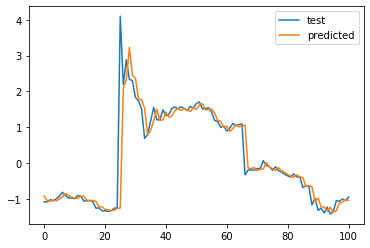

In [75]:
plt.plot(y_test[150:], label = "test")
plt.plot(predicted[150:], label = "predicted")
plt.legend()
plt.show()

In [76]:
correct , incorrect= accuracy(y_test, predicted)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

number correct: 138
number incorrect 112
percetage correct: 0.552


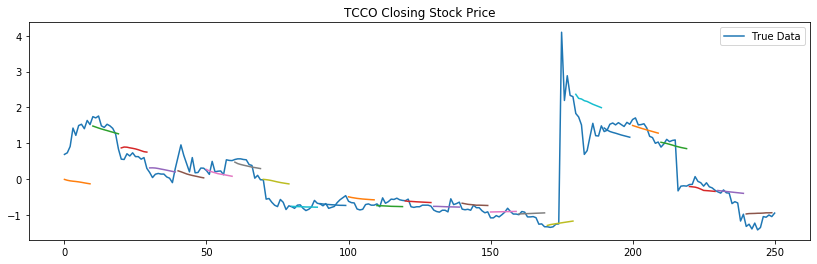

In [77]:
predictions = predict_sequences_multiple(model, x_test, seq_length,10)
plot_results_multiple(predictions, y_test, 10, 'TCCO') 

In [78]:
correct , incorrect = n_day_accuracy(10, y_test, predictions)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

number correct: 10
number incorrect 12
percetage correct: 0.45454545454545453


In [79]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [80]:
best = 0.0000001
average = 0
length = 0

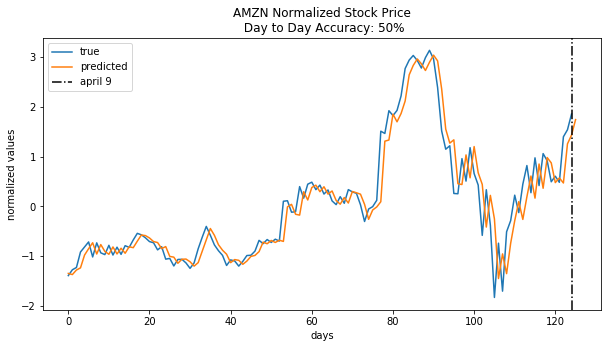

<Figure size 432x288 with 0 Axes>

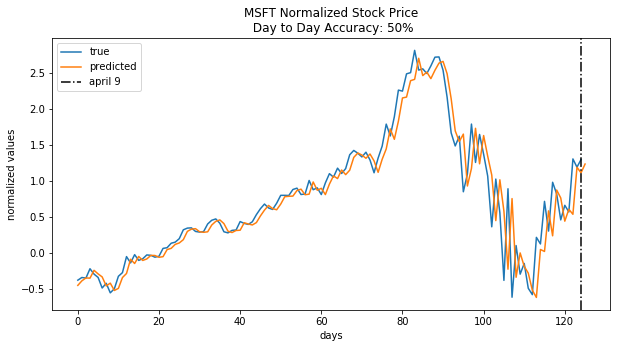

<Figure size 432x288 with 0 Axes>

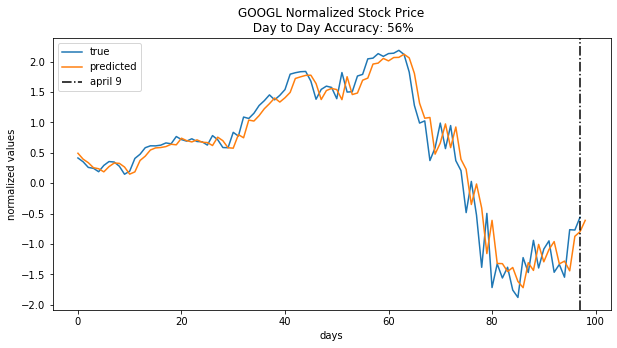

<Figure size 432x288 with 0 Axes>

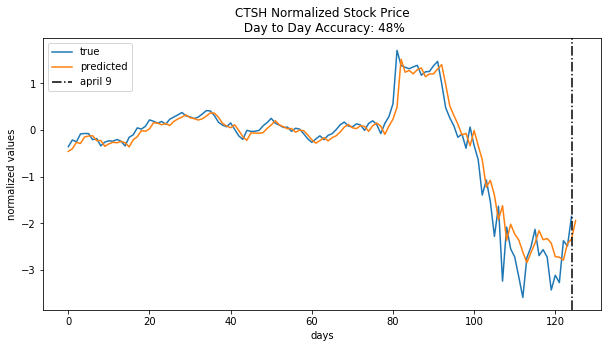

<Figure size 432x288 with 0 Axes>

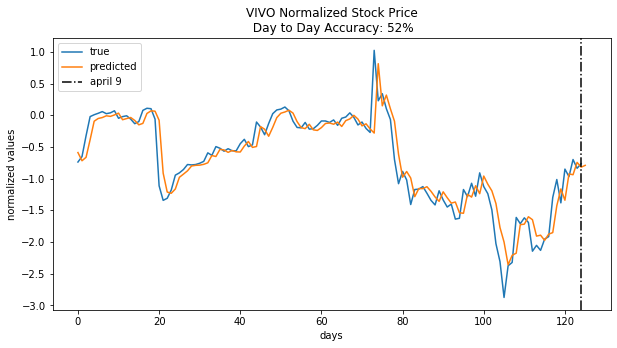

<Figure size 432x288 with 0 Axes>

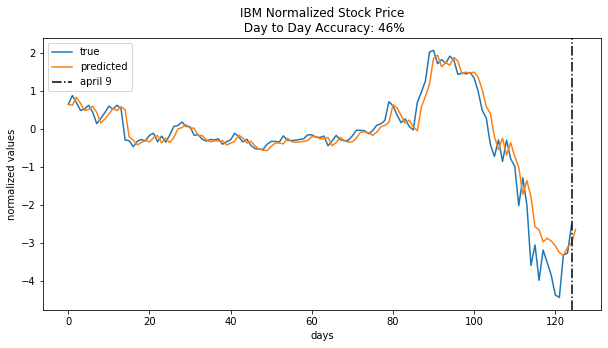

<Figure size 432x288 with 0 Axes>

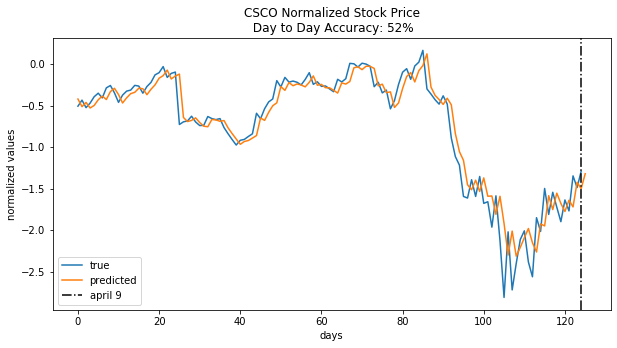

<Figure size 432x288 with 0 Axes>

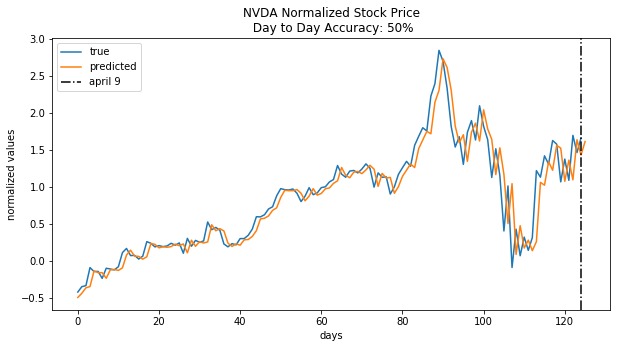

<Figure size 432x288 with 0 Axes>

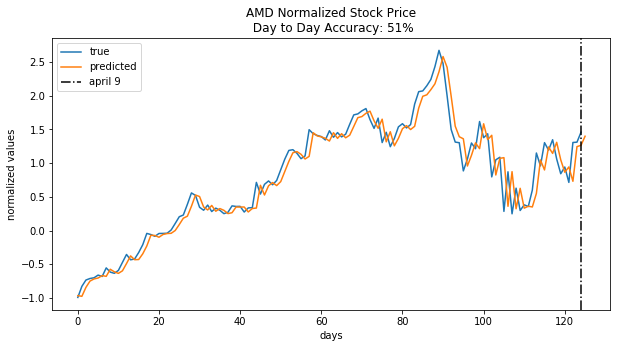

<Figure size 432x288 with 0 Axes>

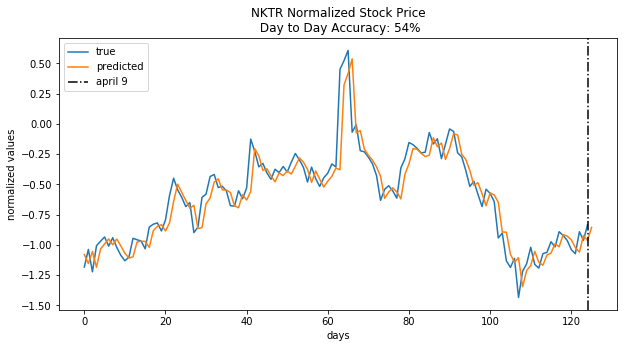

<Figure size 432x288 with 0 Axes>

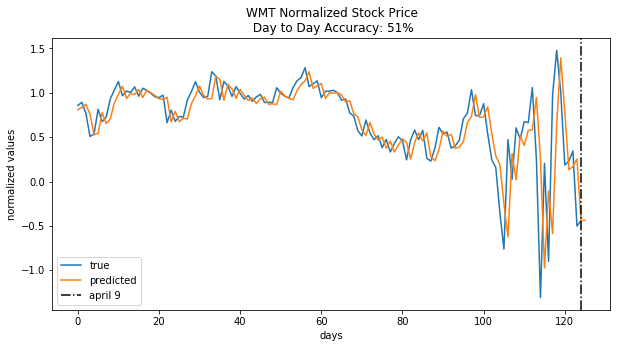

<Figure size 432x288 with 0 Axes>

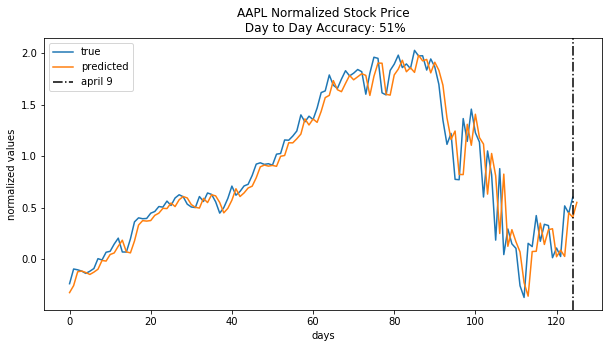

<Figure size 432x288 with 0 Axes>

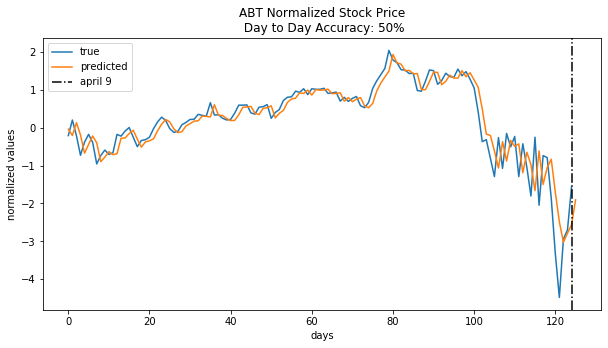

<Figure size 432x288 with 0 Axes>

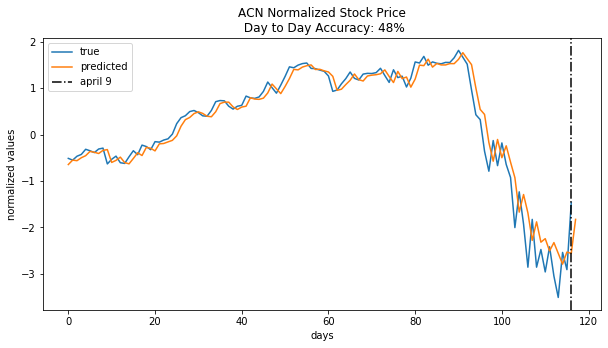

<Figure size 432x288 with 0 Axes>

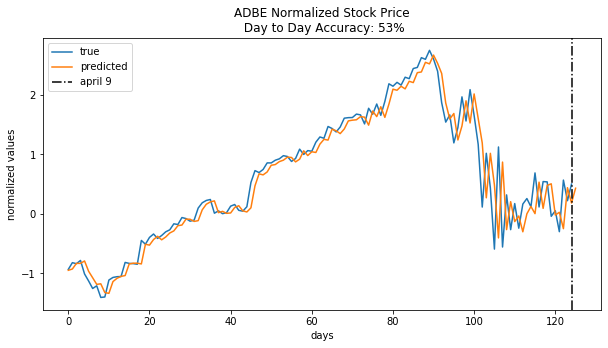

<Figure size 432x288 with 0 Axes>

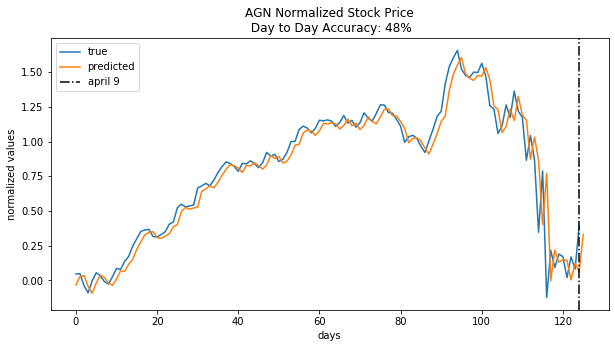

<Figure size 432x288 with 0 Axes>

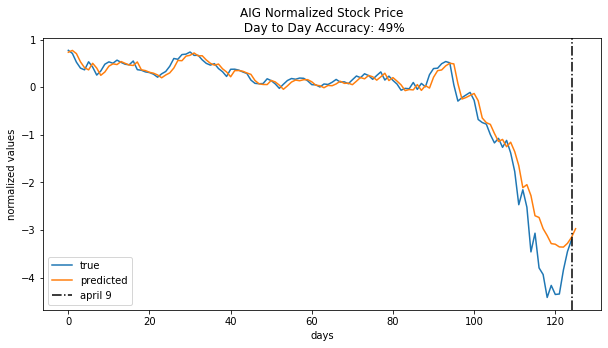

<Figure size 432x288 with 0 Axes>

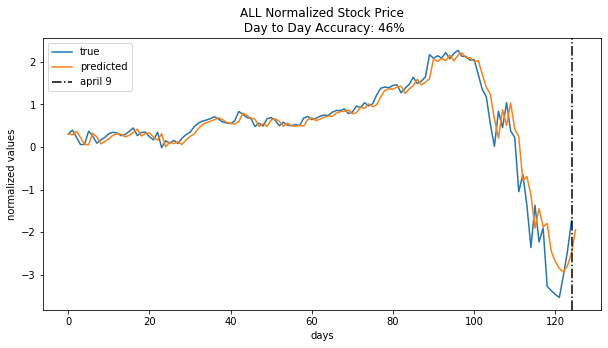

<Figure size 432x288 with 0 Axes>

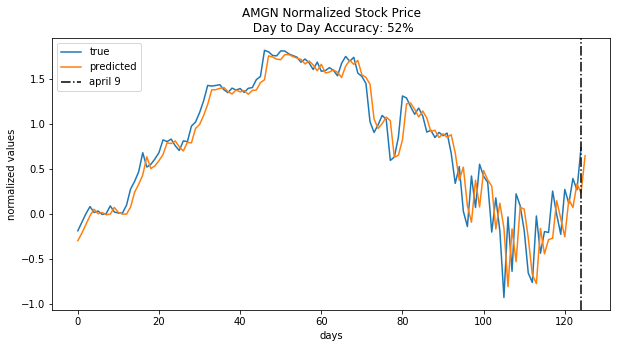

not found


<Figure size 432x288 with 0 Axes>

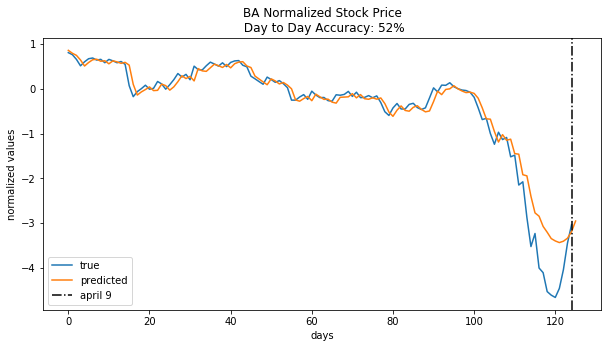

<Figure size 432x288 with 0 Axes>

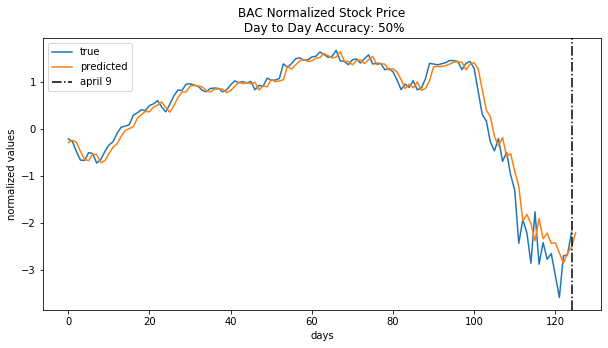

<Figure size 432x288 with 0 Axes>

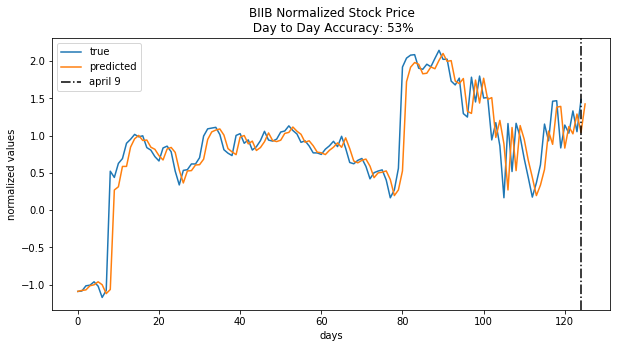

<Figure size 432x288 with 0 Axes>

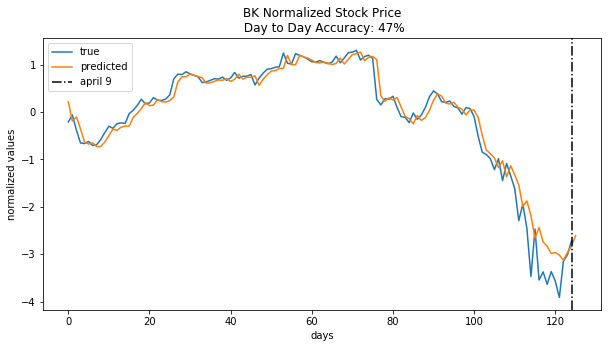

<Figure size 432x288 with 0 Axes>

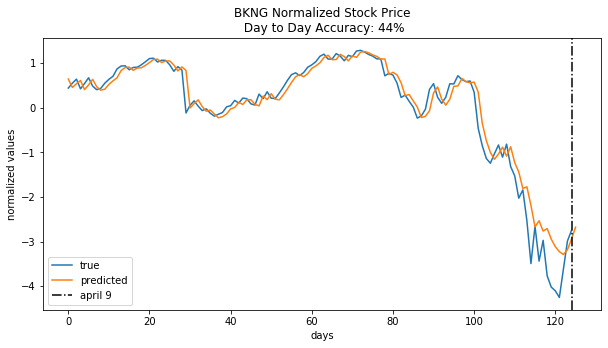

not found


<Figure size 432x288 with 0 Axes>

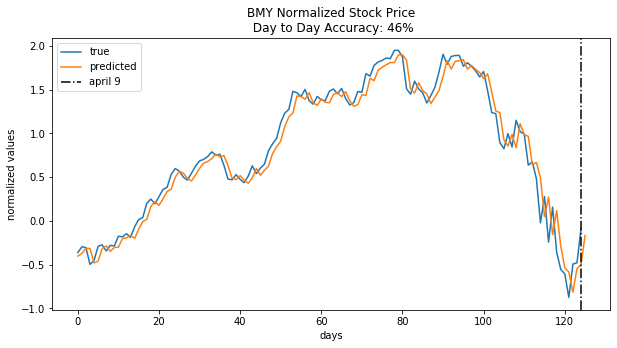

<Figure size 432x288 with 0 Axes>

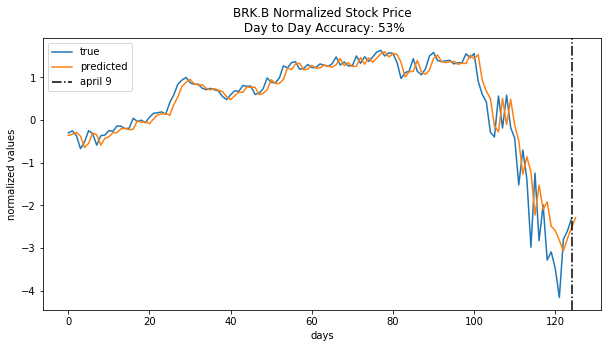

<Figure size 432x288 with 0 Axes>

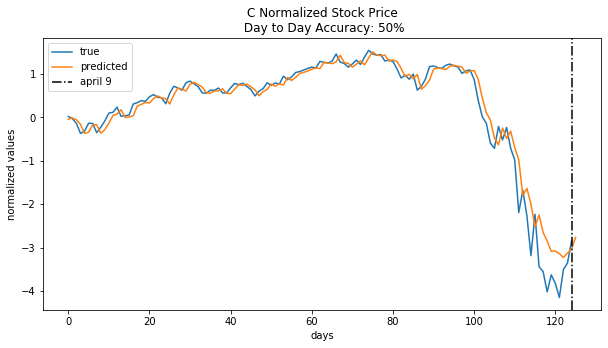

<Figure size 432x288 with 0 Axes>

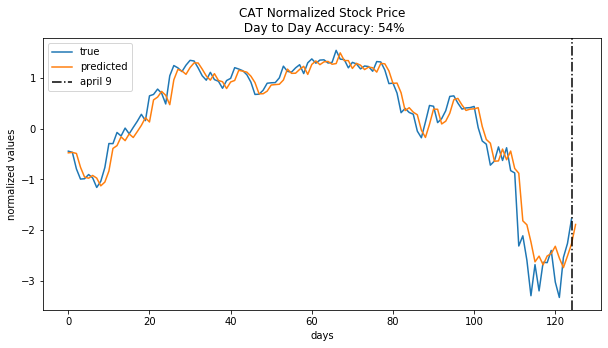

not found


<Figure size 432x288 with 0 Axes>

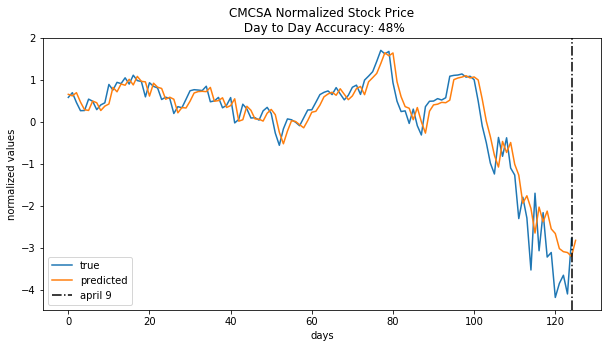

<Figure size 432x288 with 0 Axes>

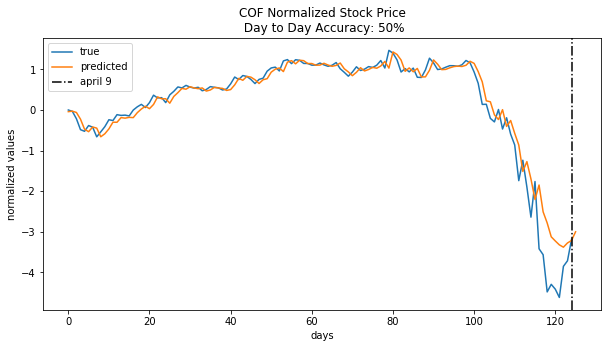

<Figure size 432x288 with 0 Axes>

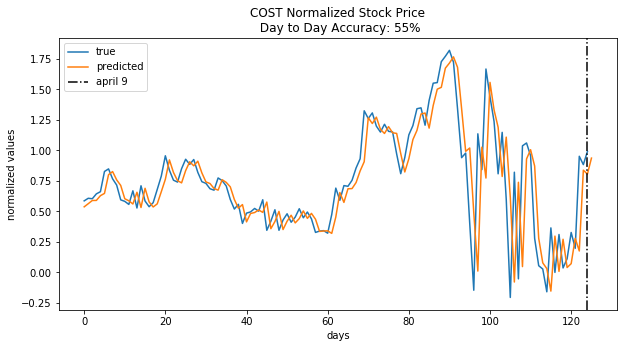

<Figure size 432x288 with 0 Axes>

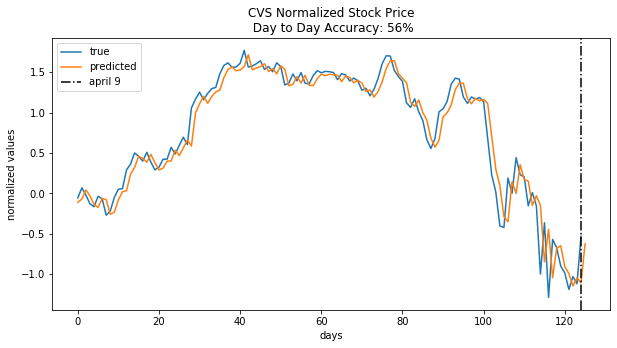

not found


<Figure size 432x288 with 0 Axes>

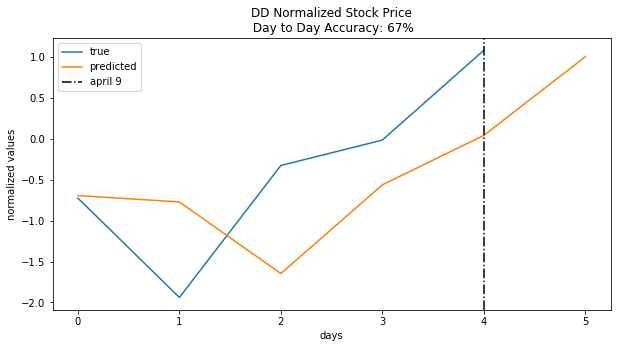

<Figure size 432x288 with 0 Axes>

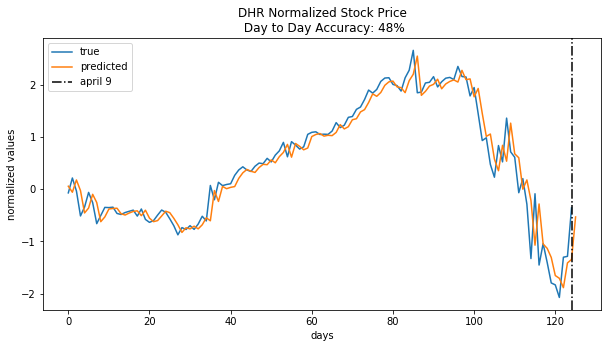

<Figure size 432x288 with 0 Axes>

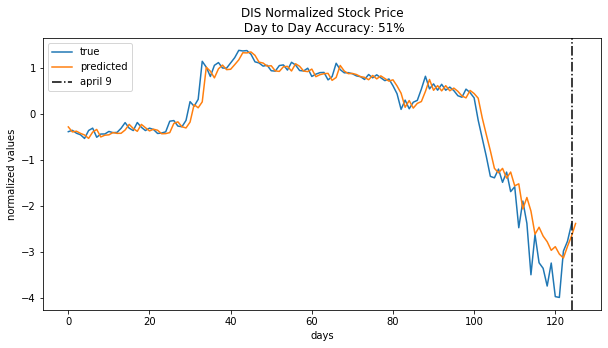

<Figure size 432x288 with 0 Axes>

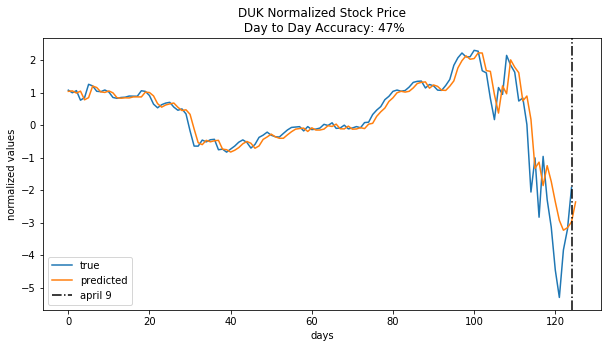

not found


<Figure size 432x288 with 0 Axes>

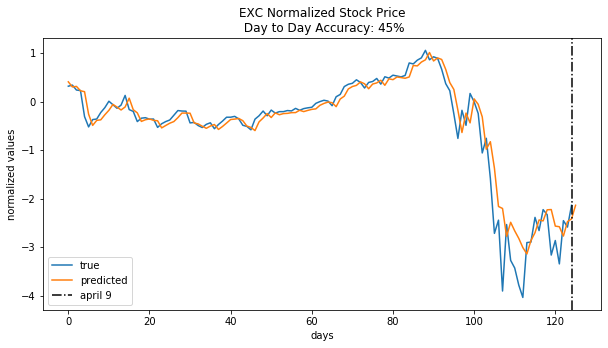

<Figure size 432x288 with 0 Axes>

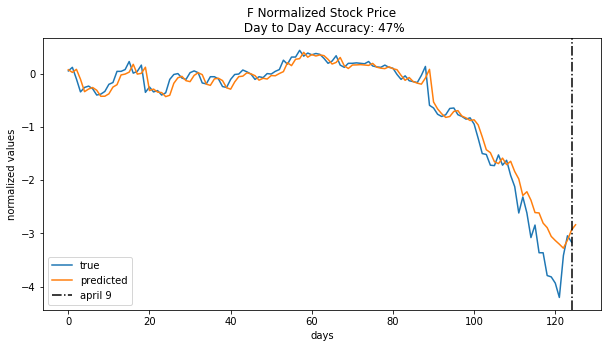

<Figure size 432x288 with 0 Axes>

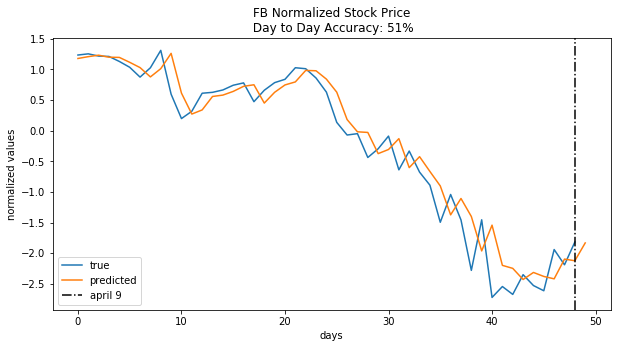

<Figure size 432x288 with 0 Axes>

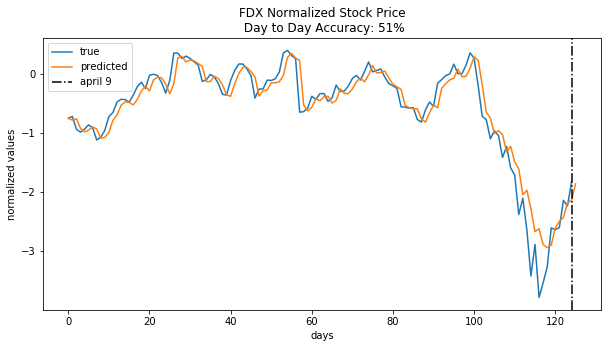

<Figure size 432x288 with 0 Axes>

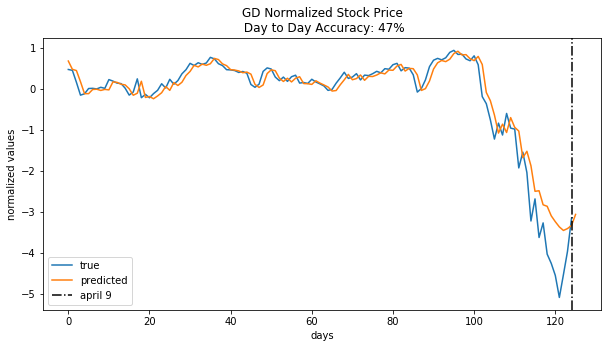

not found


<Figure size 432x288 with 0 Axes>

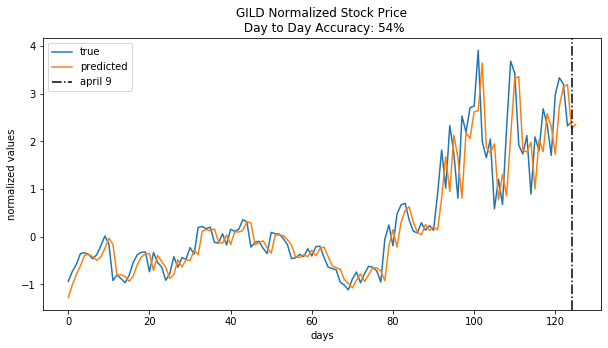

<Figure size 432x288 with 0 Axes>

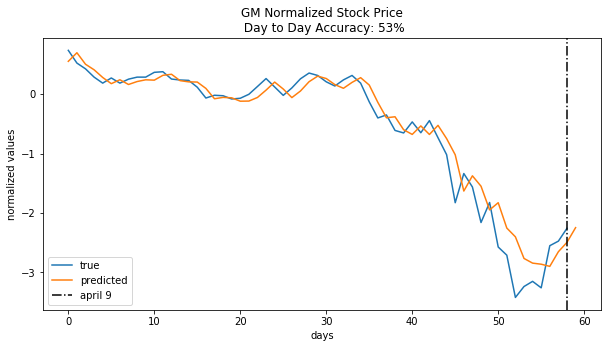

<Figure size 432x288 with 0 Axes>

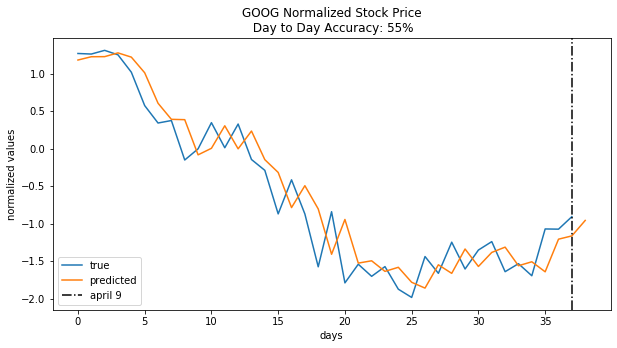

<Figure size 432x288 with 0 Axes>

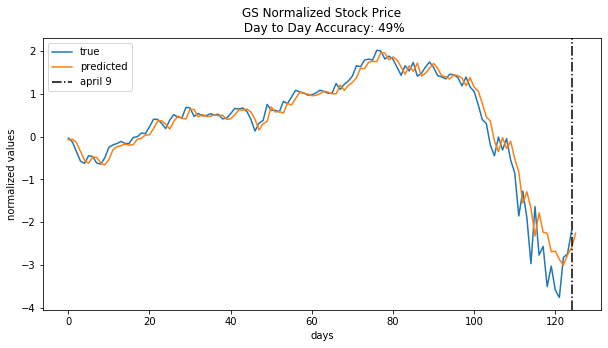

not found


<Figure size 432x288 with 0 Axes>

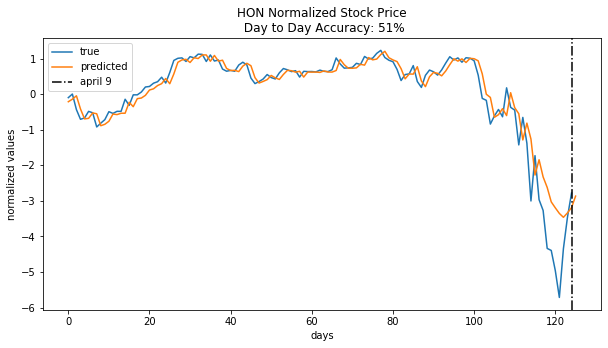

<Figure size 432x288 with 0 Axes>

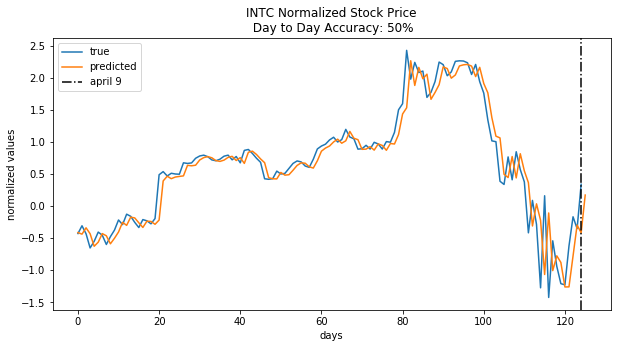

<Figure size 432x288 with 0 Axes>

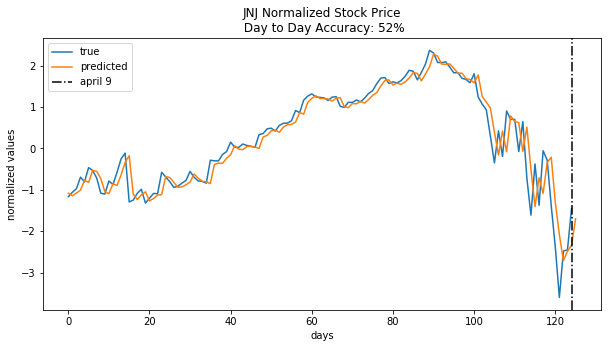

<Figure size 432x288 with 0 Axes>

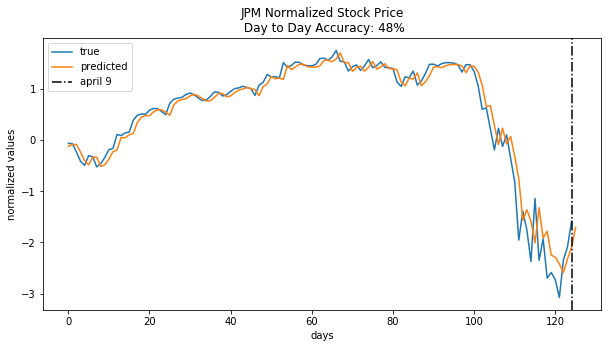

<Figure size 432x288 with 0 Axes>

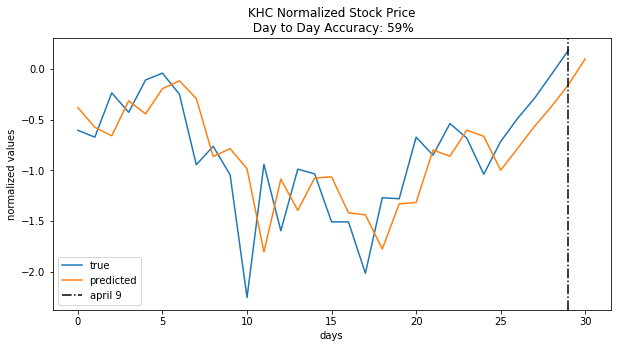

<Figure size 432x288 with 0 Axes>

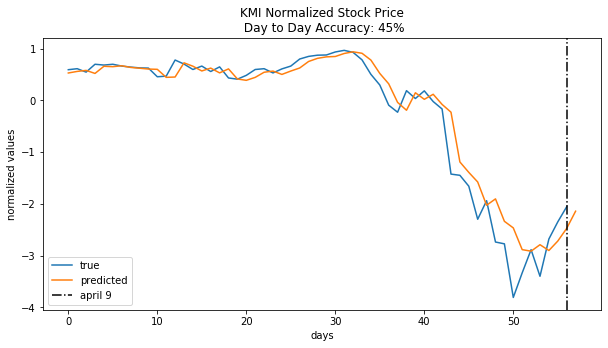

<Figure size 432x288 with 0 Axes>

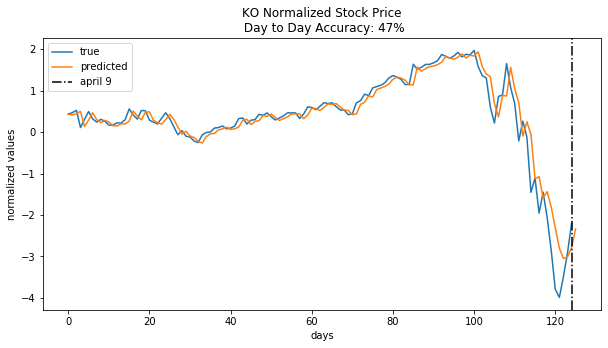

<Figure size 432x288 with 0 Axes>

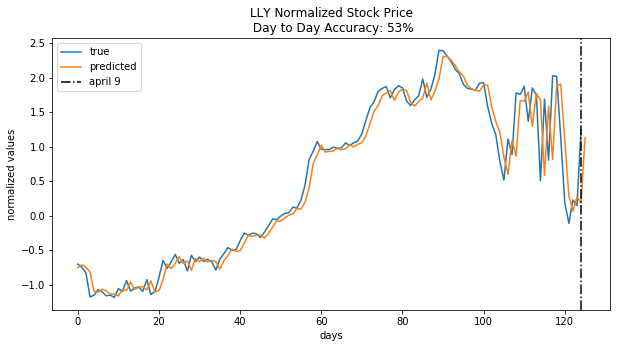

<Figure size 432x288 with 0 Axes>

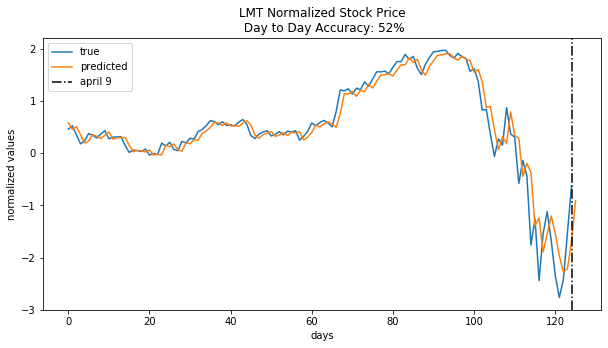

<Figure size 432x288 with 0 Axes>

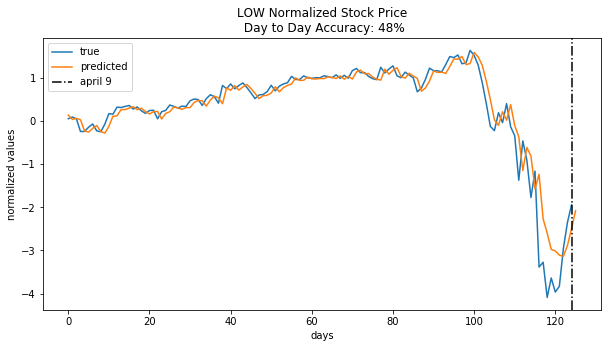

not found


<Figure size 432x288 with 0 Axes>

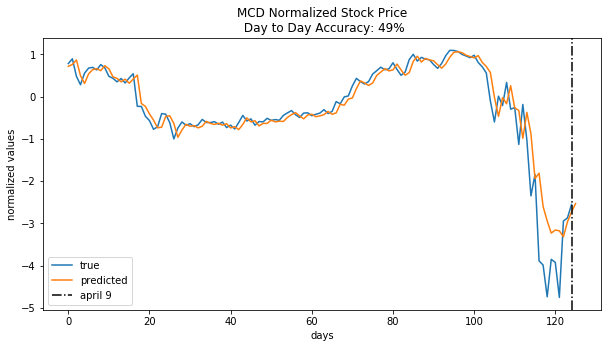

<Figure size 432x288 with 0 Axes>

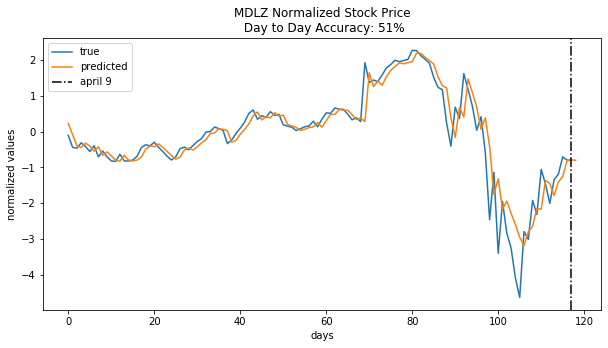

<Figure size 432x288 with 0 Axes>

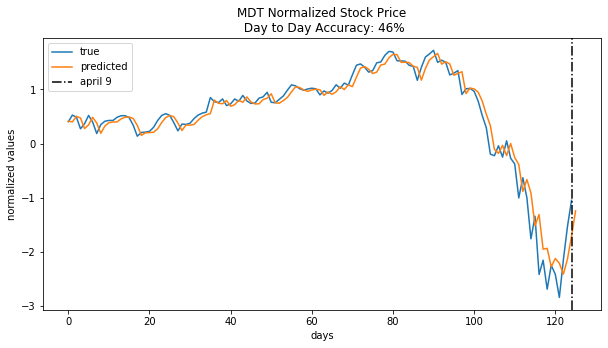

<Figure size 432x288 with 0 Axes>

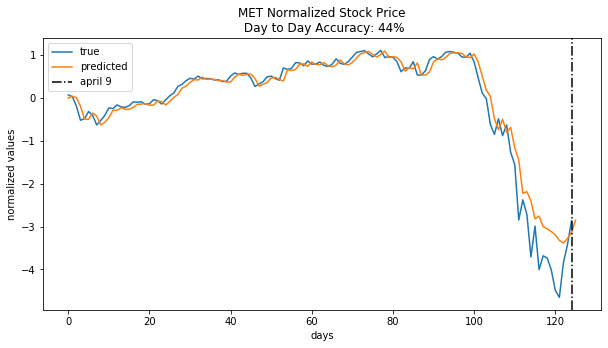

<Figure size 432x288 with 0 Axes>

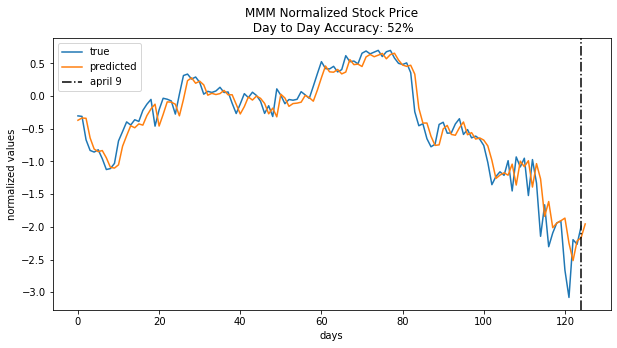

not found


<Figure size 432x288 with 0 Axes>

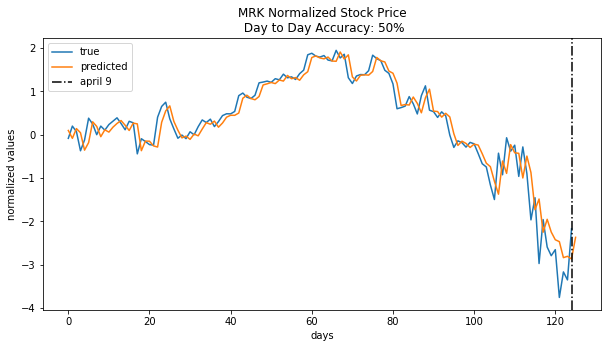

<Figure size 432x288 with 0 Axes>

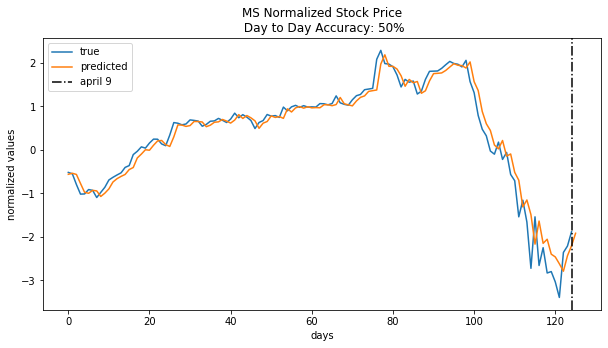

<Figure size 432x288 with 0 Axes>

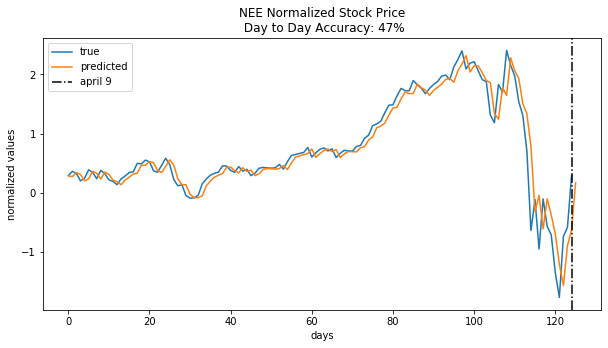

<Figure size 432x288 with 0 Axes>

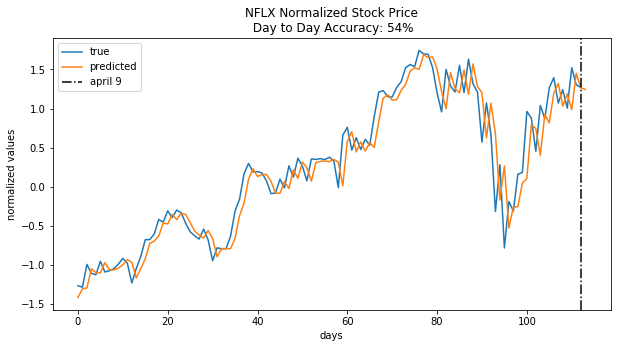

not found


<Figure size 432x288 with 0 Axes>

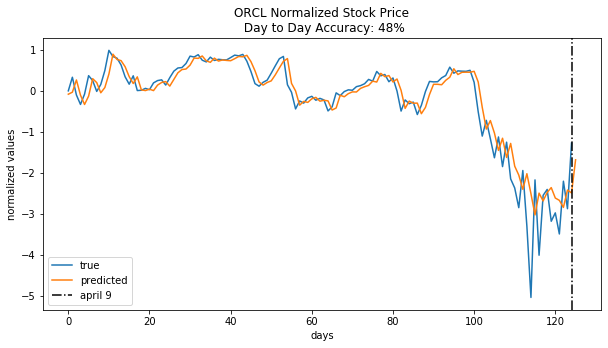

<Figure size 432x288 with 0 Axes>

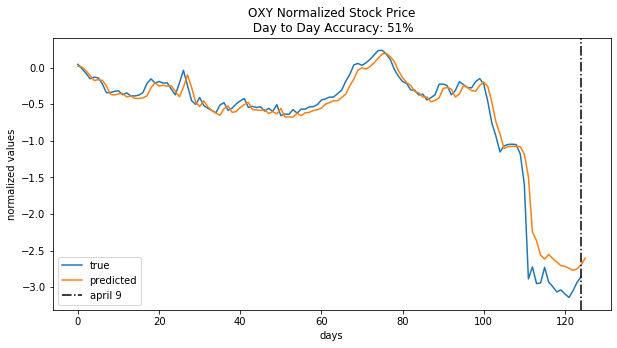

<Figure size 432x288 with 0 Axes>

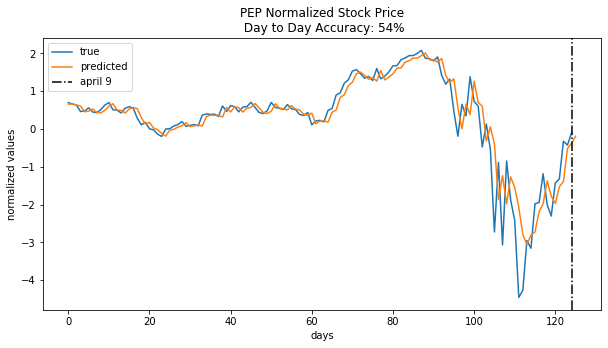

<Figure size 432x288 with 0 Axes>

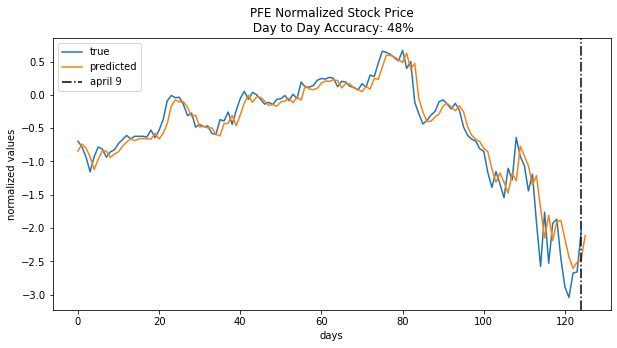

not found


<Figure size 432x288 with 0 Axes>

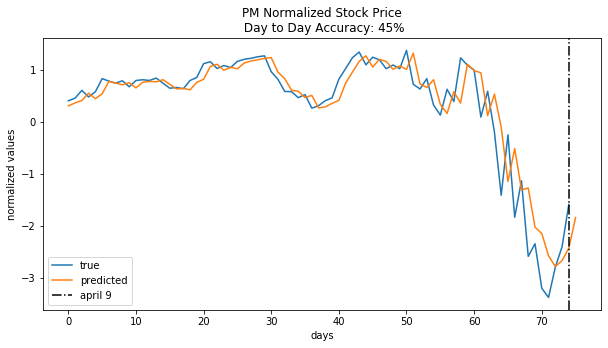

<Figure size 432x288 with 0 Axes>

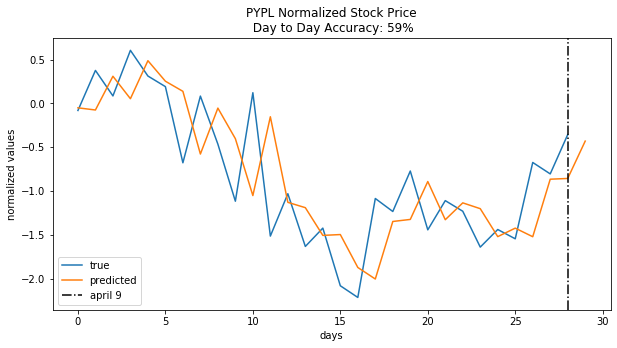

<Figure size 432x288 with 0 Axes>

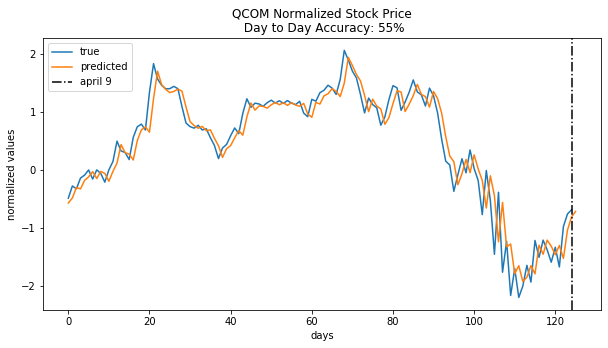

<Figure size 432x288 with 0 Axes>

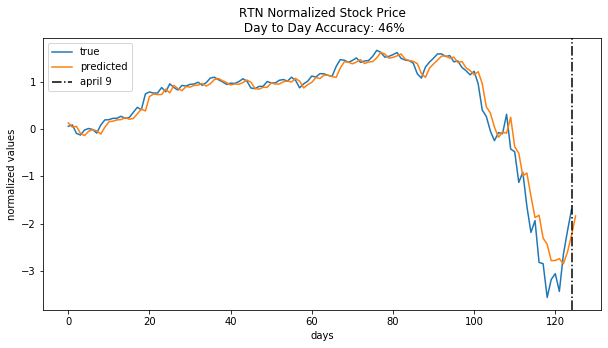

<Figure size 432x288 with 0 Axes>

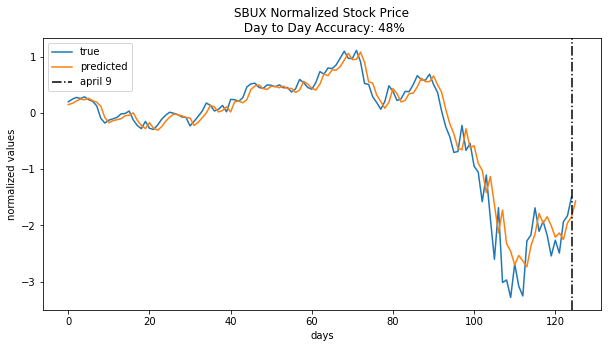

not found


<Figure size 432x288 with 0 Axes>

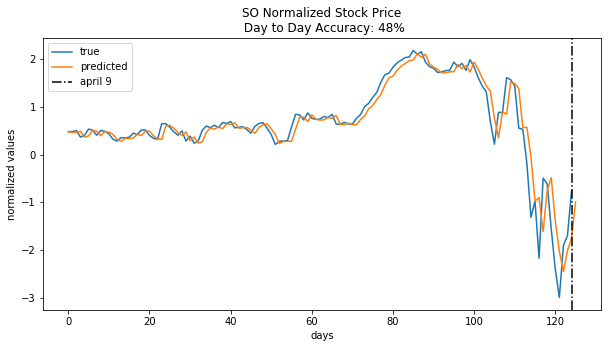

<Figure size 432x288 with 0 Axes>

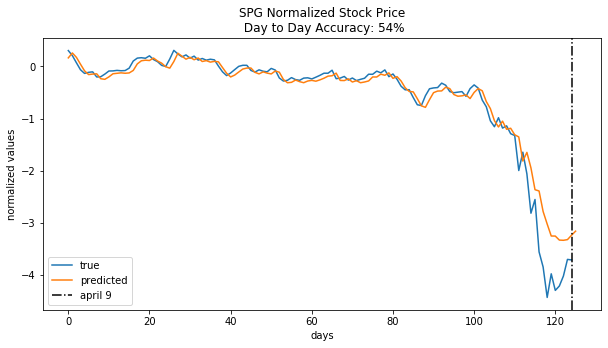

<Figure size 432x288 with 0 Axes>

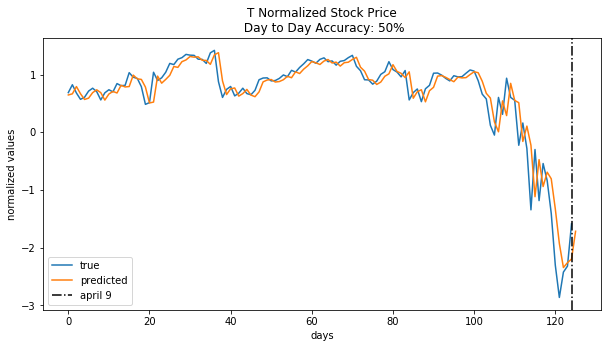

<Figure size 432x288 with 0 Axes>

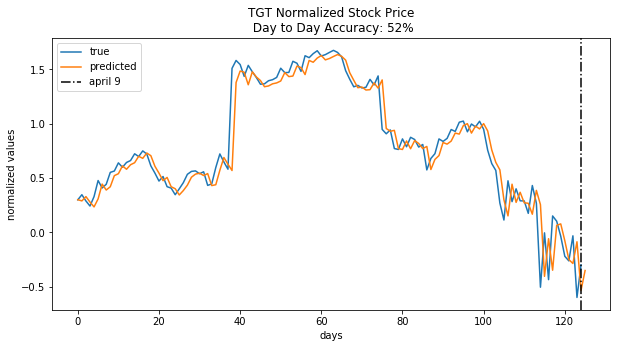

<Figure size 432x288 with 0 Axes>

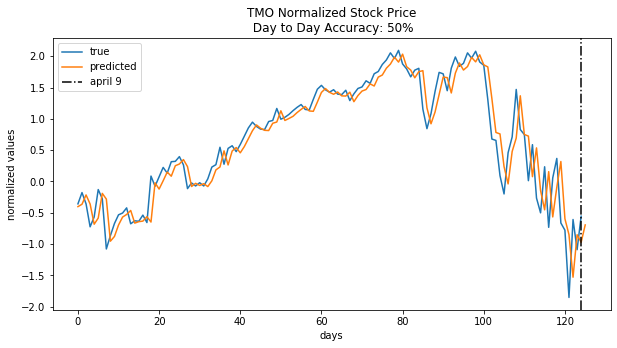

<Figure size 432x288 with 0 Axes>

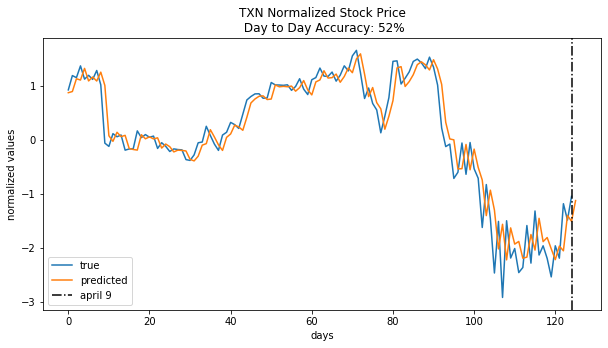

<Figure size 432x288 with 0 Axes>

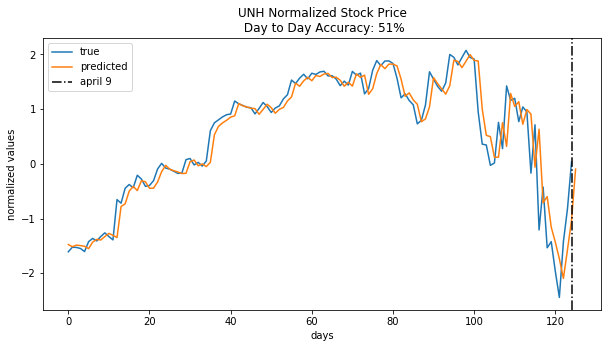

<Figure size 432x288 with 0 Axes>

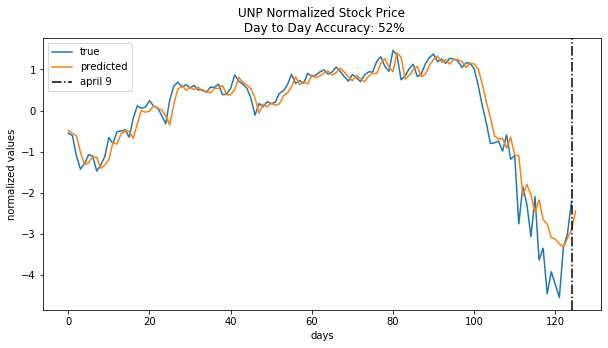

<Figure size 432x288 with 0 Axes>

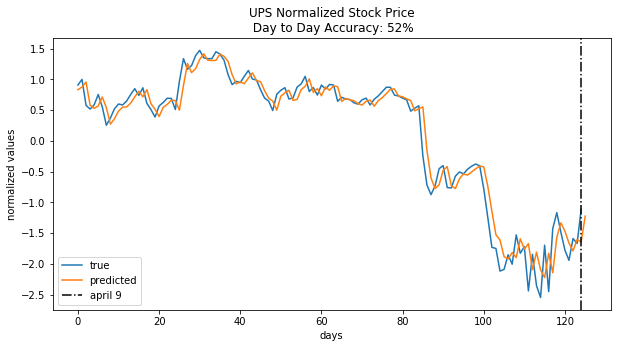

<Figure size 432x288 with 0 Axes>

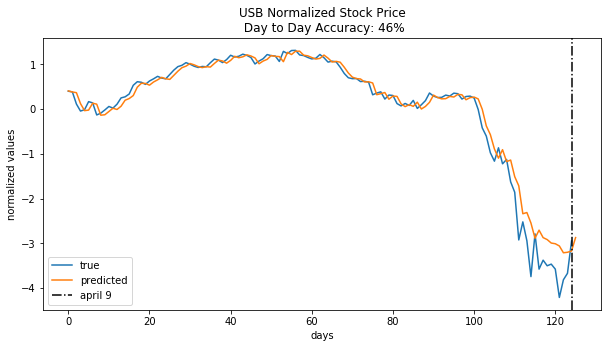

<Figure size 432x288 with 0 Axes>

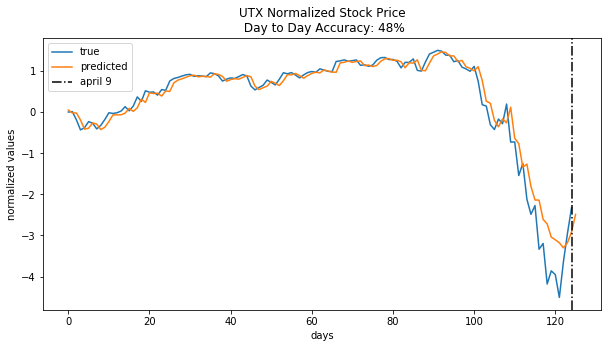

not found


<Figure size 432x288 with 0 Axes>

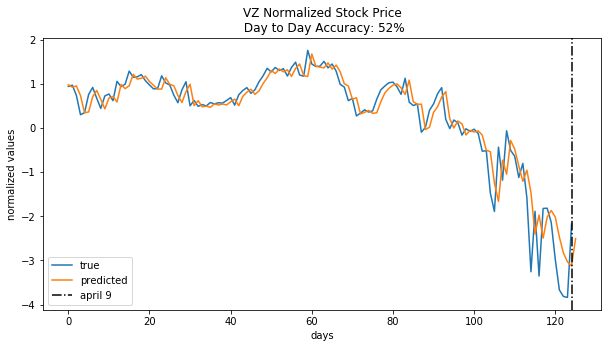

<Figure size 432x288 with 0 Axes>

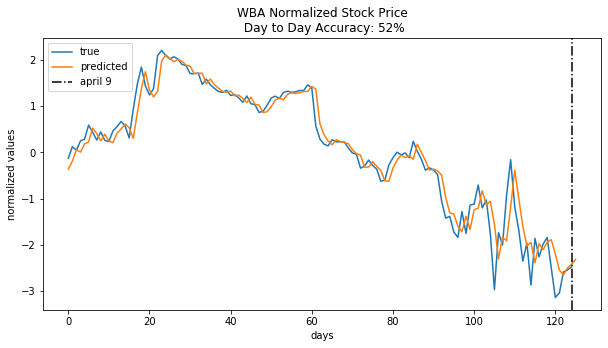

<Figure size 432x288 with 0 Axes>

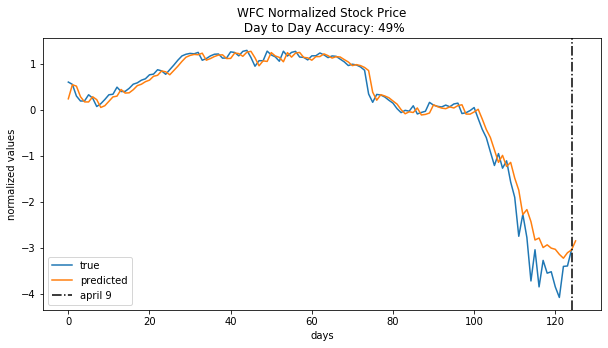

<Figure size 432x288 with 0 Axes>

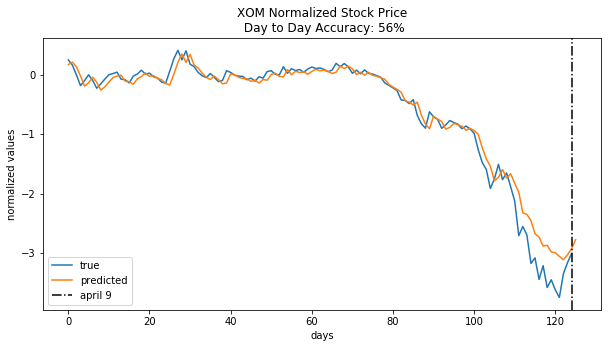

best stock: DD
score:  0.6666666666666666
average:  0.5051712269339874


<Figure size 432x288 with 0 Axes>

In [81]:
#10 works best
#stock_list1 = set_stock_list()
for stock in stock_list1:
    try:
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
        predicted = predict_point_by_point(model, x_test)        
        correct , incorrect = accuracy(y_test, predicted)
        new = []
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        predicted = np.append(predicted,newPredicted)
        shown_val = round(len(y_test) *.5)  
        stock_acc = round(float(correct/(correct+incorrect))*100) 
        plt.figure(figsize = (10,5))
        plt.plot(y_test[shown_val:], label = 'true')
        plt.plot(predicted[shown_val:], label = 'predicted')
        plt.axvline(len(y_test[shown_val:])-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
        plt.xlabel('days')
        plt.ylabel('normalized values')
        plt.title(stock + " Normalized Stock Price\n Day to Day Accuracy: " + str(stock_acc)+ "%")
        plt.legend()
        #plt.savefig("../1dayPredictions/" + stock +".png")
        plt.show()
        plt.clf()
        average = average + float(correct/(correct+incorrect))
        length = length + 1
        if float(correct/(correct+incorrect)) > best:
            best = float(correct/(correct+incorrect))
            best_stock = stock
            
    except:
        print("not found")
print("best stock:",best_stock)
print("score: ",best)
print("average: ", float(average/length))

In [82]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH',
               'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [83]:
days = 15

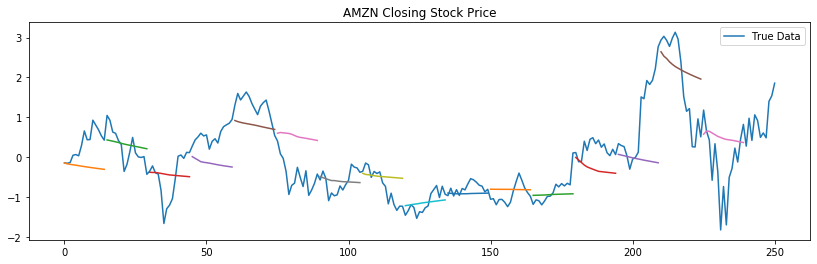

AMZN
number correct: 9
number incorrect 6
percetage correct: 0.6


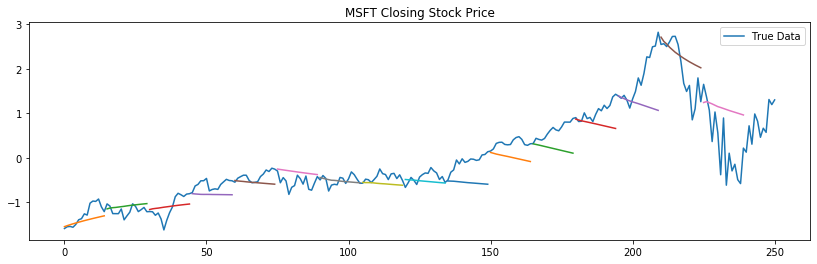

MSFT
number correct: 7
number incorrect 8
percetage correct: 0.4666666666666667


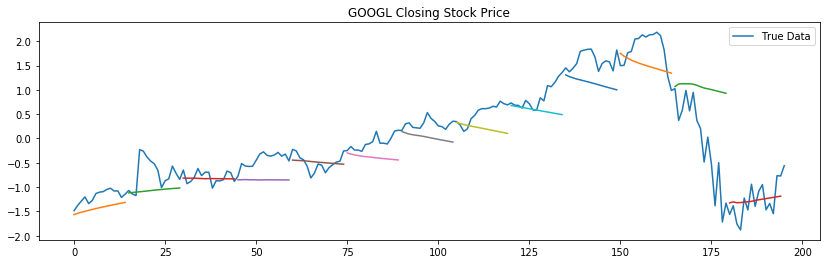

GOOGL
number correct: 4
number incorrect 8
percetage correct: 0.3333333333333333


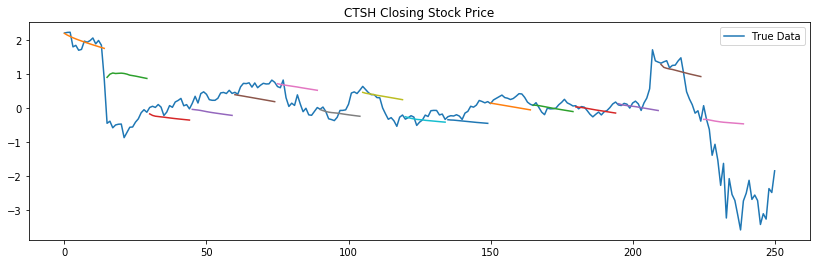

CTSH
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


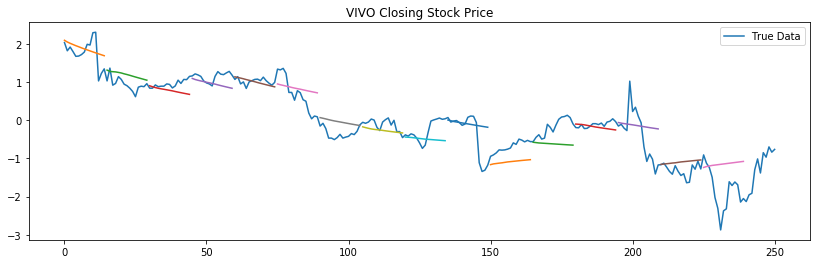

VIVO
number correct: 9
number incorrect 6
percetage correct: 0.6


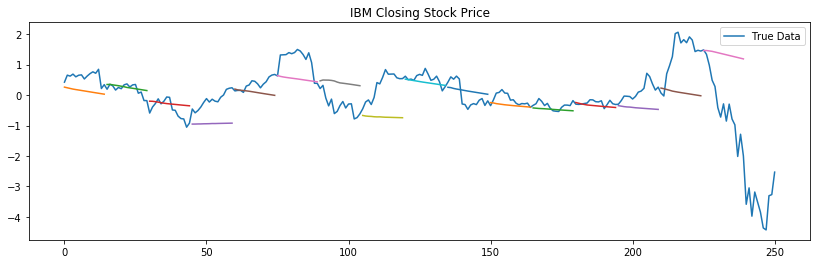

IBM
number correct: 9
number incorrect 6
percetage correct: 0.6


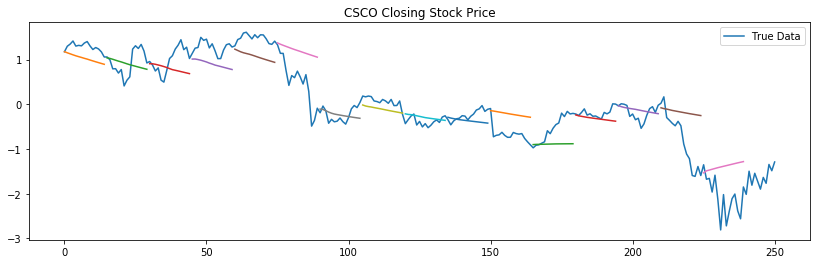

CSCO
number correct: 9
number incorrect 6
percetage correct: 0.6


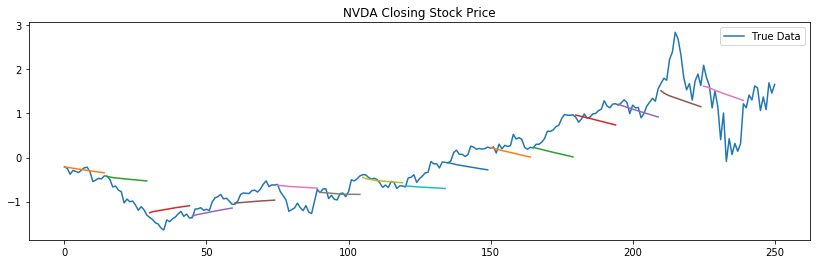

NVDA
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


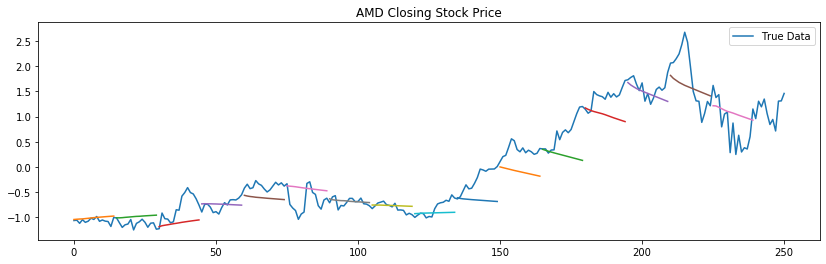

AMD
number correct: 6
number incorrect 9
percetage correct: 0.4


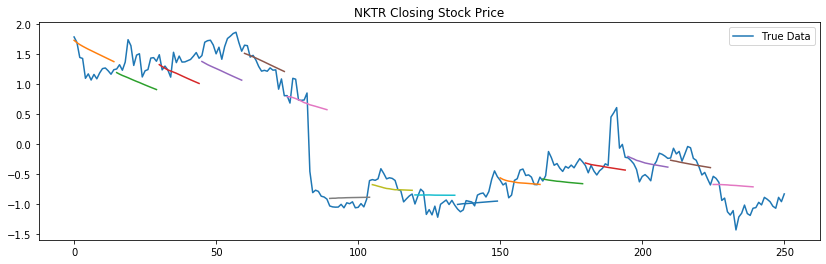

NKTR
number correct: 9
number incorrect 6
percetage correct: 0.6


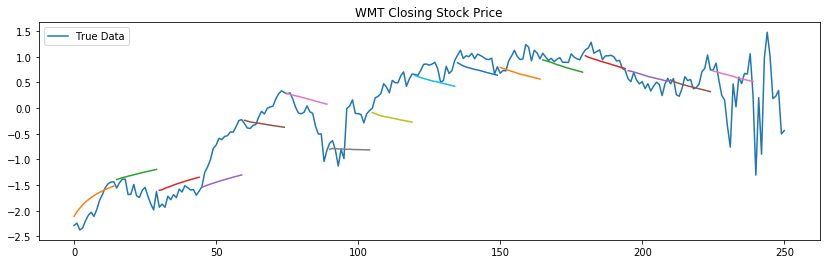

WMT
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


In [84]:
for stock in stock_list1:
    try:
        x_train,x_test,y_train,y_test, result, row = set_data(stock , seq_length)
        x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
        predictions = predict_sequences_multiple(model, x_test, seq_length,days)
        plot_results_multiple(predictions, y_test,days, stock) 
        correct , incorrect= n_day_accuracy(days, y_test, predictions)
        print(stock)
        print("number correct:", correct)
        print("number incorrect", incorrect)
        print("percetage correct:", float(correct/(correct+incorrect)))
    except:
        print("not found")

In [86]:
model.save('allScaler.h5')

In [51]:
model = load_model('bestMulti3.h5')


In [56]:
def predict_future(days, model , x_test, y_test, seq_len):
        prev_predicted = predict_point_by_point(model, x_test)
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        prev_predicted = np.append(prev_predicted,newPredicted)
        for i in range(2,days+1):
            if i < seq_len:
                new = x_test[-1][i:]            
                new = np.append(new, prev_predicted[len(prev_predicted)-i:])
            else:
                new = prev_predicted[len(prev_predicted)-seq_len-1:]
            if len(new) > seq_len:
                new = new[1:]
            new = new.reshape(1,-1,1)
            newPredicted = model.predict(new)
            prev_predicted = np.append(prev_predicted,newPredicted)
        return (y_test, prev_predicted)

In [61]:
days = 15

In [64]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('NVDA',seq_length)
#x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
predictions = predict_sequences_multiple(model, x_test, seq_length,days)
correct , incorrect= n_day_accuracy(days, y_test, predictions)
stock_acc = round(float(correct/(correct+incorrect)*100))
y_test, predicted = predict_future(days, model, x_test, y_test, seq_length)

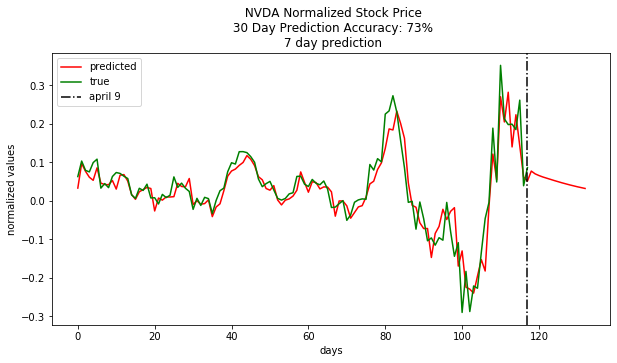

In [65]:
spot = round(len(predicted) * .5)
plt.figure(figsize = (10,5))
plt.plot(predicted[len(predicted)-spot:], color = 'red', label = 'predicted')
plt.plot(y_test[len(y_test)-spot+days:], color = 'g', label = 'true')
plt.xlabel('days')
plt.ylabel('normalized values')
plt.title(" NVDA Normalized Stock Price\n 30 Day Prediction Accuracy: " + str(stock_acc)+ "%\n 7 day prediction")
plt.axvline(spot-days-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
plt.legend()
plt.show()

In [ ]:
stock_list2 = set_stock_list()

In [ ]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']


In [ ]:
for stock in stock_list2:
    try:
        if stock in stock_list:
            x_train, x_test, y_train,y_test, for_reverse, row = set_data(stock,seq_length)
            spot = round(len(y_test) * .5)
        else:
            x_train, x_test, y_train,y_test, for_reverse, row = set_data1(stock,seq_length)
            if len(y_test) > 500 :
                spot = 100
                x_test = x_test[round(len(x_test)*.7):]
            else:
                spot = round(len(y_test) * .6)
        #predictions = predict_sequences_multiple(model, x_test, seq_length,days)
        #correct , incorrect= n_day_accuracy(days, y_test, predictions)
        #stock_acc = round(float(correct/(correct+incorrect)*100))
        y_test, predicted = predict_future(days, model, x_test, y_test)
        plt.figure(figsize = (10,5))
        plt.plot(predicted[len(predicted)-spot:], color = 'red', label = 'predicted')
        plt.plot(y_test[len(y_test)-spot+days:], color = 'g', label = 'true')
        plt.xlabel('Days')
        plt.ylabel('Normalized Values')
        plt.title(stock + " Normalized Stock Price\n 10 Day Prediction")
        plt.axvline(spot-days-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
        plt.legend()
        plt.savefig("../next_n_days/" + stock +".png")
    except:
        print("not found")